In [1]:
import sys
sys.path.insert(0, "../")
from chunkgfn.environment.rna_binding import RNABindingModule
from chunkgfn.algo.tb_gfn import TBGFN
from chunkgfn.algo.a2c import A2C
from chunkgfn.algo.sac import SAC
from chunkgfn.algo.random_sampler import RandomSampler
from chunkgfn.algo.utils import has_trainable_parameters

from torch.distributions import Categorical
from scipy.stats import linregress, spearmanr
import networkx as nx
from einops import repeat, rearrange
from polyleven import levenshtein
from pathlib import Path

import torch
from tqdm.notebook import tqdm
import lightning as L
from matplotlib.lines import Line2D
from scipy import stats
import matplotlib.pyplot as plt
from addict import Dict
import numpy as np
import wandb
from datetime import datetime

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update(
    {
        "font.serif": [
            "Computer Modern Roman",
            "Times New Roman",
            "Utopia",
            "New Century Schoolbook",
            "Century Schoolbook L",
            "ITC Bookman",
            "Bookman",
            "Times",
            "Palatino",
            "Charter",
            "serif" "Bitstream Vera Serif",
            "DejaVu Serif",
        ]
    }
)

# Some preliminary code

In [2]:
def calculate_mean_std(iteration_key, value_key, *dicts):
    key_value = {}
    all_iterations = set()
    for i, d in enumerate(dicts):
        iterations = d[iteration_key]
        values = d[value_key]

        key_value[i] = {k: v for (k,v) in zip(iterations, values)}
        all_iterations = all_iterations.union(set(iterations))

    all_iterations = sorted(all_iterations)
    mean = []
    std = []
    for i in all_iterations:
        values = [key_value[j][i]  for j in key_value if i in key_value[j]]
        mean.append(np.mean(values))
        std.append(np.std(values))
    return all_iterations, mean, std

def get_library_embeddings(sampler, env):
    """Produce embedding for all actions in the library.
    Returns:
        library_embeddings (torch.Tensor[n_actions, action_embedding]): Embeddings for all actions.
    """
    action_indices = env.action_indices
    library_embeddings = []
    for action, indices in action_indices.items():
        library_embeddings.append(
            sampler.action_embedder(
                torch.LongTensor(indices).to(sampler.device).unsqueeze(0)
            )
        )
    library_embeddings = torch.cat(library_embeddings, dim=0)
    return library_embeddings

def get_forward_logits(state: torch.Tensor, algo, env) -> torch.Tensor:
    """Get the forward logits for the given state.
    Args:
        state (torch.Tensor[batch_size, *state_shape]): State.
    Return:
        logits (torch.Tensor[batch_size, n_actions]): Forward logits.
    """
    if algo.forward_policy is None:
        bs = state.shape[0]
        logits = torch.zeros(bs, env.n_actions).to(state.device)
        return logits
    action_embedding = algo.forward_policy(env.preprocess_states(state))
    dim = action_embedding.shape[-1]
    library_embeddings = get_library_embeddings(algo, env)
    logits = torch.einsum("bd, nd -> bn", action_embedding, library_embeddings) / (
        dim**0.5
    )  # Same as in softmax
    return logits

def get_backward_logits(state: torch.Tensor, algo, env) -> torch.Tensor:
    """Get the forward logits for the given state.
    Args:
        state (torch.Tensor[batch_size, *state_shape]): State.
    Return:
        logits (torch.Tensor[batch_size, n_actions]): Forward logits.
    """
    processed = env.preprocess_states(state)
    if algo.backward_policy is not None and has_trainable_parameters(
        algo.backward_policy
    ):
        # If the backward policy is trainable, use action embeddings, otherwise,
        # don't use them and output logits directly.
        if isinstance(processed, tuple):
            action_embedding = algo.backward_policy(*processed)
        else:
            action_embedding = algo.backward_policy(processed)
        dim = action_embedding.shape[-1]
        library_embeddings = get_library_embeddings(algo, env)
        logits = torch.einsum(
            "bd, nd -> bn", action_embedding, library_embeddings
        ) / (dim**0.5)  # Same as in softmax
        return logits

    if isinstance(processed, tuple):
        logits = algo.backward_policy(*processed)
    else:
        logits = algo.backward_policy(processed)
    return logits

# Data fetching

In [4]:
api = wandb.Api()
runs = api.runs(path="yoshua-bengio/gfn-chunking", filters={"config.task_name": "rna_binding", "tags": "absolute"})
columns = ["_step", 'train/num_modes', 'train/num_visited', 'train/logreward', 'train/trajectory_length', 'trainer/global_step', "epoch"]

# Group runs by algorithm and then length
experiments = Dict()
for run in tqdm(runs):
    name = run.name
    history = run.scan_history(keys=columns)
    summary = {}
    for row in history:
        for key in row.keys():
            if key not in summary:
                summary[key] = []
            summary[key].append(row[key])
    summary["id"] = run.id
    config = run.config

    if "algo" in config:
        algo = config["algo"]["_target_"].lower()
    else:
        algo = config["gfn"]["_target_"].lower()
    if "environment" in config:
        task = config["environment"]["task"]
    else:
        task = config["data"]["task"]


    if "a2c" in algo:
        algorithm = "A2C"
    elif "tbgfn" in algo:
        if "compressor" not in name:
            algorithm = "GFN"
        else:
            alpha = config["algo"]["backward_policy"]["alpha"]
            if alpha == 0:
                algorithm = "MaxEnt-GFN"
            else:
                algorithm = "ShortParse-GFN"

    elif "random" in algo:
        algorithm = "Random Sampler"
    elif "sac" in algo:
        algorithm = "SAC"
    elif "option" in algo:
        algorithm = "Option-Critic"
    else:
        raise Exception("can't recognize algorithm: {}".format(algo))

    if "chunk" not in name:
        chunk_type = "No Chunk"
    elif "chunk_replacement" in name:
        chunk_type = "Chunking w/ Replacement"
    elif "chunk" in name:
        chunk_type = "Chunking Basic"

    if len(experiments[task][algorithm][chunk_type]) == 0:
        experiments[task][algorithm][chunk_type] = [summary]
    else:
        experiments[task][algorithm][chunk_type].append(summary)

  0%|          | 0/282 [00:00<?, ?it/s]

In [5]:
experiments["L14_RNA1"]["Random Sampler"]["No Chunk"][2]

{'_step': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  164,
  165,
  166,
  167,
  168,
  169,
  170,

In [4]:
algo_colors = {
    "ShortParse-GFN": "#4363d8",
    "MaxEnt-GFN": "#e6194B",
    "GFN": "#3cb44b",
    "A2C": "#ffe119",
    "Random Sampler": "#f58231" ,
    "SAC": "#911eb4"
}

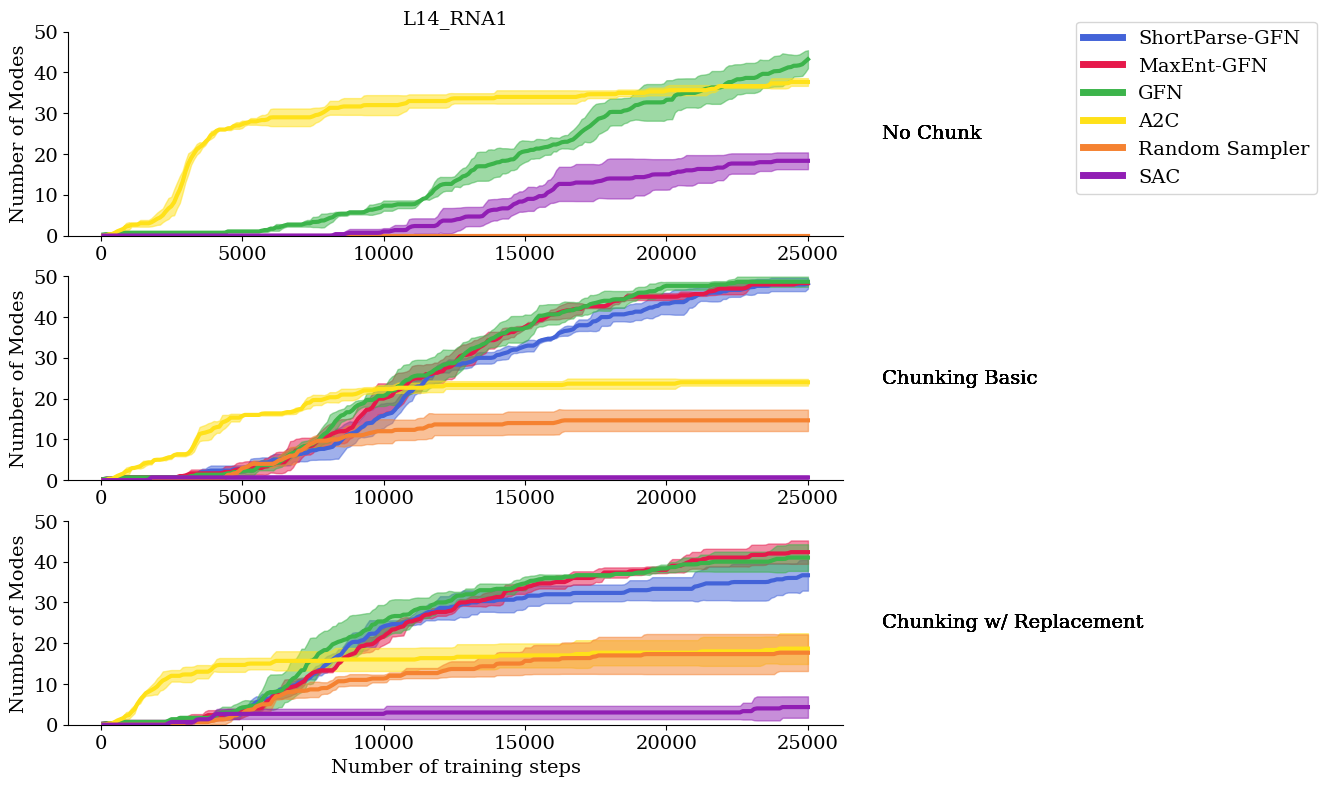

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(10, 9))

chunk_types = [
    "No Chunk",
    "Chunking Basic",
    "Chunking w/ Replacement"
]
handles = []
lines = []
for algorithm in algo_colors:
    for i, chunk_type in enumerate(chunk_types):

        if chunk_type in experiments["L14_RNA1"][algorithm]:
            all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/num_modes", *experiments["L14_RNA1"][algorithm][chunk_type])


            ax[i].plot(all_iterations, mean, label=algorithm, color=algo_colors[algorithm], linewidth=3)

            ax[i].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=algo_colors[algorithm], alpha=0.5)

            ax[i].set_ylim(0,50)

        if i == 0:
            ax[i].set_title("L14_RNA1")

        if i == 2:
            ax[i].set_xlabel("Number of training steps")

        ax[i].text(1.05, 0.5, chunk_type, va='center', ha='left', transform=ax[i].transAxes)
        ax[i].set_ylabel("Number of Modes")


        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

legend_elements = [Line2D([0], [0], color=algo_colors[algo], lw=5, linestyle='-', label=algo) for algo in algo_colors]

# Create the custom legend
ax[0].legend(handles=legend_elements, bbox_to_anchor=(1.3, 1.05), loc='upper left', borderaxespad=0.)


In [25]:
num_modes_dict = Dict()
for algo in algo_colors:
    for chunk_type in ["No Chunk", "Chunking Basic", "Chunking w/ Replacement"]:
        if chunk_type in experiments["L14_RNA1"][algo]:
            mean = np.mean([experiments["L14_RNA1"][algo][chunk_type][i]["train/num_modes"][-1] for i in range(3)])
            std = np.std([experiments["L14_RNA1"][algo][chunk_type][i]["train/num_modes"][-1] for i in range(3)])
            num_modes_dict[algo][chunk_type] = f"{round(mean, 2)} ({round(std, 2)})"

In [26]:
num_modes_dict

{'ShortParse-GFN': {'Chunking Basic': '48.27 (1.32)',
  'Chunking w/ Replacement': '36.67 (3.77)'},
 'MaxEnt-GFN': {'Chunking Basic': '48.33 (0.47)',
  'Chunking w/ Replacement': '42.33 (2.87)'},
 'GFN': {'No Chunk': '43.24 (2.21)',
  'Chunking Basic': '48.67 (1.25)',
  'Chunking w/ Replacement': '41.0 (3.27)'},
 'A2C': {'No Chunk': '37.67 (0.94)',
  'Chunking Basic': '24.0 (0.82)',
  'Chunking w/ Replacement': '18.67 (3.77)'},
 'Random Sampler': {'No Chunk': '0.0 (0.0)',
  'Chunking Basic': '14.67 (2.62)',
  'Chunking w/ Replacement': '17.67 (4.5)'},
 'SAC': {'No Chunk': '18.33 (2.05)',
  'Chunking Basic': '0.67 (0.47)',
  'Chunking w/ Replacement': '4.33 (2.62)'}}

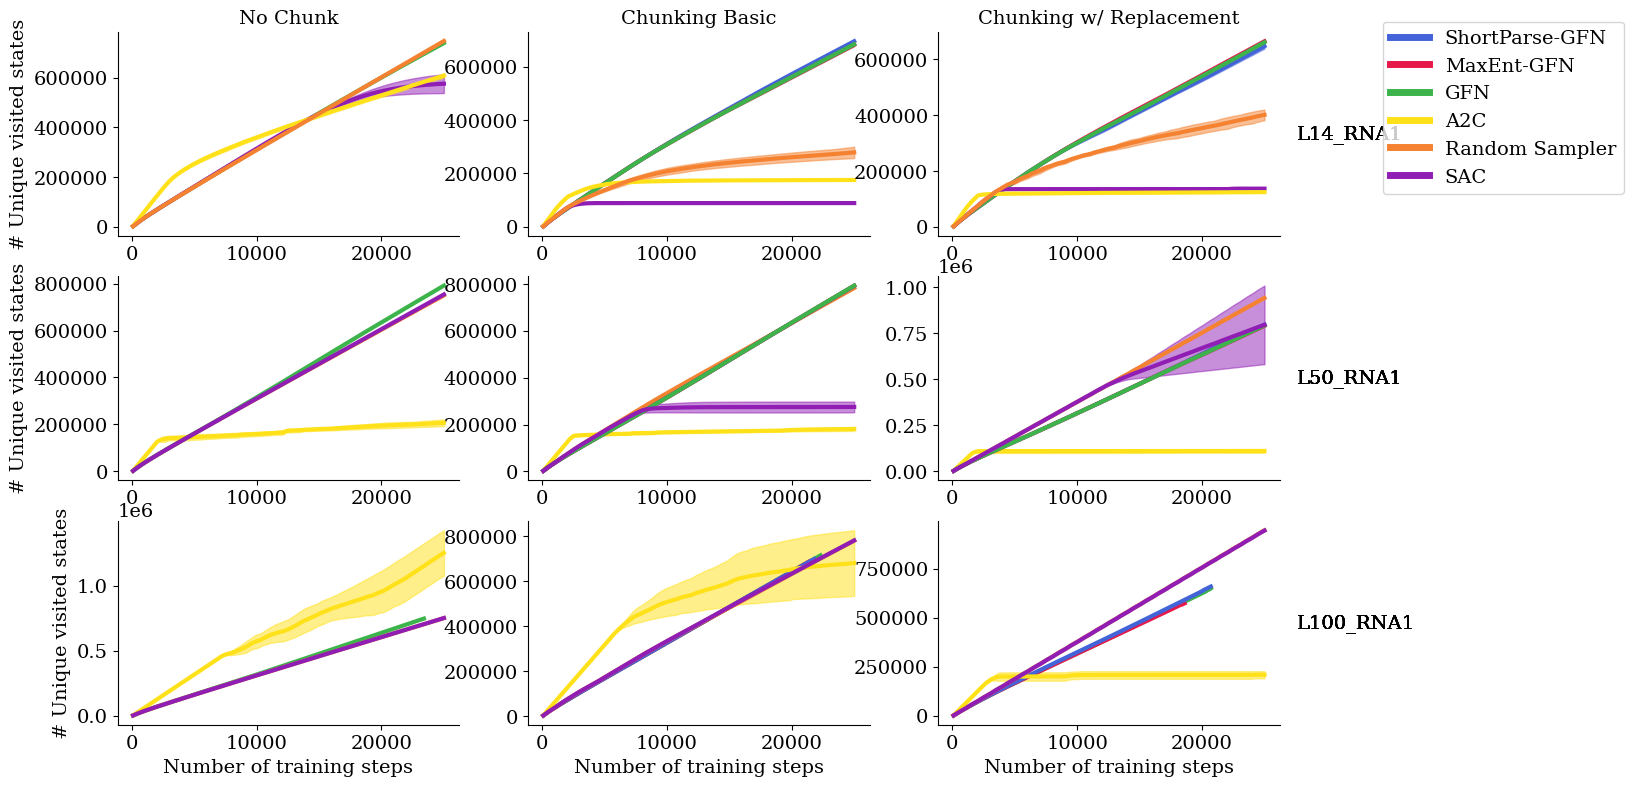

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 9))

chunk_types = [
    "No Chunk",
    "Chunking Basic",
    "Chunking w/ Replacement"
]
tasks = ["L14_RNA1", "L50_RNA1", "L100_RNA1"]
handles = []
lines = []
for i, task in enumerate(tasks):
    for algorithm in experiments[task].keys():
        for j, chunk_type in enumerate(chunk_types):

            if chunk_type in experiments["L14_RNA1"][algorithm]:

                all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/num_visited", *experiments[task][algorithm][chunk_type])


                ax[i,j].plot(all_iterations, mean, label=algorithm, color=algo_colors[algorithm], linewidth=3)
                ax[i,j].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=algo_colors[algorithm], alpha=0.5)

            if i == 0:
                ax[i,j].set_title(chunk_type)

            if i == 2:
                ax[i,j].set_xlabel("Number of training steps")

            if j == 2:
                ax[i,j].text(1.05, 0.5, task, va='center', ha='left', transform=ax[i,j].transAxes)
            if j == 0:
                ax[i,j].set_ylabel("# Unique visited states")


            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)


legend_elements = [Line2D([0], [0], color=algo_colors[algo], lw=5, linestyle='-', label=algo) for algo in algo_colors]

# Create the custom legend
ax[0,2].legend(handles=legend_elements, bbox_to_anchor=(1.3, 1.05), loc='upper left', borderaxespad=0.)


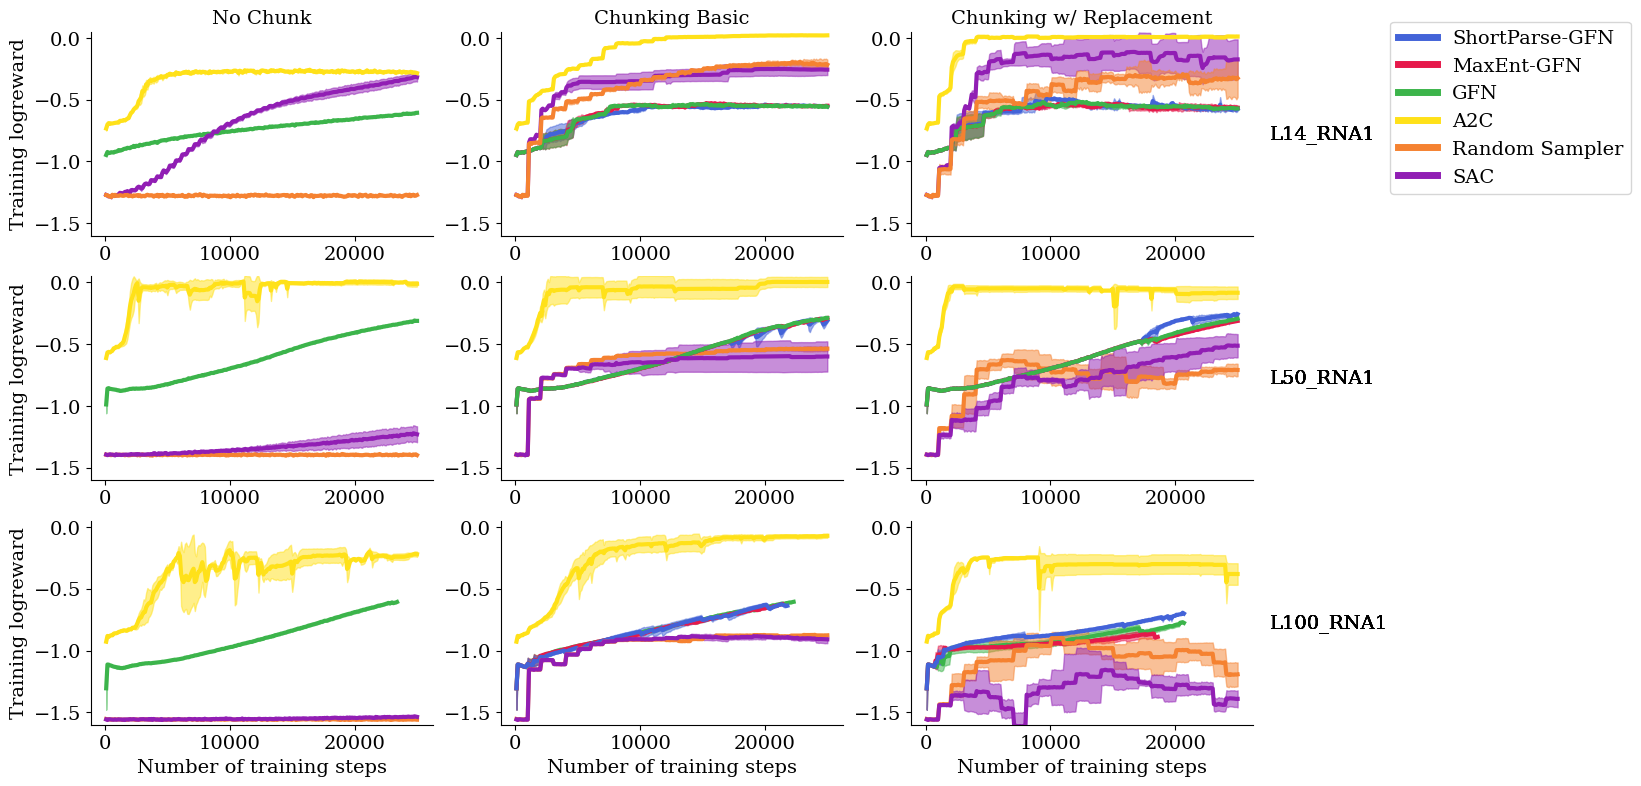

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 9))


chunk_types = [
    "No Chunk",
    "Chunking Basic",
    "Chunking w/ Replacement"
]
tasks = ["L14_RNA1", "L50_RNA1", "L100_RNA1"]
handles = []
lines = []
for i, task in enumerate(tasks):
    for algorithm in experiments[task].keys():
        for j, chunk_type in enumerate(chunk_types):

            if chunk_type in experiments["L14_RNA1"][algorithm]:
                all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/logreward", *experiments[task][algorithm][chunk_type])

                ax[i,j].plot(all_iterations, mean, label=algorithm, color=algo_colors[algorithm], linewidth=3)
                ax[i,j].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=algo_colors[algorithm], alpha=0.5)

            if i == 0:
                ax[i,j].set_title(chunk_type)

            if i == 2:
                ax[i,j].set_xlabel("Number of training steps")

            if j == 2:
                ax[i,j].text(1.05, 0.5, task, va='center', ha='left', transform=ax[i,j].transAxes)
            if j == 0:
                ax[i,j].set_ylabel("Training logreward")


            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)

            ax[i,j].set_ylim(-1.6, 0.05)

legend_elements = [Line2D([0], [0], color=algo_colors[algo], lw=5, linestyle='-', label=algo) for algo in algo_colors]

# Create the custom legend
ax[0,2].legend(handles=legend_elements, bbox_to_anchor=(1.4, 1.05), loc='upper left', borderaxespad=0.)


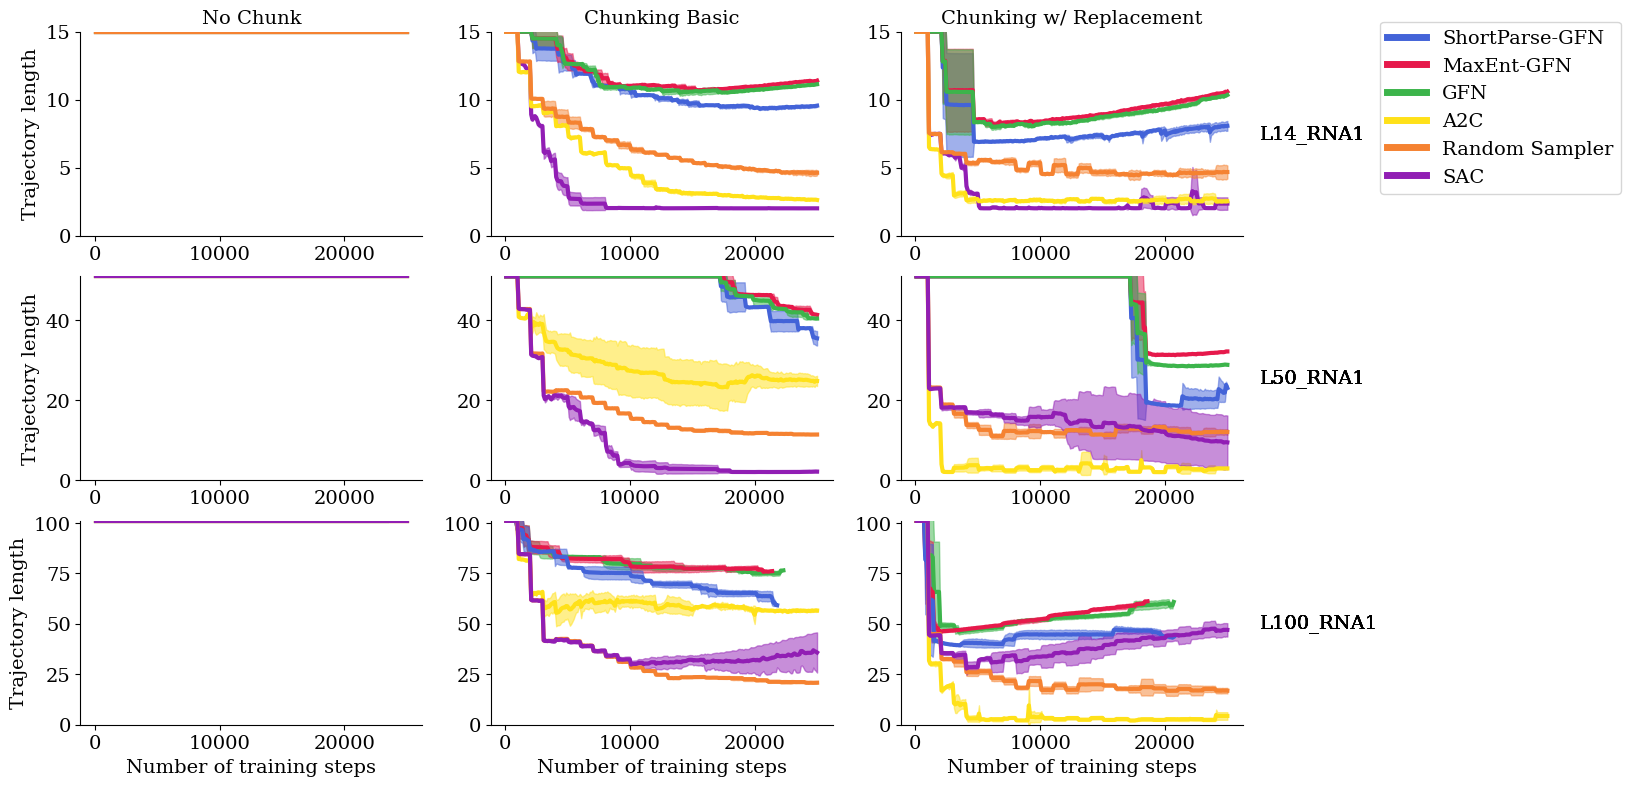

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 9))


chunk_types = [
    "No Chunk",
    "Chunking Basic",
    "Chunking w/ Replacement"
]
tasks = ["L14_RNA1", "L50_RNA1", "L100_RNA1"]
handles = []
lines = []
for i, task in enumerate(tasks):
    for algorithm in experiments[task].keys():
        for j, chunk_type in enumerate(chunk_types):
            if chunk_type in experiments["L14_RNA1"][algorithm]:
                all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/trajectory_length", *experiments[task][algorithm][chunk_type])


                ax[i,j].plot(all_iterations, mean, label=algorithm, color=algo_colors[algorithm], linewidth=3)
                ax[i,j].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=algo_colors[algorithm], alpha=0.5)

            if i == 0:
                ax[i,j].set_title(chunk_type)

            if i == 2:
                ax[i,j].set_xlabel("Number of training steps")

            if j == 2:
                ax[i,j].text(1.05, 0.5, task, va='center', ha='left', transform=ax[i,j].transAxes)
            if j == 0:
                ax[i,j].set_ylabel("Trajectory length")


            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)

            seq_len = int(task.split("_")[0][1:])
            ax[i,j].set_ylim(0, seq_len+1)



legend_elements = [Line2D([0], [0], color=algo_colors[algo], lw=5, linestyle='-', label=algo) for algo in algo_colors]


# Create the custom legend
ax[0,2].legend(handles=legend_elements, bbox_to_anchor=(1.4, 1.05), loc='upper left', borderaxespad=0.)


# Analysis of the sampler

In [5]:
def sample_trajectories(n_trajectories, sampler, env):
    with torch.no_grad():
        batch_size=n_trajectories
        s0 = env.s0.to(sampler.device)
        state = repeat(s0, " ... -> b ...", b=batch_size)
        bs = state.shape[0]

        # Start unrolling the trajectories
        actions = []
        trajectories = []
        dones = []
        done = torch.zeros((bs)).to(state).bool()
        trajectory_length = (
            torch.zeros((bs)).to(state).long()
        )  # This tracks the length of trajetcory for each sample in the batch
        while not done.all():
            logits_pf = get_forward_logits(state, sampler, env)
            valid_actions_mask = env.get_forward_mask(state)

            logits_pf = torch.where(
                valid_actions_mask,
                logits_pf,
                torch.tensor(-1e20).to(logits_pf),
            )


            cat = Categorical(logits=logits_pf)

            act = cat.sample()

            new_state, done = env.forward_step(state, act)
            trajectory_length += ~done  # Increment the length of the trajectory for each sample in the batch as long it's not done.

            actions.append(act)
            trajectories.append(state)
            dones.append(done.clone())

            state = new_state.clone()

        logreward = env.compute_logreward(state).to(
                state.device
        )
        trajectories.append(state)
        dones.append(torch.ones((bs)).to(state).bool())
        trajectories = torch.stack(trajectories, dim=1)
        actions = torch.stack(actions, dim=1)
        dones = torch.stack(dones, dim=1)

    return logreward, state, trajectories, dones, actions

### L14_RNA1

In [ ]:
logrewards = Dict()
avg_top100_distance = Dict()
avg_top100 = Dict()
modules = {
    "ShortParse-GFN": TBGFN,
    "MaxEnt-GFN": TBGFN,
    "GFN": TBGFN,
    "A2C": A2C,
    "SAC": SAC,
    "Random Sampler": RandomSampler
}
for algo in tqdm(experiments["L14_RNA1"]):
    for chunk_type in experiments["L14_RNA1"][algo]:
        run_id = experiments["L14_RNA1"][algo][chunk_type][0]["id"]

        sampler = modules[algo].load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        env = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        env.action_len = env.action_len.long()
        logreward, final_state, _, _, _ = sample_trajectories(10000, sampler, env)
        logreward = logreward.cpu()


        top100 = torch.topk(logreward, k=100)
        final_state = final_state[top100.indices].cpu()

        state_strings = [s.replace(env.exit_action, "") for s in env.to_strings(final_state)]

        c = 0
        avg_top100_distance[algo][chunk_type] = 0
        for i in range(len(state_strings)):
            for j in range(i+1, len(state_strings)):
                avg_top100_distance[algo][chunk_type] += levenshtein(state_strings[i], state_strings[j])
                c +=1

        avg_top100_distance[algo][chunk_type] = avg_top100_distance[algo][chunk_type] / c
        logrewards[algo][chunk_type] = logreward
        avg_top100[algo][chunk_type] = top100.values.cpu().exp().mean()

  0%|          | 0/6 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_embedder'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'backward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/

/tmp/ipykernel_3643425/1456521824.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))
/tmp/ipykernel_3643425/1456521824.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


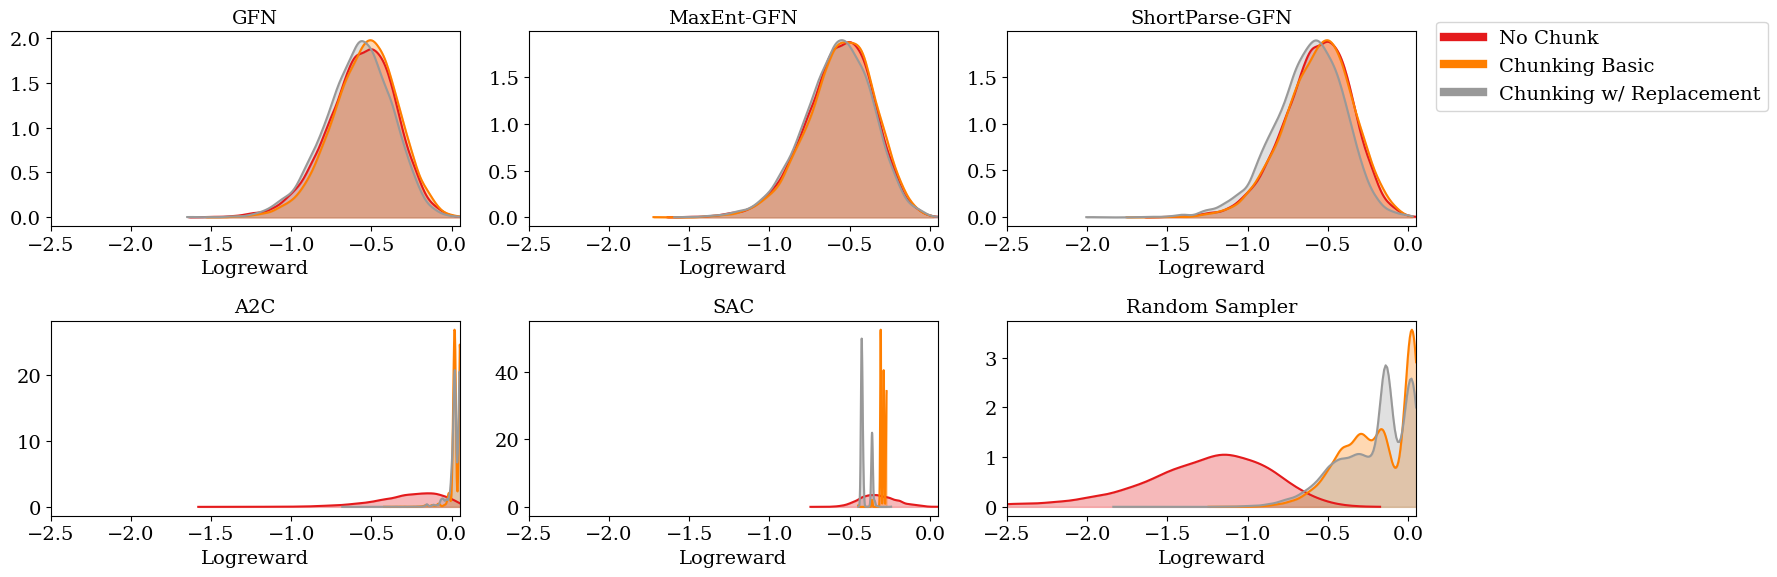

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(18,6))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))
for i, algo in enumerate(["GFN", "MaxEnt-GFN", "ShortParse-GFN", "A2C", "SAC", "Random Sampler"]):
    for j, chunk_type in enumerate(["No Chunk", 'Chunking Basic', "Chunking w/ Replacement"]):

        if chunk_type == "No Chunk" and "GFN" in algo:
            data = logrewards["GFN"]["No Chunk"]
        else:
            data = logrewards[algo][chunk_type]
        # Calculate the KDE
        try:
            kde = stats.gaussian_kde(data)
            x_range = np.linspace(min(data), max(data), 200)
            y_kde = kde(x_range)

            # Plot the KDE
            ax[i//3,i%3].plot(x_range, y_kde, label=chunk_type, color=colors[j])
            ax[i//3,i%3].fill_between(x_range, y_kde, alpha=0.3, color=colors[j])
        except:
            pass

    ax[i//3,i%3].set_xlim(-2.5,0.05)
    if i == 2:
        legend = ax[i//3,i%3].legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
        for handle in legend.legendHandles:
            handle.set_linewidth(6)
    ax[i//3,i%3].set_title(algo)
    ax[i//3,i%3].set_xlabel("Logreward")
fig.tight_layout()
plt.show()

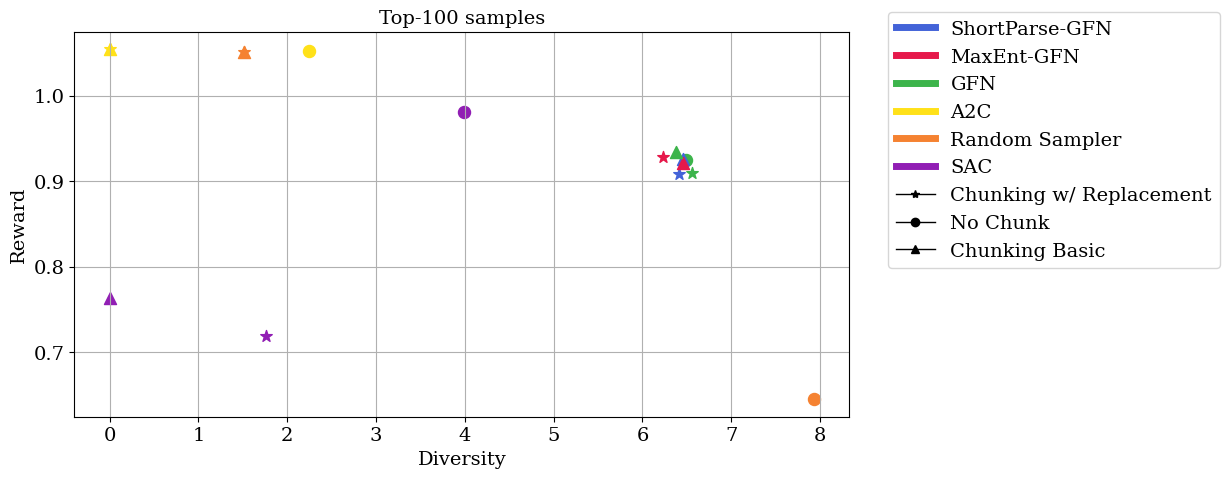

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
markers = {
    "Chunking w/ Replacement": "*",
    "No Chunk": "o",
    "Chunking Basic": "^"
}
for i, chunk_type in enumerate(markers.keys()):
    for j, algo in enumerate(logrewards.keys()):
        if chunk_type in avg_top100_distance[algo]:
            ax.scatter(avg_top100_distance[algo][chunk_type], avg_top100[algo][chunk_type], s=75, color=algo_colors[algo], marker=markers[chunk_type])

    # if i == 0:
    #    for algo in logrewards.keys():
    #        ax.annotate(
    #            algo,
    #            (avg_top100_distance[algo][chunk_type], avg_top100[algo][chunk_type]),
    #            xytext=(5, 5),
    #            textcoords='offset points')


legend_elements = [Line2D([0], [0], color=algo_colors[algo], lw=5, linestyle='-', label=algo) for algo in algo_colors] + [
    Line2D([0], [0], color='black', lw=1, marker='*', label='Chunking w/ Replacement'),
    Line2D([0], [0], color='black', lw=1, marker='o', label='No Chunk'),
    Line2D([0], [0], color='black', lw=1, marker='^', label='Chunking Basic')
]

# Create the custom legend
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


ax.set_xlabel("Diversity")
ax.set_ylabel("Reward")
ax.set_title("Top-100 samples")
ax.grid()
plt.show()

In [6]:
def go_backward(final_state: torch.Tensor, sampler, env):
    """Sample backward trajectories conditioned on inputs.
    Args:
        final_state (torch.Tensor[batch_size, *state_shape]): Final state.
    Return:
        trajectories (torch.Tensor[batch_size, trajectory_length, *state_shape]): Trajectories for each sample in the batch.
        actions (torch.Tensor[batch_size, trajectory_length]): Actions for each sample in the batch.
        dones (torch.Tensor[batch_size, trajectory_length]): Whether the trajectory is done or not.
        state (torch.Tensor[batch_size, *state_shape]): Final state.
    """
    bs = final_state.shape[0]
    device = final_state.device
    state = final_state.clone()
    done = torch.zeros((bs), device=device, dtype=bool)

    # Start unrolling the trajectories
    actions = []
    trajectories = []
    dones = []
    dones.append(torch.ones((bs), device=device, dtype=bool))
    while not done.all():
        logit_pb = get_backward_logits(state, sampler, env)
        backward_mask = env.get_backward_mask(state)
        logit_pb = torch.where(
            backward_mask,
            logit_pb,
            torch.tensor(-1e20, device=device),
        )

        # When no action is available, just fill with uniform because
        # it won't be picked anyway in the backward_step.
        # Doing this avoids having nan when computing probabilities
        logit_pb = torch.where(
            (logit_pb == -torch.inf).all(dim=-1).unsqueeze(1),
            torch.tensor(0.0),
            logit_pb,
        )
        cat = Categorical(logits=logit_pb)

        act = cat.sample()

        new_state, done = env.backward_step(state, act)

        actions.append(act)
        trajectories.append(state)
        dones.append(done.clone())

        state = new_state.clone()

    trajectories.append(state)

    trajectories = torch.stack(trajectories[::-1], dim=1)
    actions = torch.stack(actions[::-1], dim=1)
    dones = torch.stack(dones[::-1], dim=1)

    return trajectories, actions, dones, final_state

@torch.no_grad
def get_ll(final_state: torch.Tensor, logreward: torch.Tensor, sampler, env, n_trajectories) -> torch.Tensor:
        """Get the log likelihood of the model for the given trajectories.
        Args:
            final_state (torch.Tensor[batch_size, *state_shape]): The examples for which we're computing the log-likelihood.
            logreward (torch.Tensor[batch_size]): Log reward.
        Return:
            log_pT (torch.Tensor[batch_size]): Log likelihood.
            trajectories (torch.Tensor[batch_size*n_trajectories, trajectory_length, *state_shape]): Trajectories for each sample in the batch.
            actions (torch.Tensor[batch_size*n_trajectories, trajectory_length]): Actions for each sample in the batch.
            dones (torch.Tensor[batch_size*n_trajectories, trajectory_length]): Whether the trajectory is done or not.
            logreward (torch.Tensor[batch_size*n_trajectories]): Log reward.
        """
        unique_final_state = final_state
        bs = unique_final_state.shape[0]
        device = final_state.device
        # Repeat the final_state n_trajectories times
        final_state = repeat(
            final_state, "b ... -> b n ...", n=n_trajectories
        )
        final_state = rearrange(final_state, "b n ... -> (b n) ...")
        logreward = repeat(logreward, "b -> b n", n=n_trajectories)
        logreward = rearrange(logreward, "b n ... -> (b n) ... ")
        trajectories, actions, dones, final_state = go_backward(final_state, sampler, env)

        # Calculate the log likelihood
        log_pf = 0
        log_pb = 0

        for t in range(trajectories.shape[1]):
            state = trajectories[:, t]
            logit_pf = get_forward_logits(state, sampler, env)
            forward_mask = env.get_forward_mask(state)
            logit_pf = torch.where(
                forward_mask,
                logit_pf,
                torch.tensor(-1e20, device=device),
            )

            if t < trajectories.shape[1] - 1:
                log_pf += (Categorical(logits=logit_pf).log_prob(actions[:, t])) * (
                    ~dones[:, t] + 0
                )

            if t > 0:
                logit_pb = get_backward_logits(state, sampler, env)
                backward_mask = env.get_backward_mask(state)

                logit_pb = torch.where(
                    backward_mask,
                    logit_pb,
                    torch.tensor(-1e20, device=device),
                )

                # When no action is available, just fill with uniform because
                # it won't be picked anyway in the backward_step.
                # Doing this avoids having nan when computing probabilities
                logit_pb = torch.where(
                    (logit_pb == -torch.inf).all(dim=-1).unsqueeze(1),
                    torch.tensor(0.0),
                    logit_pb,
                )
                log_pb += torch.where(
                    dones[:, t] | env.is_initial_state(state),
                    torch.tensor(0.0),
                    Categorical(logits=logit_pb).log_prob(actions[:, t - 1]),
                )

        log_pb = rearrange(log_pb, "(b n) ... -> b n ...", b=bs).to(final_state.device)
        log_pf = rearrange(log_pf, "(b n) ... -> b n ...", b=bs)
        logreward = rearrange(logreward, "(b n) ... -> b n ...", b=bs)

        assert log_pf.shape == log_pb.shape
        log_pT = torch.logsumexp(log_pf - log_pb, dim=1) - torch.log(
            torch.tensor(n_trajectories)
        )

        return log_pT, log_pf, log_pb, logreward

In [ ]:
logp_Ts = Dict()
losses = Dict()
logrs = Dict()
number_of_trajectories = {
    "No Chunk": 1,
    "Chunking Basic": 10,
    "Chunking w/ Replacement": 10
}
for algo in ["GFN", "ShortParse-GFN", "MaxEnt-GFN"]:
    for chunk_type in tqdm(["No Chunk", "Chunking Basic", "Chunking w/ Replacement"]):
        if algo != "GFN" and chunk_type == "No Chunk":
            run_id = experiments["L14_RNA1"]["GFN"][chunk_type][0]["id"]
        else:
            run_id = experiments["L14_RNA1"][algo][chunk_type][0]["id"]

        sampler = TBGFN.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        env = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        env.action_len = env.action_len.long()
        sampler.forward_policy.set_environment(env)
        sampler.backward_policy.set_environment(env)

        val_sequences = env.data_val.sequences.to(sampler.device)
        val_logr, idx = env.data_val.logrewards.to(sampler.device).sort()
        val_sequences = val_sequences[idx]

        log_pT, log_pf, log_pb, logr = get_ll(val_sequences, val_logr, sampler, env, number_of_trajectories[chunk_type])

        log_pf = rearrange(log_pf, "b n ... -> (b n) ...")
        log_pb = rearrange(log_pb, "b n ... -> (b n) ...")
        logr = rearrange(logr, "b n ... -> (b n) ...")

        losses_ = (sampler.logZ+log_pf - log_pb - logr/sampler.hparams.reward_temperature)**2
        losses_ = losses_.detach().cpu()

        logp_Ts[algo][chunk_type] = log_pT.cpu()
        losses[algo][chunk_type] = losses_.cpu()
        logrs[algo][chunk_type] = logr.cpu()

  0%|          | 0/3 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_embedder'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'backward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_3643425/2029721179.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(losses)))


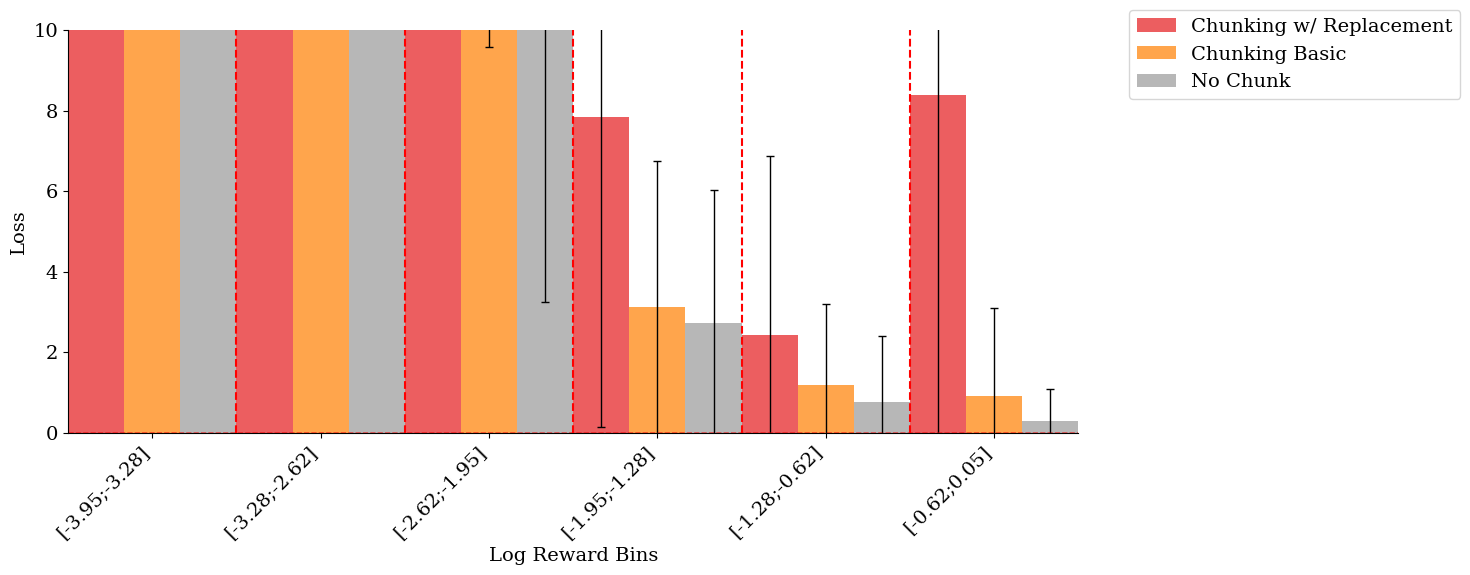

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
n_bins = 6
gs = fig.add_gridspec(1, 1)

colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(losses)))

# Define error bar styles
error_bar_styles = {
        'ecolor': 'black',        # Error bar color
        'elinewidth': 1,          # Error bar line width
        'capsize': 3,             # Cap size for error bars
        'capthick': 1             # Cap thickness for error bars
    }


for i, chunk_type in enumerate(["Chunking w/ Replacement", "Chunking Basic", "No Chunk"]):
    loss = losses["ShortParse-GFN"][chunk_type]
    logr = logrs["ShortParse-GFN"][chunk_type]

    bins = np.linspace(logr.min().cpu(), logr.max().cpu(), n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bar_width = (bin_centers[1] - bin_centers[0]) / (len(losses))
    digitized = np.digitize(logr.cpu(), bins)

    bin_means = [loss[digitized == i].mean() for i in range(1, len(bins))]
    bin_stds = [loss[digitized == i].std() for i in range(1, len(bins))]

    # Plot loss bar plot
    bar_width = np.diff(bins)[0] / (len(losses) )
    x = bins[:-1] + i * bar_width
    bars = ax.bar(x, bin_means, yerr=bin_stds, width=bar_width, align="edge",
                        alpha=0.7, color=colors[i], label=chunk_type, error_kw=error_bar_styles)



    ax.set_xlabel('Log Reward Bins')
    ax.set_ylabel('Loss')
    ax.axhline(y=0, color='r', linestyle='--', linewidth=1)
    ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)

    # Align x-axis of correlation plot with scatter plots
    ax.set_xlim(bins[0], bins[-1])

    # Set x-ticks to show bin ranges
    ax.set_xticks(bins[:-1] + np.diff(bins)[0] / 2)
    ax.set_xticklabels([f'[{bins[i]:.2f};{bins[i+1]:.2f}]' for i in range(len(bins)-1)],
                            rotation=45, ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 10)

ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
# Draw dashed lines between bins
dashed_ax =  fig.add_subplot(gs[:, :], sharex = ax)
dashed_ax.patch.set_alpha(0)
dashed_ax.axis("off")
# plot the vertical line
for i in range(n_bins-1):
    dashed_ax.axvline(bins[i+1], c='r', ls='--')
fig.tight_layout()
plt.show()

In [ ]:
from scipy import stats

def generate_sample_data(n_samples=1000, n_models=3):
    """Generate sample data for multiple models."""
    rewards = np.random.uniform(0, 10, n_samples)
    other_quantities = {
        f'Model {i+1}': rewards * np.sin(rewards + i) + np.random.normal(0, 2, n_samples)
        for i in range(n_models)
    }
    return rewards, other_quantities

def compute_correlation(x, y):
    """Compute Pearson correlation coefficient."""
    return stats.pearsonr(x, y)[0]

def plot_scatter_and_correlation_per_reward_bin(rewards, other_quantities, models, n_bins=5):
    """Plot aligned side-by-side scatter plots and multi-model correlation bar plot for each reward bin."""
    bins = np.linspace(rewards.min(), rewards.max(), n_bins + 1)
    digitized = np.digitize(rewards, bins)

    colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(models)))

    correlations = {model: [] for model in models}
    for i in range(1, len(bins)):
        mask = digitized == i
        for model in models:
            if np.sum(mask) > 2:
                corr = compute_correlation(rewards[mask], other_quantities[model][mask])
            else:
                corr = np.nan
            correlations[model].append(corr)

    # Create subplots: n_bins for scatter plots in one row, 1 for correlation bar plot
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, n_bins, height_ratios=[3, 1], hspace=0.3, wspace=0.05)

    scatter_axs = [fig.add_subplot(gs[0, i]) for i in range(n_bins)]
    corr_ax = fig.add_subplot(gs[1, :])

    fig.suptitle('Scatter Plots and Correlations per Reward Bin for Multiple Models', fontsize=16)

    # Plot scatter plots
    for i, ax in enumerate(scatter_axs):
        mask = digitized == i + 1
        for j, model in enumerate(models):
            ax.scatter(rewards[mask], other_quantities[model][mask], alpha=0.5, color=colors[j], label=model if i == 0 else "")
        ax.set_xlim(bins[i], bins[i+1])
        ax.set_ylim(min(q.min() for q in other_quantities.values()),
                    max(q.max() for q in other_quantities.values()))
        if i == 0:
            ax.set_ylabel('$\log{p^T}$')
        if i > 0:
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
        if i < n_bins - 1:
            ax.spines['right'].set_visible(False)

        ax.spines["bottom"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_xticks([])

    # Plot correlation bar plot
    bar_width = np.diff(bins)[0] / (len(models))
    for j, model in enumerate(models):
        x = bins[:-1] + j * bar_width
        bars = corr_ax.bar(x, correlations[model], width=bar_width, align="edge",
                           alpha=0.7, color=colors[j], label=model)


    corr_ax.set_xlabel('Log Reward Bins')
    corr_ax.set_ylabel('Correlation')
    corr_ax.set_ylim(-1.1, 1.1)
    corr_ax.axhline(y=0, color='r', linestyle='--', linewidth=1)
    corr_ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)

    # Align x-axis of correlation plot with scatter plots
    corr_ax.set_xlim(bins[0], bins[-1])

    # Set x-ticks to show bin ranges
    corr_ax.set_xticks(bins[:-1] + np.diff(bins)[0] / 2)
    corr_ax.set_xticklabels([f'[{bins[i]:.2f};{bins[i+1]:.2f}]' for i in range(len(bins)-1)],
                            rotation=45, ha='right')
    corr_ax.spines['top'].set_visible(False)


    # Draw dashed lines between bins
    dashed_ax =  fig.add_subplot(gs[:, :], sharex = corr_ax)
    dashed_ax.patch.set_alpha(0)
    dashed_ax.axis("off")
    # plot the vertical line
    for i in range(n_bins-1):
        dashed_ax.axvline(bins[i+1], c='r', ls='--')

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3643425/3230055292.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(models)))
/tmp/ipykernel_3643425/3230055292.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


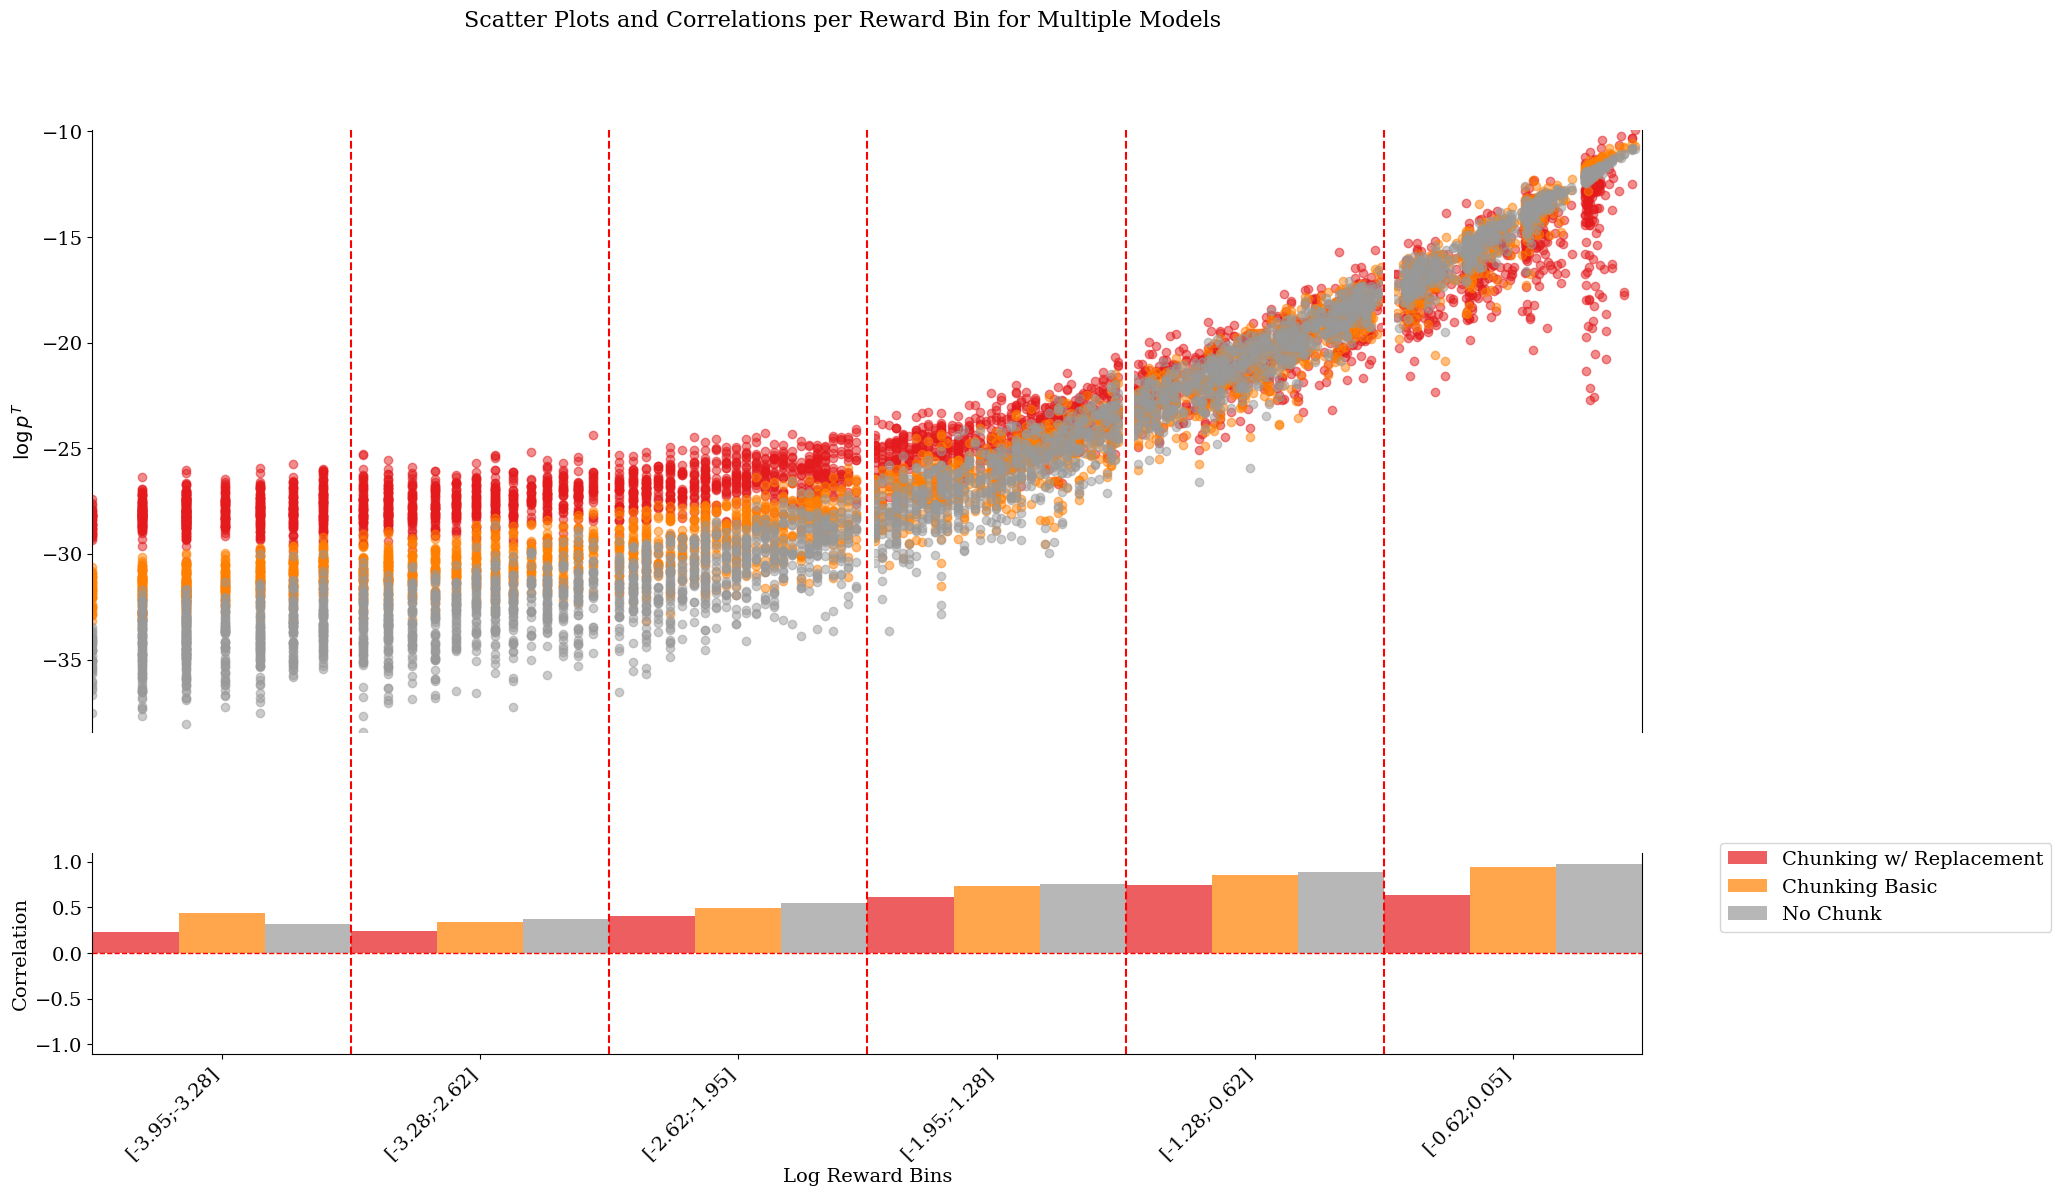

In [54]:
plot_scatter_and_correlation_per_reward_bin(logrs["ShortParse-GFN"]["No Chunk"], logp_Ts["ShortParse-GFN"], ["Chunking w/ Replacement", "Chunking Basic", "No Chunk"], n_bins=6)

### L50_RNA1

In [ ]:
logrewards = Dict()
avg_top100_distance = Dict()
avg_top100 = Dict()
modules = {
    "ShortParse-GFN": TBGFN,
    "MaxEnt-GFN": TBGFN,
    "GFN": TBGFN,
    "A2C": A2C,
    "SAC": SAC,
    "Random Sampler": RandomSampler
}
for algo in tqdm(experiments["L50_RNA1"]):
    for chunk_type in experiments["L50_RNA1"][algo]:
        run_id = experiments["L50_RNA1"][algo][chunk_type][0]["id"]

        sampler = modules[algo].load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        env = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        logreward, final_state, _, _, _ = sample_trajectories(10000, sampler, env)
        logreward = logreward.cpu()

        top100 = torch.topk(logreward, k=100)
        final_state = final_state[top100.indices].cpu()

        state_strings = [s.replace(env.exit_action, "") for s in env.to_strings(final_state)]

        c = 0
        avg_top100_distance[algo][chunk_type] = 0
        for i in range(len(state_strings)):
            for j in range(i+1, len(state_strings)):
                avg_top100_distance[algo][chunk_type] += levenshtein(state_strings[i], state_strings[j])
                c +=1

        avg_top100_distance[algo][chunk_type] = avg_top100_distance[algo][chunk_type] / c

        logrewards[algo][chunk_type] = logreward
        avg_top100[algo][chunk_type] = top100.values.cpu().exp().mean()

  0%|          | 0/6 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_embedder'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'critic' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['critic'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/sit

/tmp/ipykernel_3767542/1456521824.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))
/tmp/ipykernel_3767542/1456521824.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


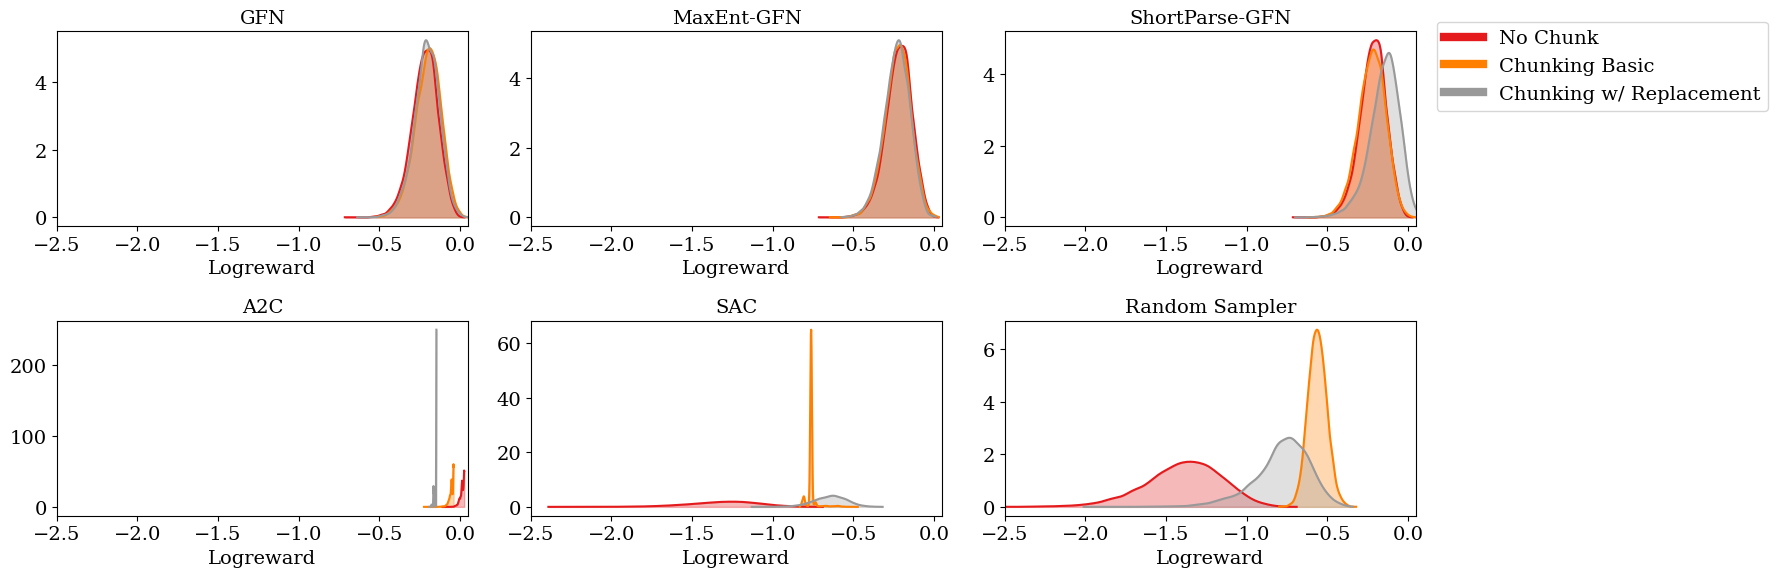

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(18,6))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))
for i, algo in enumerate(["GFN", "MaxEnt-GFN", "ShortParse-GFN", "A2C", "SAC", "Random Sampler"]):
    for j, chunk_type in enumerate(["No Chunk", 'Chunking Basic', "Chunking w/ Replacement"]):

        if chunk_type == "No Chunk" and "GFN" in algo:
            data = logrewards["GFN"]["No Chunk"]
        else:
            data = logrewards[algo][chunk_type]
        # Calculate the KDE
        try:
            kde = stats.gaussian_kde(data)
            x_range = np.linspace(min(data), max(data), 200)
            y_kde = kde(x_range)

            # Plot the KDE
            ax[i//3,i%3].plot(x_range, y_kde, label=chunk_type, color=colors[j])
            ax[i//3,i%3].fill_between(x_range, y_kde, alpha=0.3, color=colors[j])
        except:
            pass

    ax[i//3,i%3].set_xlim(-2.5,0.05)
    if i == 2:
        legend = ax[i//3,i%3].legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
        for handle in legend.legendHandles:
            handle.set_linewidth(6)
    ax[i//3,i%3].set_title(algo)
    ax[i//3,i%3].set_xlabel("Logreward")
fig.tight_layout()
plt.show()

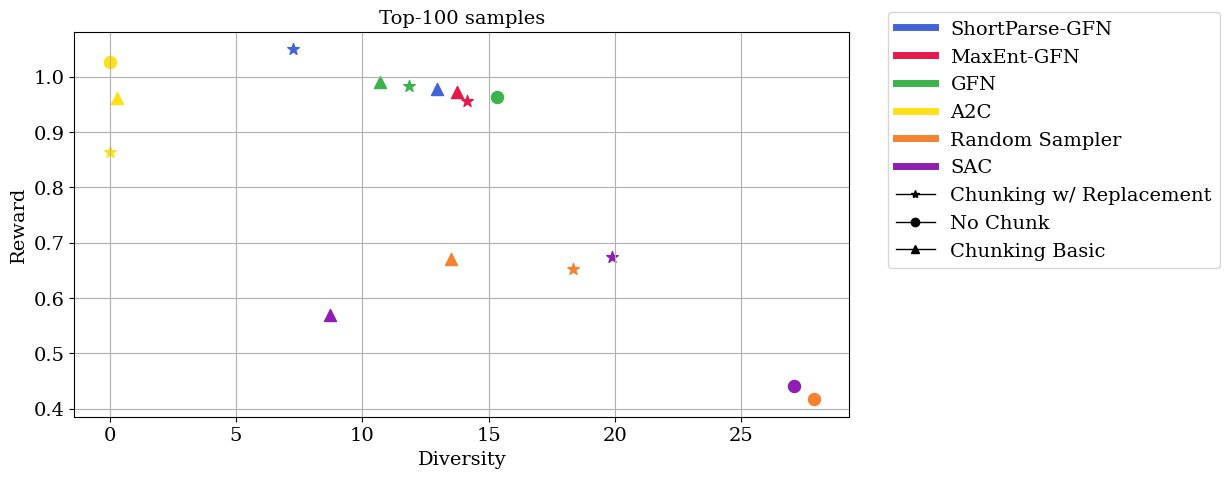

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
markers = {
    "Chunking w/ Replacement": "*",
    "No Chunk": "o",
    "Chunking Basic": "^"
}
for i, chunk_type in enumerate(markers.keys()):
    for j, algo in enumerate(logrewards.keys()):
        if chunk_type in avg_top100_distance[algo]:
            ax.scatter(avg_top100_distance[algo][chunk_type], avg_top100[algo][chunk_type], s=75, color=algo_colors[algo], marker=markers[chunk_type])

    # if i == 0:
    #    for algo in logrewards.keys():
    #        ax.annotate(
    #            algo,
    #            (avg_top100_distance[algo][chunk_type], avg_top100[algo][chunk_type]),
    #            xytext=(5, 5),
    #            textcoords='offset points')


legend_elements = [Line2D([0], [0], color=algo_colors[algo], lw=5, linestyle='-', label=algo) for algo in algo_colors] + [
    Line2D([0], [0], color='black', lw=1, marker='*', label='Chunking w/ Replacement'),
    Line2D([0], [0], color='black', lw=1, marker='o', label='No Chunk'),
    Line2D([0], [0], color='black', lw=1, marker='^', label='Chunking Basic')
]

# Create the custom legend
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


ax.set_xlabel("Diversity")
ax.set_ylabel("Reward")
ax.set_title("Top-100 samples")
ax.grid()
plt.show()

In [7]:
rna_50_modes = Dict()
modules = {
    "ShortParse-GFN": TBGFN,
    "MaxEnt-GFN": TBGFN,
    "GFN": TBGFN,
    "A2C": A2C,
    "SAC": SAC,
    "Random Sampler": RandomSampler
}
for algo in tqdm(experiments["L50_RNA1"]):
    for chunk_type in experiments["L50_RNA1"][algo]:
        rna_50_modes[algo][chunk_type] = []
        for i in range(3):
            run_id = experiments["L50_RNA1"][algo][chunk_type][i]["id"]

            env = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
            rna_50_modes[algo][chunk_type].append(env.high_reward_strings)

  0%|          | 0/7 [00:00<?, ?it/s]

: 

In [64]:
num_final_modes = Dict()
for algo in tqdm(experiments["L50_RNA1"]):
    for chunk_type in experiments["L50_RNA1"][algo]:
        num_fn_modes = []
        for i in range(3):
            modes_ = rna_50_modes[algo][chunk_type][i]
            final_modes = []
            for mode in modes_:
                if len(final_modes) == 0:
                    final_modes.append(mode)
                else:
                    lv_dst = min([levenshtein(mode, m) for m in final_modes])
                    if lv_dst >= 5:
                        final_modes.append(mode)
            num_fn_modes.append(len(final_modes))
        num_final_modes[algo][chunk_type] = f"{round(np.mean(num_fn_modes), 2)} ({round(np.std(num_fn_modes), 2)})"

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
num_final_modes

{'A2C': {'Chunking w/ Replacement': '7.33 (2.49)',
  'No Chunk': '24.67 (2.36)',
  'Chunking Basic': '12.67 (3.68)'},
 'Random Sampler': {'Chunking w/ Replacement': '0.0 (0.0)',
  'Chunking Basic': '0.0 (0.0)',
  'No Chunk': '0.0 (0.0)'},
 'ShortParse-GFN': {'Chunking w/ Replacement': '656.67 (51.06)',
  'Chunking Basic': '361.0 (40.57)'},
 'MaxEnt-GFN': {'Chunking w/ Replacement': '213.0 (10.2)',
  'Chunking Basic': '357.33 (10.21)'},
 'GFN': {'Chunking w/ Replacement': '294.0 (16.87)',
  'Chunking Basic': '403.33 (11.59)',
  'No Chunk': '292.0 (10.2)'},
 'SAC': {'Chunking Basic': '0.0 (0.0)',
  'No Chunk': '0.0 (0.0)',
  'Chunking w/ Replacement': '0.0 (0.0)'}}

In [54]:
len(final_modes)

33

#### Beta effect

In [ ]:
api = wandb.Api()
runs = api.runs(path="yoshua-bengio/gfn-chunking", filters={"config.task_name": "rna_binding", "tags": "beta_effect"})
columns = ["_step", 'train/num_modes', 'train/num_visited', 'train/logreward', 'train/trajectory_length', 'trainer/global_step', "epoch"]

# Group runs by algorithm and then length
experiments_beta = Dict()
for run in tqdm(runs):
    name = run.name
    history = run.scan_history(keys=columns)
    summary = {}
    for row in history:
        for key in row.keys():
            if key not in summary:
                summary[key] = []
            summary[key].append(row[key])
    summary["id"] = run.id
    config = run.config

    beta = str(1/config["algo"]["reward_temperature"])


    if "chunk" not in name:
        chunk_type = "No Chunk"
    elif "chunk_replacement" in name:
        chunk_type = "Chunking w/ Replacement"
    elif "chunk" in name:
        chunk_type = "Chunking Basic"

    if len(experiments_beta[chunk_type][beta]) == 0:
        experiments_beta[chunk_type][beta] = [summary]
    else:
        experiments_beta[chunk_type][beta].append(summary)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
logrewards = Dict()
avg_top100_distance = Dict()
avg_top100 = Dict()

for chunk_type in tqdm(experiments_beta):
    for beta in experiments_beta[chunk_type]:
        run_id = experiments_beta[chunk_type][beta][0]["id"]

        sampler = TBGFN.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        env = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        logreward, final_state, _, _, _ = sample_trajectories(10000, sampler, env)
        logreward = logreward.cpu()

        top100 = torch.topk(logreward, k=100)
        final_state = final_state[top100.indices].cpu()

        state_strings = [s.replace(env.exit_action, "") for s in env.to_strings(final_state)]

        c = 0
        avg_top100_distance[chunk_type][beta] = 0
        for i in range(len(state_strings)):
            for j in range(i+1, len(state_strings)):
                avg_top100_distance[chunk_type][beta] += levenshtein(state_strings[i], state_strings[j])
                c +=1
        avg_top100_distance[chunk_type][beta] = avg_top100_distance[chunk_type][beta]/c

        avg_top100[chunk_type][beta] = top100.values.cpu().exp().mean()

  0%|          | 0/3 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_embedder'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'backward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/

/tmp/ipykernel_1553936/1774110476.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('inferno')


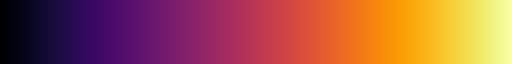

In [16]:
plt.cm.get_cmap('inferno')

/tmp/ipykernel_1553936/191814246.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('inferno')(np.linspace(0, 1, 4))


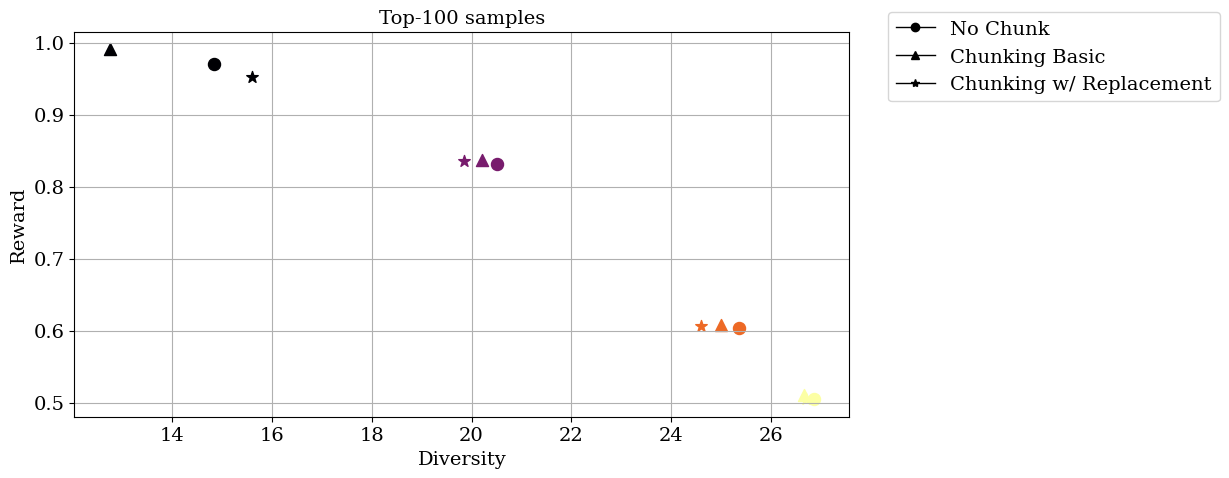

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
markers = {
    "Chunking w/ Replacement": "*",
    "No Chunk": "o",
    "Chunking Basic": "^"
}
colors = plt.cm.get_cmap('inferno')(np.linspace(0, 1, 4))

for i, chunk_type in enumerate(markers.keys()):
    for j, beta in enumerate(experiments_beta["Chunking Basic"].keys()):

        ax.scatter(avg_top100_distance[chunk_type][beta], avg_top100[chunk_type][beta], s=75, color=colors[j], marker=markers[chunk_type])



legend_elements = [
    Line2D([0], [0], color='black', lw=1, marker='o', label='No Chunk'),
    Line2D([0], [0], color='black', lw=1, marker='^', label='Chunking Basic'),
    Line2D([0], [0], color='black', lw=1, marker='*', label='Chunking w/ Replacement')
]

# Create the custom legend
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


ax.set_xlabel("Diversity")
ax.set_ylabel("Reward")
ax.set_title("Top-100 samples")
ax.grid()
plt.show()

### L100_RNA1

In [ ]:
logrewards = Dict()
avg_top100_distance = Dict()
avg_top100 = Dict()
modules = {
    "GFN": TBGFN,
    "A2C": A2C,
    "Random Sampler": RandomSampler
}
for algo in tqdm(experiments["L100_RNA1"]):
    for chunk_type in experiments["L100_RNA1"][algo]:
        run_id = experiments["L100_RNA1"][algo][chunk_type][0]["id"]

        sampler = modules[algo].load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        env = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        logreward, final_state, _, _, _ = sample_trajectories(10000, sampler, env)
        logreward = logreward.cpu()

        top100 = torch.topk(logreward, k=100)
        final_state = final_state[top100.indices].cpu()

        state_strings = [s.replace(env.exit_action, "") for s in env.to_strings(final_state)]

        c = 0
        avg_top100_distance[algo][chunk_type] = 0
        for i in range(len(state_strings)):
            for j in range(i+1, len(state_strings)):
                avg_top100_distance[algo][chunk_type] += levenshtein(state_strings[i], state_strings[j])
                c +=1

        avg_top100_distance[algo][chunk_type] = avg_top100_distance[algo][chunk_type] / c
        logrewards[algo][chunk_type] = logreward
        avg_top100[algo][chunk_type] = top100.values.cpu().exp().mean()

  0%|          | 0/3 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'forward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'action_embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['action_embedder'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'backward_policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backward_policy'])`.
/home/mila/o/oussama.boussif/venvs/ai_scientist/

/tmp/ipykernel_966320/1960443222.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))
/tmp/ipykernel_966320/1960443222.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


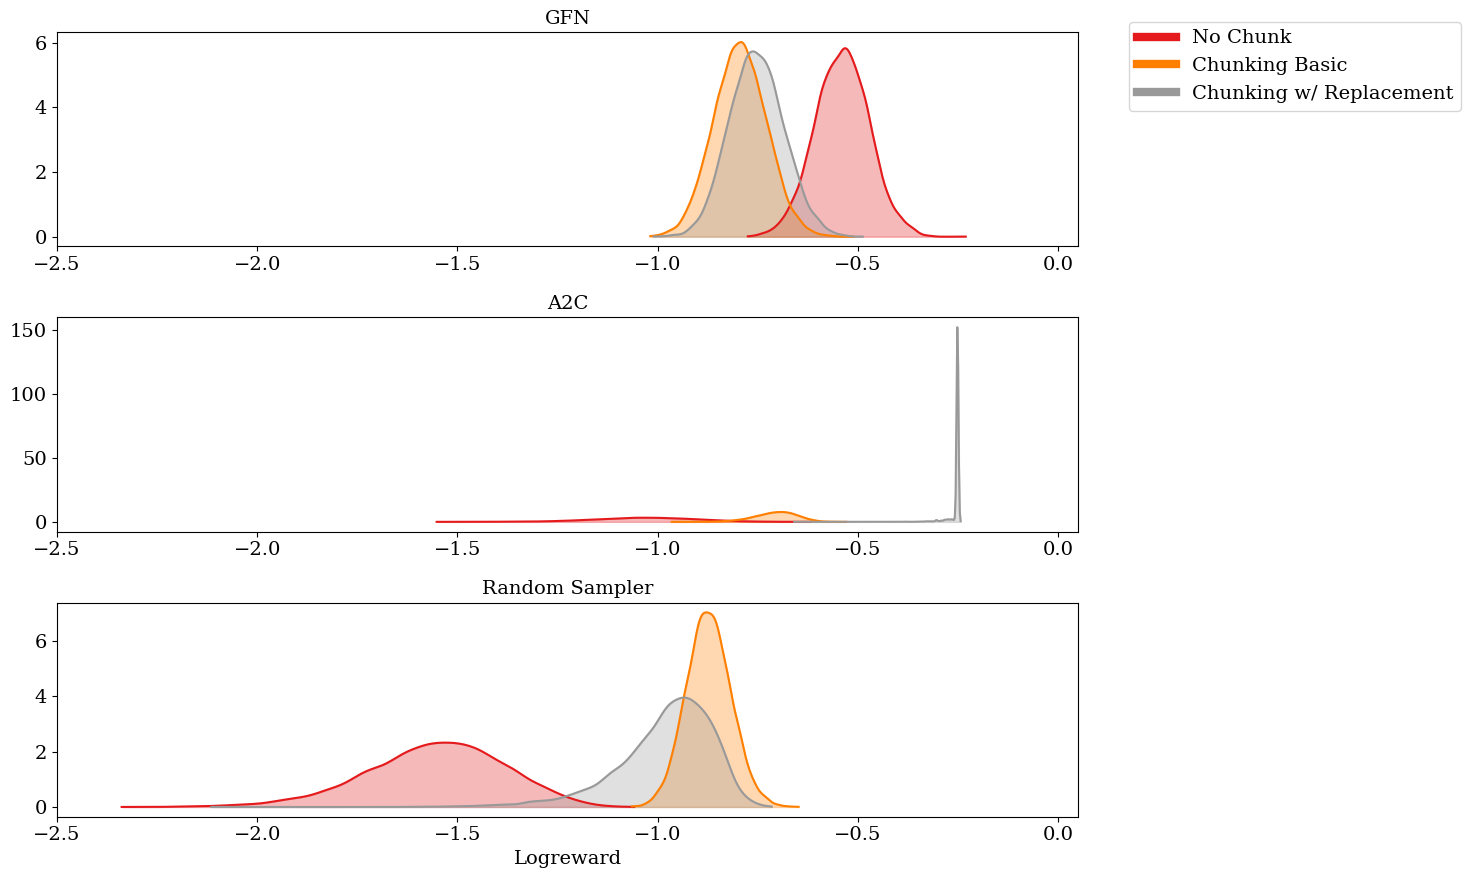

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(15,9))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))
for i, algo in enumerate(logrewards.keys()):
    for j, chunk_type in enumerate(["No Chunk", 'Chunking Basic', "Chunking w/ Replacement"]):

        data = logrewards[algo][chunk_type]
        # Calculate the KDE
        kde = stats.gaussian_kde(data)
        x_range = np.linspace(min(data), max(data), 200)
        y_kde = kde(x_range)

        # Plot the KDE
        ax[i].plot(x_range, y_kde, label=chunk_type, color=colors[j])
        ax[i].fill_between(x_range, y_kde, alpha=0.3, color=colors[j])

    ax[i].set_xlim(-2.5,0.05)
    if i == 0:
        legend = ax[i].legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
        for handle in legend.legendHandles:
            handle.set_linewidth(6)
    ax[i].set_title(algo)
ax[-1].set_xlabel("Logreward")
fig.tight_layout()
plt.show()

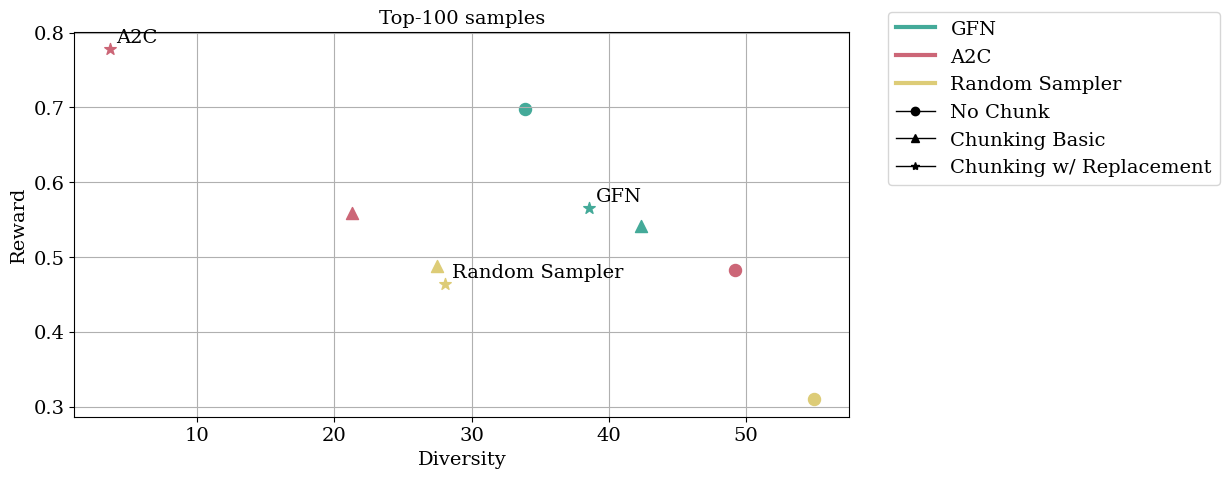

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
markers = {
    "Chunking w/ Replacement": "*",
    "No Chunk": "o",
    "Chunking Basic": "^"
}
colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}
for i, chunk_type in enumerate(markers.keys()):
    for j, algo in enumerate(logrewards.keys()):

        ax.scatter(avg_top100_distance[algo][chunk_type], avg_top100[algo][chunk_type], s=75, color=colors[algo], marker=markers[chunk_type])

    if i == 0:
        for algo in logrewards.keys():
            ax.annotate(
                algo,
                (avg_top100_distance[algo][chunk_type], avg_top100[algo][chunk_type]),
                xytext=(5, 5),
                textcoords='offset points')


legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=3, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=3, linestyle='-', label='A2C'),
    Line2D([0], [0], color='#DDCC77', lw=3, linestyle='-', label='Random Sampler'),
    Line2D([0], [0], color='black', lw=1, marker='o', label='No Chunk'),
    Line2D([0], [0], color='black', lw=1, marker='^', label='Chunking Basic'),
    Line2D([0], [0], color='black', lw=1, marker='*', label='Chunking w/ Replacement')
]

# Create the custom legend
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


ax.set_xlabel("Diversity")
ax.set_ylabel("Reward")
ax.set_title("Top-100 samples")
ax.grid()
plt.show()

In [29]:
beta_logreward = logrewards["GFN"]["No Chunk"] * (100-40)
logZB = 90 + (torch.logsumexp(beta_logreward, dim=0) - torch.tensor(logrewards["GFN"]["No Chunk"].shape[0]).log())

In [30]:
logZB

tensor(45.0914)

# Chunk quality

## Chunk frequency

In [19]:
from pathlib import Path

In [25]:
# TODO
libraries = Dict()
for algorithm in tqdm(experiments["L14_RNA1"]):
    if "Option" in algorithm:
        continue
    for chunk_type in ["Chunking Basic", "Chunking w/ Replacement"]:
        for i, run in enumerate(experiments["L14_RNA1"][algorithm][chunk_type]):
            # run = experiments["L14_RNA1"][algorithm][chunk_type][0]
            run_id = run["id"]
            print("{} - {} - {}".format(algorithm, chunk_type, run_id))
            print(f"lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/library_249.pt")
            try:
                lib = torch.load(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/library_249.pt")
            except:
                lib = torch.load(f"/home/mila/v/vivianoj/scratch/chunkgfn/logs/rna_binding/runs/{run_id}/library_249.pt")
            libraries[algorithm][chunk_type][i] = lib




  0%|          | 0/7 [00:00<?, ?it/s]

Random Sampler - Chunking Basic - 5120755
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5120755/library_249.pt


/tmp/ipykernel_300119/1856281296.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lib = torch.load(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{r

Random Sampler - Chunking Basic - 5120758
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5120758/library_249.pt
Random Sampler - Chunking Basic - 5120763
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5120763/library_249.pt
Random Sampler - Chunking Basic - 5697150
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5697150/library_249.pt
Random Sampler - Chunking Basic - 5697153
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5697153/library_249.pt
Random Sampler - Chunking Basic - 5697156
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5697156/library_249.pt
Random Sampler - Chunking w/ Replacement - 5120759
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5120759/library_249.pt
Random Sampler - Chunking w/ Replacement - 5120756
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5120756/library_249.pt
Random Sampler - Chunking w/ Replacem

/tmp/ipykernel_300119/1856281296.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lib = torch.load(f"/home/mila/v/vivianoj/scratch/chunkgfn/logs/rna_binding/runs/{run_id

SAC - Chunking Basic - 5697165
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5697165/library_249.pt
SAC - Chunking w/ Replacement - 5177450
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5177450/library_249.pt
SAC - Chunking w/ Replacement - 5177459
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5177459/library_249.pt
SAC - Chunking w/ Replacement - 5177468
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5177468/library_249.pt
SAC - Chunking w/ Replacement - 5697160
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5697160/library_249.pt
SAC - Chunking w/ Replacement - 5697163
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5697163/library_249.pt
SAC - Chunking w/ Replacement - 5697166
lib=/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/5697166/library_249.pt
GFN - Chunking Basic - 5180222
lib=/network/scratch/o/oussama.boussif/chunkgfn

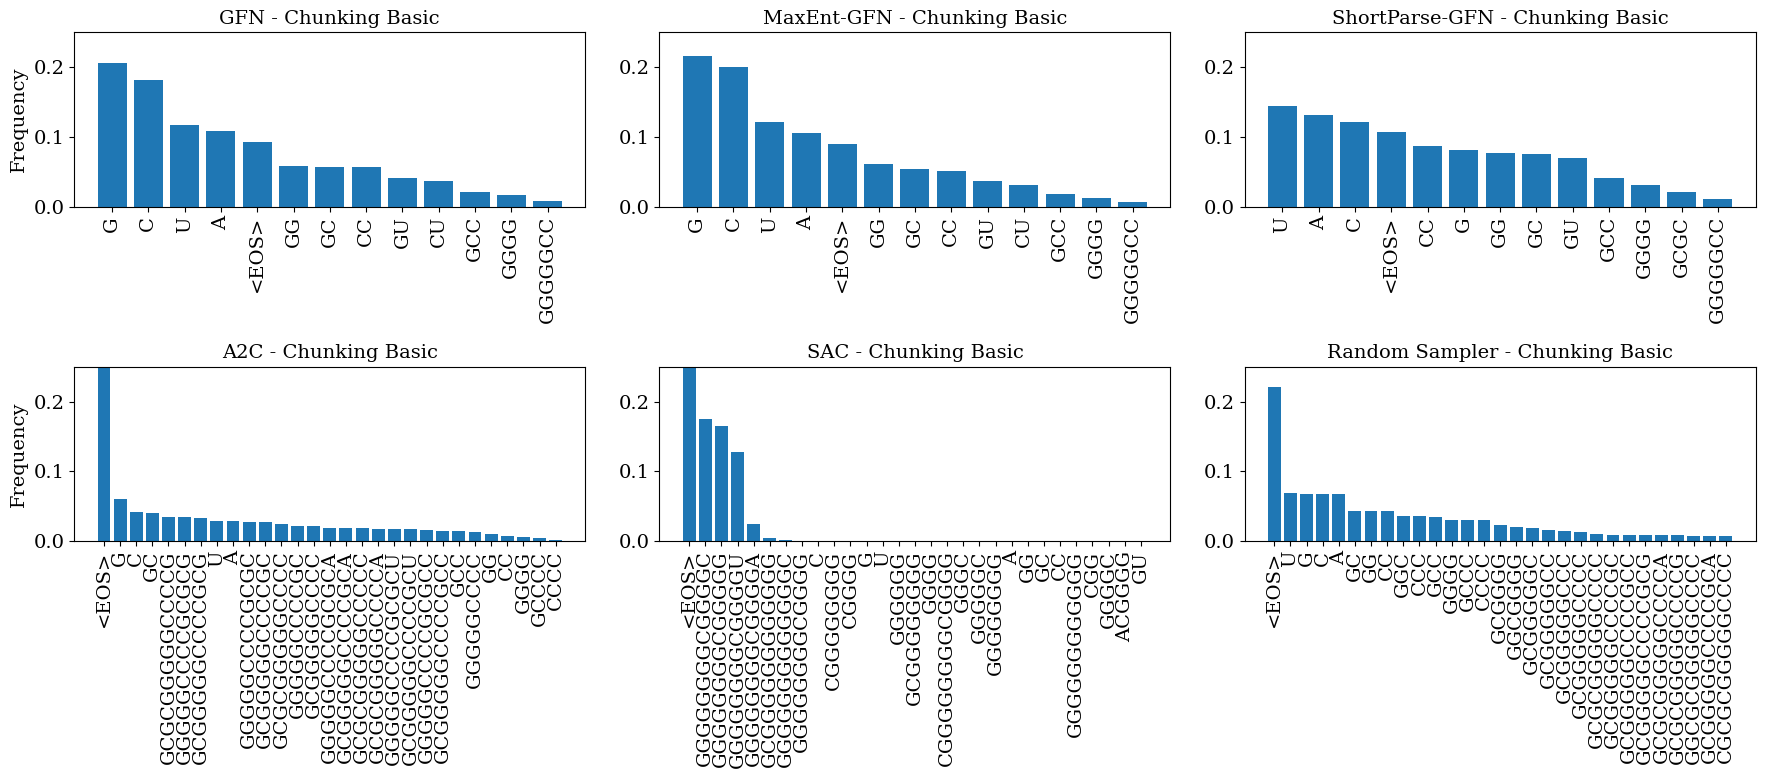

In [10]:
fig, ax = plt.subplots(2,3,figsize=(3*6,2*4))
for i, algo in enumerate(["GFN", "MaxEnt-GFN", "ShortParse-GFN", "A2C", "SAC", "Random Sampler"]):
    lib_ = sorted(libraries[algo]["Chunking Basic"], key=lambda x: x[0], reverse=True)
    lib_Z = sum([a[0] for a in lib_])
    ax[i//3,i%3].bar([a[1] for a in lib_], [a[0].item()/lib_Z for a in lib_])
    ax[i//3,i%3].tick_params(axis='x', rotation=90)
    ax[i//3,i%3].set_title(f"{algo} - Chunking Basic")
    ax[i//3,i%3].set_ylim(0, 0.25)
    if i%3 == 0:
        ax[i//3,i%3].set_ylabel("Frequency")
fig.tight_layout()
fig.savefig("l14_rna1_library_frequency_chunk_basic.png", dpi=300, bbox_inches="tight")

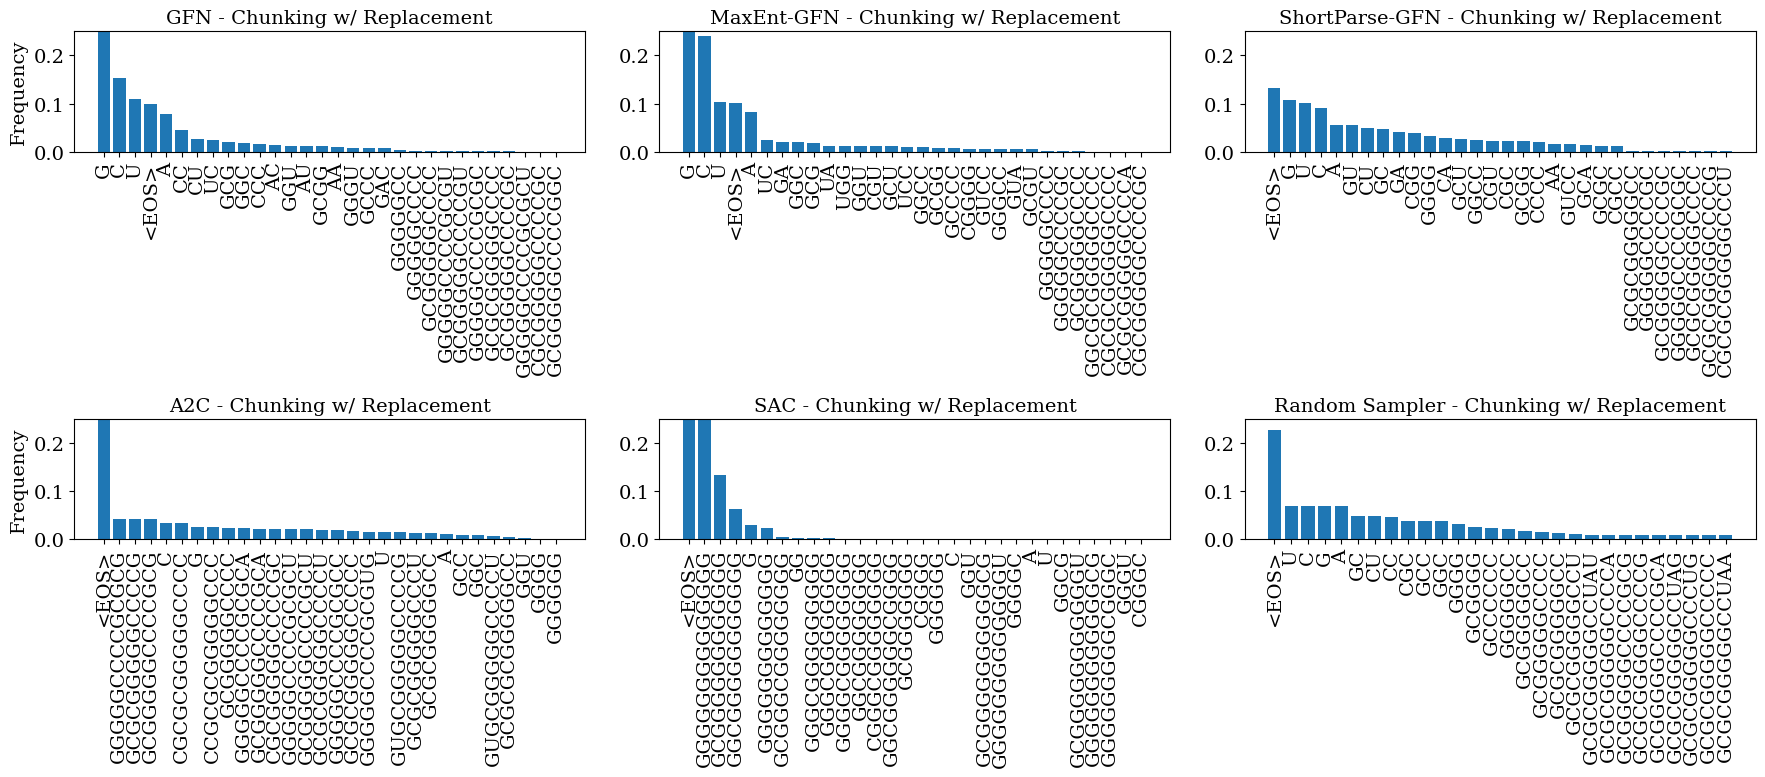

In [11]:
fig, ax = plt.subplots(2,3,figsize=(3*6,2*4))
for i, algo in enumerate(["GFN", "MaxEnt-GFN", "ShortParse-GFN", "A2C", "SAC", "Random Sampler"]):
    lib_ = sorted(libraries[algo]["Chunking w/ Replacement"], key=lambda x: x[0], reverse=True)
    lib_Z = sum([a[0] for a in lib_])
    ax[i//3,i%3].bar([a[1] for a in lib_], [a[0].item()/lib_Z for a in lib_])
    ax[i//3,i%3].tick_params(axis='x', rotation=90)
    ax[i//3,i%3].set_title(f"{algo} - Chunking w/ Replacement")
    ax[i//3,i%3].set_ylim(0, 0.25)
    if i%3 == 0:
        ax[i//3,i%3].set_ylabel("Frequency")
fig.tight_layout()
fig.savefig("l14_rna1_library_frequency_chunk_replacement.png", dpi=300, bbox_inches="tight")

## Usefulness of chunks for finding the modes

In [26]:

# TODO
import pickle

modes = Dict()
for task in ["L14_RNA1", "L14_RNA2"]:
    with open(f"../{task}_high_rewards.pickle", "rb") as f:
        modes[task] = pickle.load(f)

/tmp/ipykernel_300119/3155953726.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  modes[task] = pickle.load(f)
/tmp/ipykernel_300119/3155953726.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the 

### Pairwise edit distance between the selected chunks and modes

In [99]:
pairwise_edit_distance = Dict()
for algorithm in tqdm(libraries):
    for chunk_type in libraries[algorithm]:
        lib = libraries[algorithm][chunk_type]
        lib_ = sorted(libraries[algorithm][chunk_type], key=lambda x: x[0], reverse=True)
        for (freq, chunk) in lib_:
            if chunk not in ["<EOS>", "A", "G", "U", "C"]:
                pairwise_edit_distance[algorithm][chunk_type][chunk] = [levenshtein(chunk, m) for m in modes]

  0%|          | 0/5 [00:00<?, ?it/s]

In [100]:
pairwise_edit_distance.keys()

dict_keys(['Random Sampler', 'GFN', 'MaxEnt-GFN', 'ShortParse-GFN', 'A2C'])

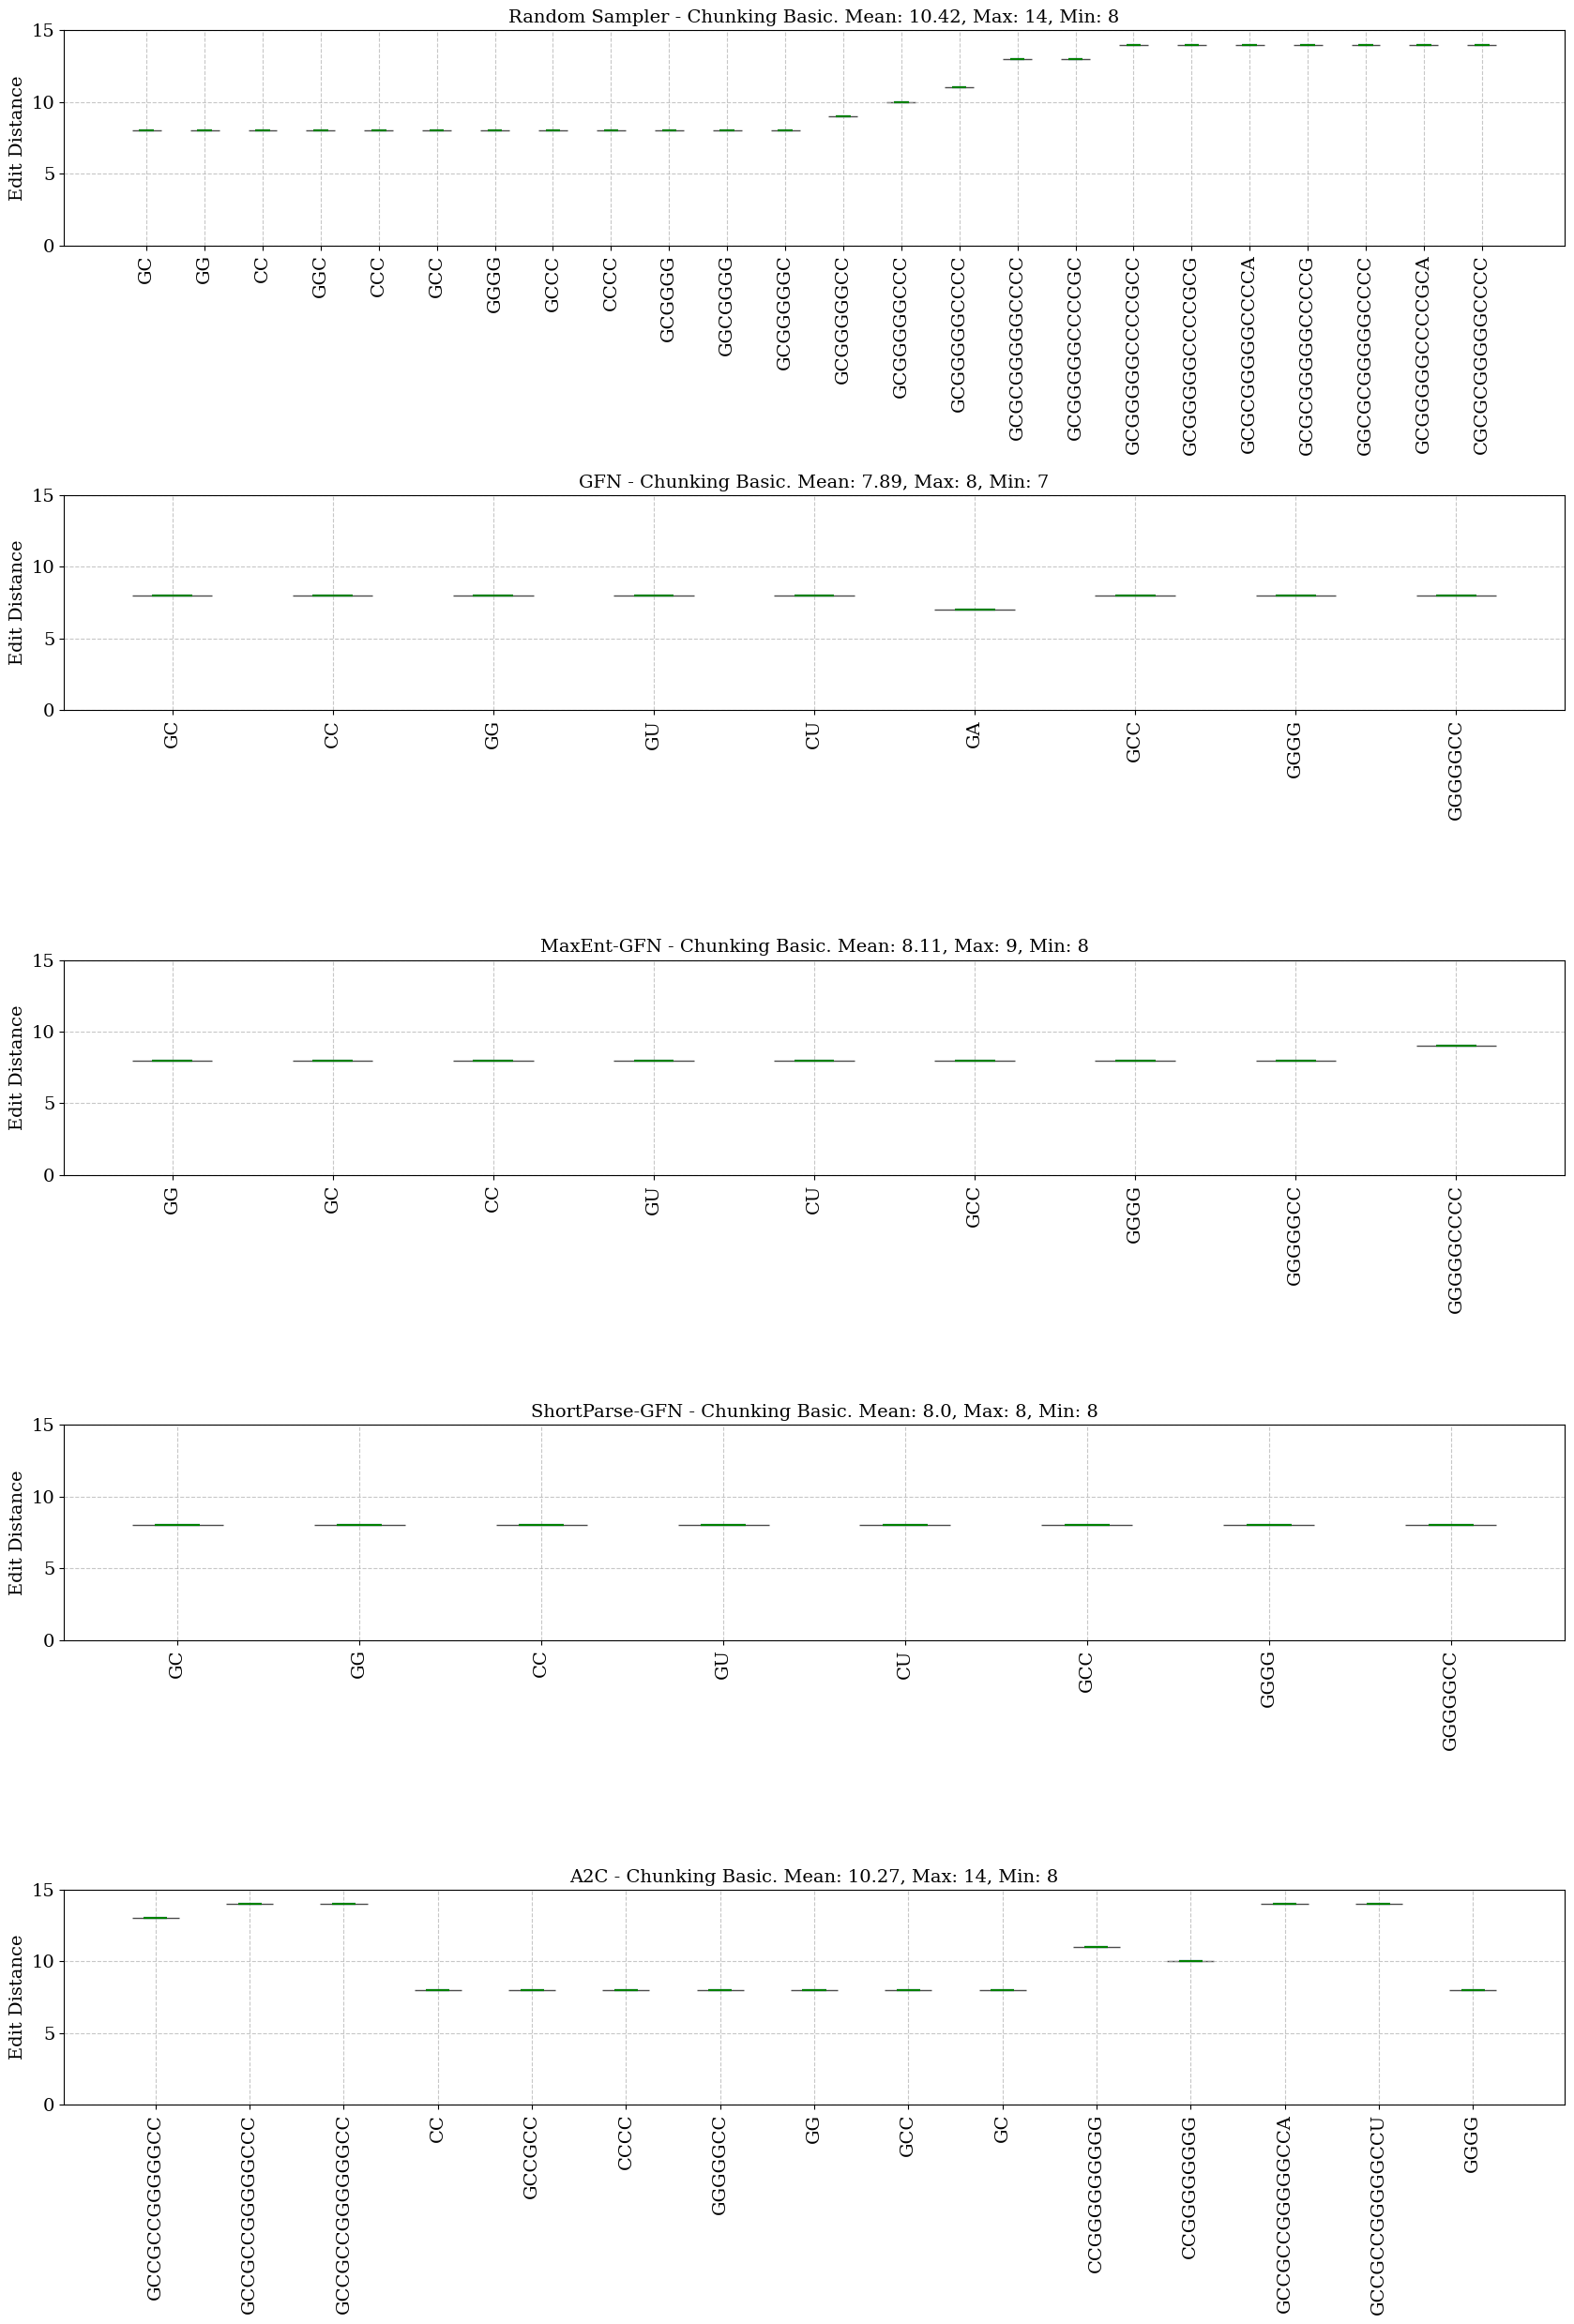

In [ ]:
fig, ax = plt.subplots(5,1,figsize=(17,25))

algo_colors = {
    "ShortParse-GFN": "#4878D0",
    "MaxEnt-GFN": "#E2C458",
    "GFN": "#6ACC64",
    "A2C": "#956CB6",
    "Random Sampler": "#8C8C8C"
}

for i, algo in enumerate(pairwise_edit_distance):

    data = pairwise_edit_distance[algo]["Chunking Basic"]
    all_distances = []
    for chunk in data:
        all_distances.extend(data[chunk])

    mean = np.mean(all_distances)
    maxi = np.max(all_distances)
    mini = np.min(all_distances)

    positions = range(len(data))
    violin_parts = ax[i].violinplot(list(data.values()), positions, showmeans=True, showextrema=True, showmedians=False)

    for pc in violin_parts['bodies']:
        pc.set_facecolor(algo_colors[algo])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    violin_parts['cmeans'].set_color('blue')
    violin_parts['cmaxes'].set_color('green')
    violin_parts['cmins'].set_color('green')
    violin_parts['cbars'].set_color('green')

    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(list(data.keys()))
    ax[i].set_ylabel('Edit Distance')
    ax[i].set_title(f"{algo} - Chunking Basic. Mean: {round(mean,2)}, Max: {maxi}, Min: {mini}")
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_ylim(0,15)
    ax[i].grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

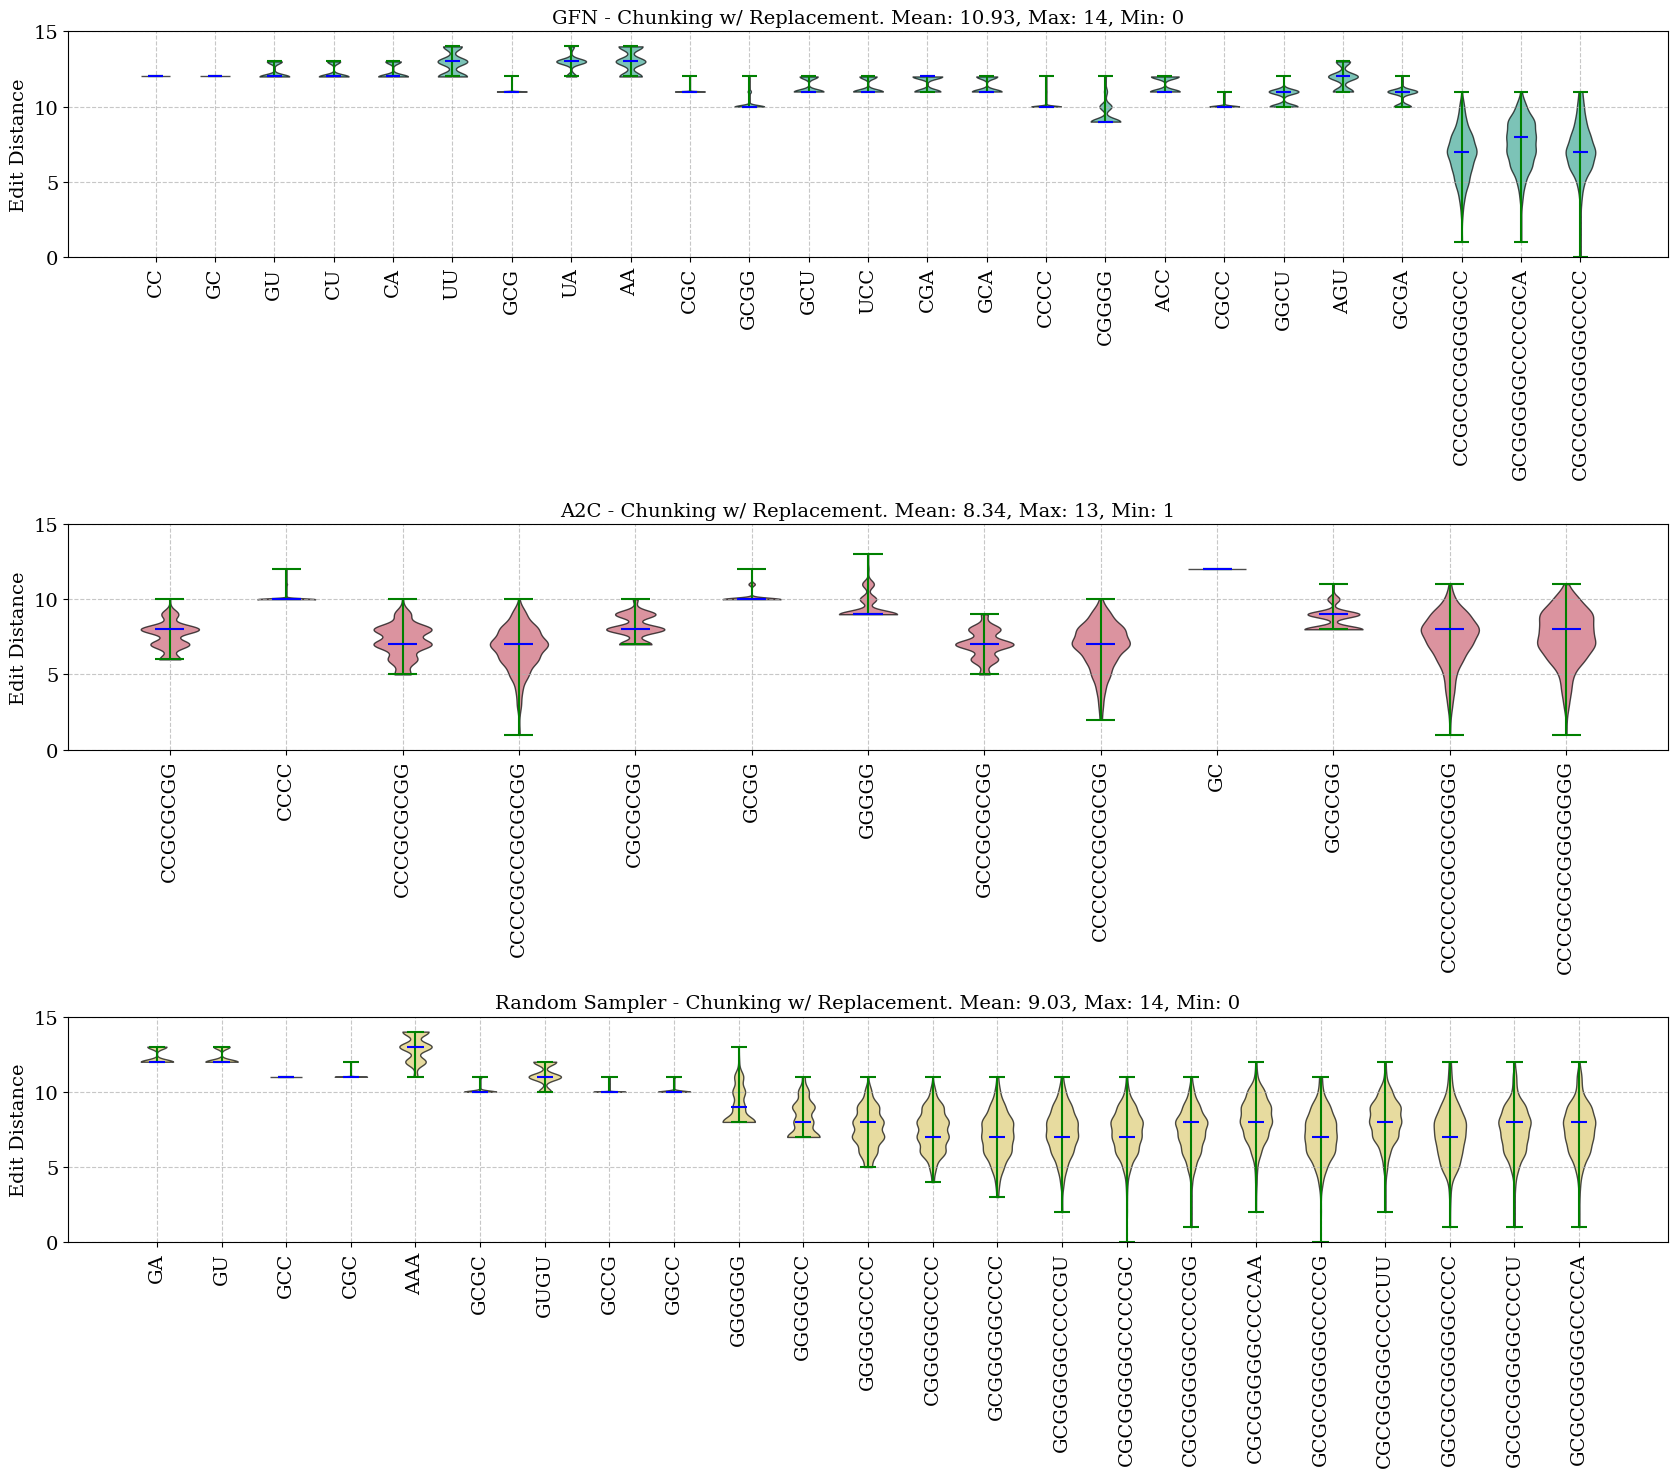

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(17,15))

colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}

for i, algo in enumerate(pairwise_edit_distance):

    data = pairwise_edit_distance[algo]["Chunking w/ Replacement"]
    all_distances = []
    for chunk in data:
        all_distances.extend(data[chunk])

    mean = np.mean(all_distances)
    maxi = np.max(all_distances)
    mini = np.min(all_distances)

    positions = range(len(data))
    violin_parts = ax[i].violinplot(list(data.values()), positions, showmeans=False, showextrema=True, showmedians=True)

    for pc in violin_parts['bodies']:
        pc.set_facecolor(colors[algo])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    violin_parts['cmedians'].set_color('blue')
    violin_parts['cmaxes'].set_color('green')
    violin_parts['cmins'].set_color('green')
    violin_parts['cbars'].set_color('green')

    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(list(data.keys()))
    ax[i].set_ylabel('Edit Distance')
    ax[i].set_title(f"{algo} - Chunking w/ Replacement. Mean: {round(mean,2)}, Max: {maxi}, Min: {mini}")
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_ylim(0,15)
    ax[i].grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

### BLEU Scores between chunks and modes

In [ ]:
import math
from collections import Counter

def char_level_bleu(reference, candidate, n=4):
    """
    Calculate the character-level BLEU score for a candidate string given a reference string.

    :param reference: The reference string
    :param candidate: The candidate string to be evaluated
    :param n: The maximum n-gram size to consider (default is 4)
    :return: The BLEU score as a float between 0 and 1
    """
    def ngrams(s, n):
        return [s[i:i+n] for i in range(len(s)-n+1)]

    if len(candidate) == 0:
        return 0

    candidate_len = len(candidate)
    reference_len = len(reference)

    # Calculate brevity penalty
    if candidate_len > reference_len:
        bp = 1
    else:
        bp = math.exp(1 - reference_len / candidate_len)

    # Calculate n-gram precisions
    precisions = []
    for i in range(1, n+1):
        ref_ngrams = Counter(ngrams(reference, i))
        cand_ngrams = Counter(ngrams(candidate, i))

        matches = sum((ref_ngrams & cand_ngrams).values())
        total = sum(cand_ngrams.values())

        if total > 0:
            precisions.append(matches / total)
        else:
            precisions.append(0)

    # Calculate geometric mean of precisions
    if all(p > 0 for p in precisions):
        avg_prec = math.exp(sum(math.log(p) for p in precisions) / len(precisions))
    else:
        avg_prec = 0

    return bp * avg_prec

In [25]:
pairwise_bleu = Dict()
for algorithm in tqdm(libraries):
    for chunk_type in libraries[algorithm]:
        lib = libraries[algorithm][chunk_type]
        lib_ = sorted(libraries[algorithm][chunk_type], key=lambda x: x[0], reverse=True)
        for (freq, chunk) in lib_:
            if chunk not in ["<EOS>", "A", "G", "U", "C"]:
                pairwise_bleu[algorithm][chunk_type][chunk] = [char_level_bleu(m, chunk) for m in modes]

  0%|          | 0/3 [00:00<?, ?it/s]

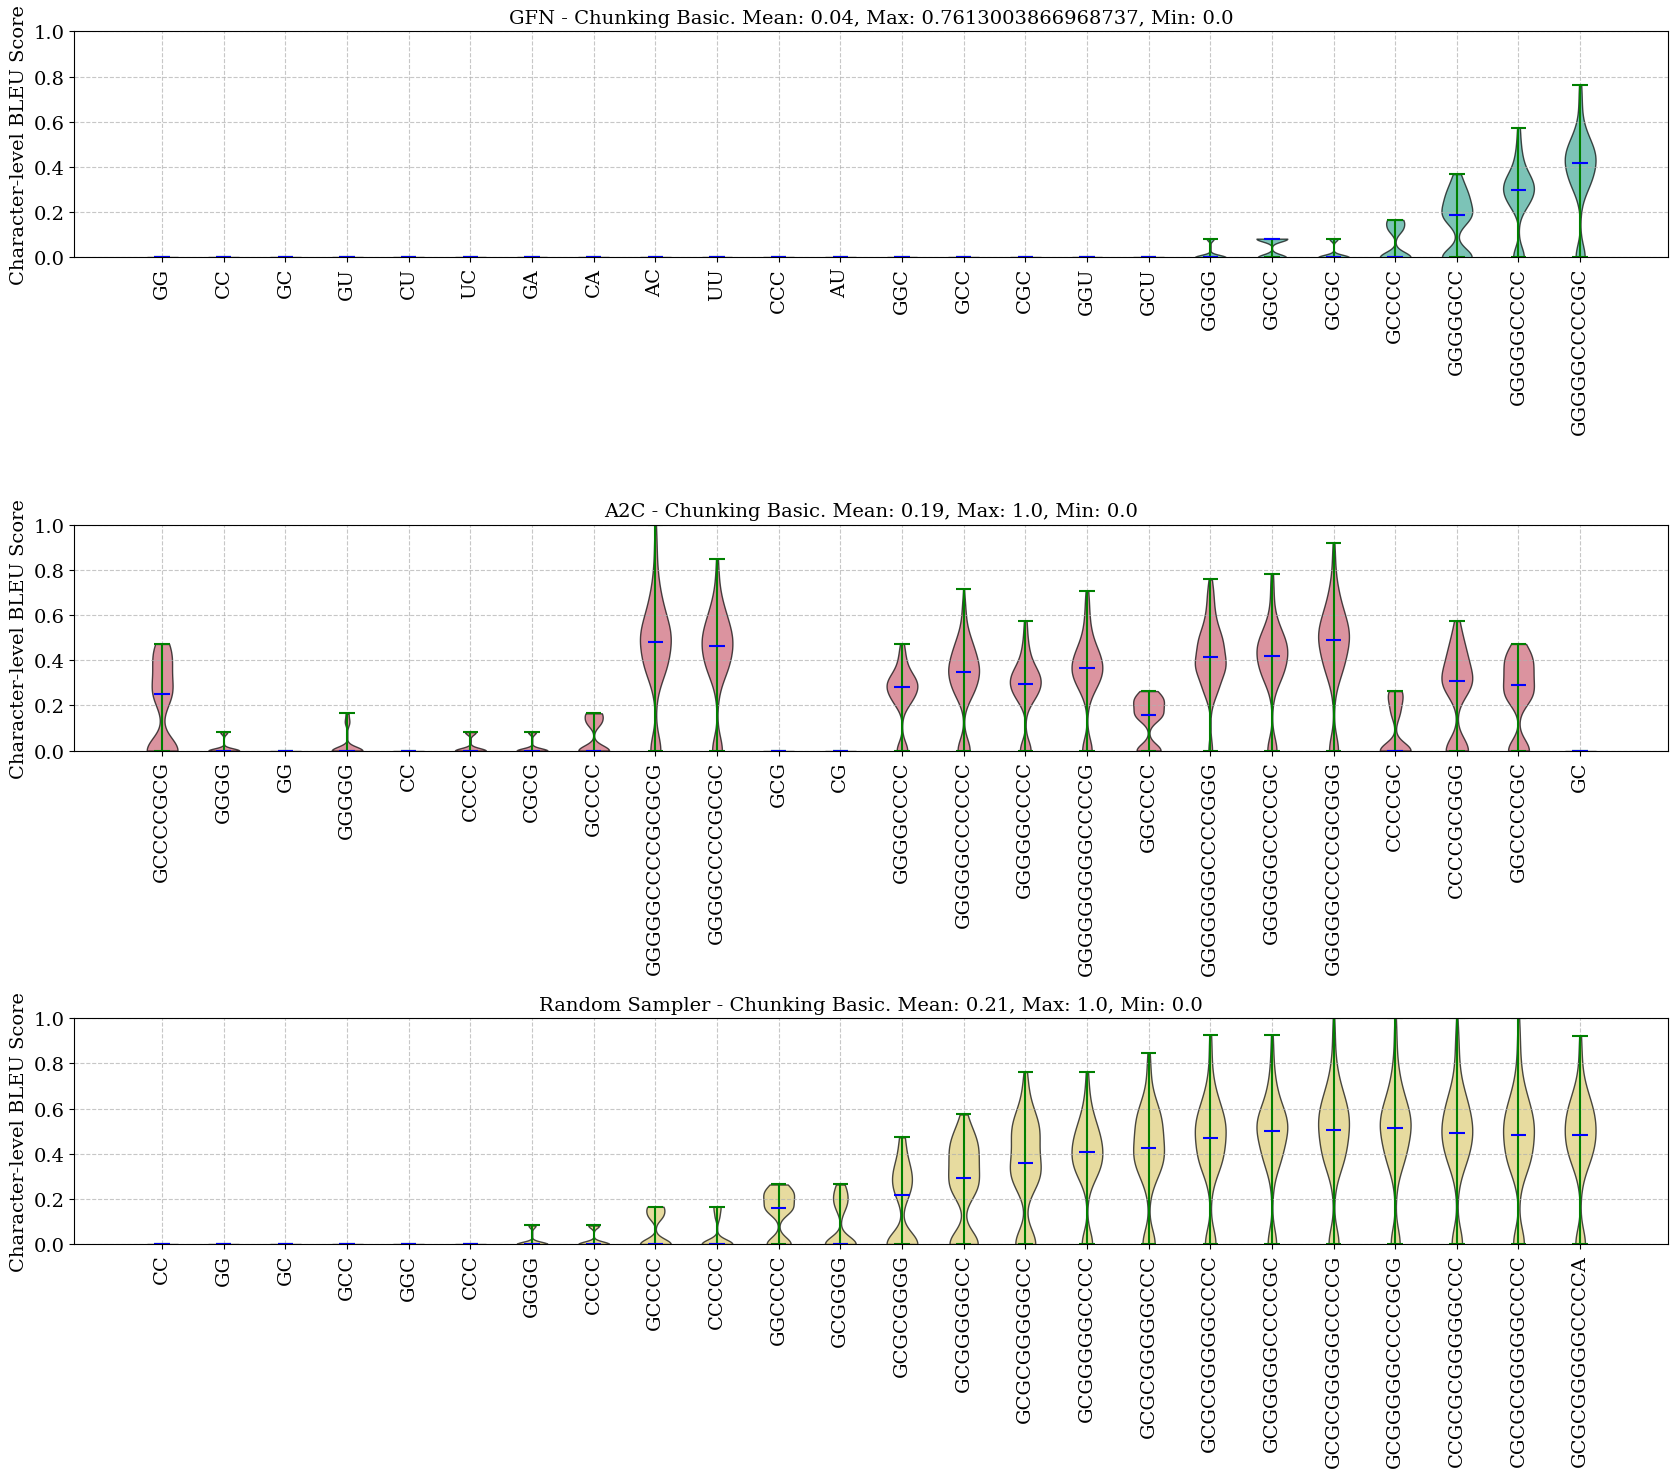

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(17,15))

colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}

for i, algo in enumerate(pairwise_bleu):

    data = pairwise_bleu[algo]["Chunking Basic"]
    all_distances = []
    for chunk in data:
        all_distances.extend(data[chunk])

    mean = np.mean(all_distances)
    maxi = np.max(all_distances)
    mini = np.min(all_distances)

    positions = range(len(data))
    violin_parts = ax[i].violinplot(list(data.values()), positions, showmeans=False, showextrema=True, showmedians=True)

    for pc in violin_parts['bodies']:
        pc.set_facecolor(colors[algo])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    violin_parts['cmedians'].set_color('blue')
    violin_parts['cmaxes'].set_color('green')
    violin_parts['cmins'].set_color('green')
    violin_parts['cbars'].set_color('green')

    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(list(data.keys()))
    ax[i].set_ylabel('Character-level BLEU Score')
    ax[i].set_title(f"{algo} - Chunking Basic. Mean: {round(mean,2)}, Max: {maxi}, Min: {mini}")
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_ylim(0,1)
    ax[i].grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

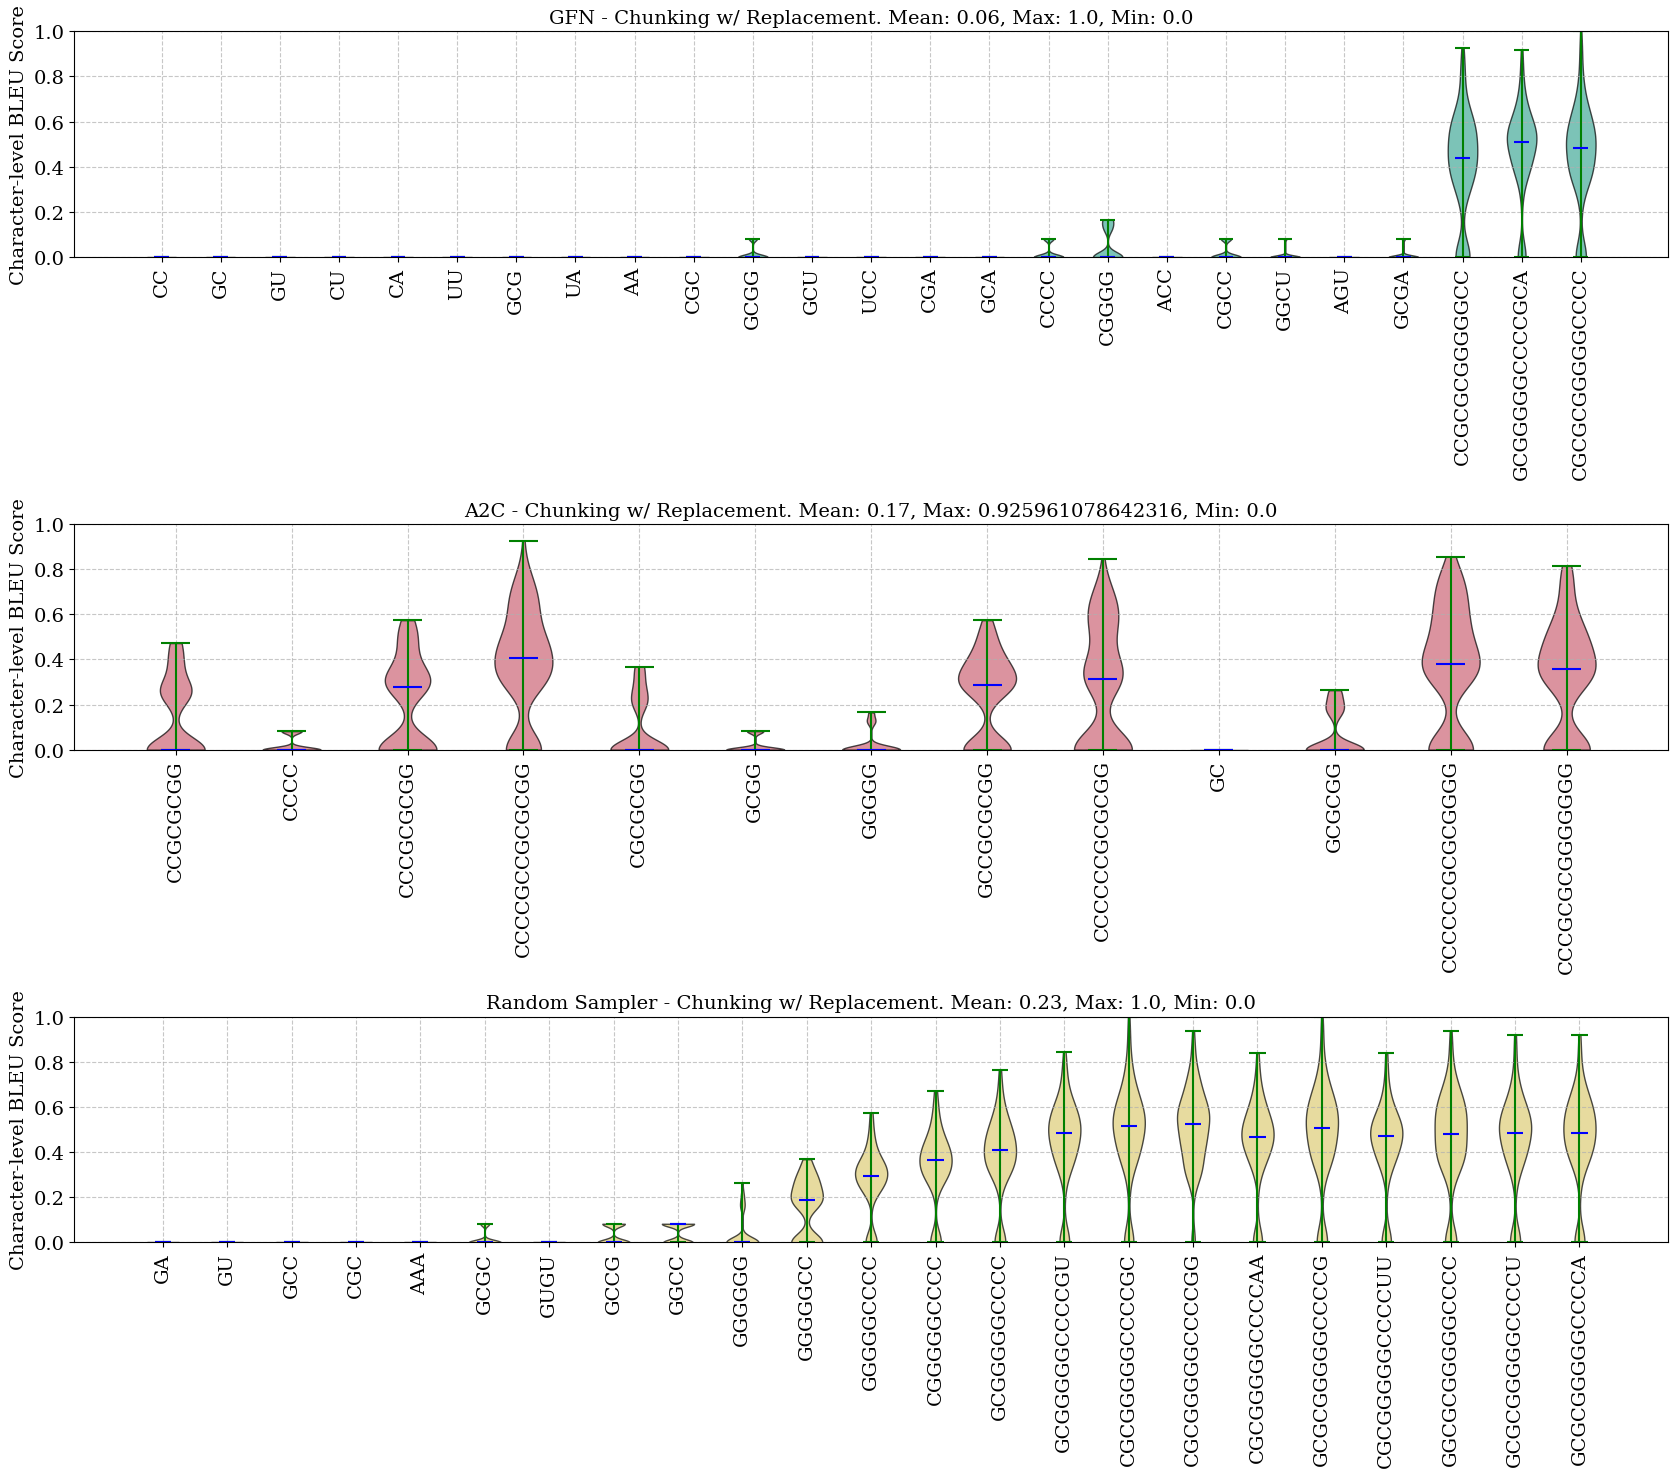

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(17,15))

colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}

for i, algo in enumerate(pairwise_bleu):

    data = pairwise_bleu[algo]["Chunking w/ Replacement"]
    all_distances = []
    for chunk in data:
        all_distances.extend(data[chunk])

    mean = np.mean(all_distances)
    maxi = np.max(all_distances)
    mini = np.min(all_distances)

    positions = range(len(data))
    violin_parts = ax[i].violinplot(list(data.values()), positions, showmeans=False, showextrema=True, showmedians=True)

    for pc in violin_parts['bodies']:
        pc.set_facecolor(colors[algo])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    violin_parts['cmedians'].set_color('blue')
    violin_parts['cmaxes'].set_color('green')
    violin_parts['cmins'].set_color('green')
    violin_parts['cbars'].set_color('green')

    ax[i].set_xticks(positions)
    ax[i].set_xticklabels(list(data.keys()))
    ax[i].set_ylabel('Character-level BLEU Score')
    ax[i].set_title(f"{algo} - Chunking w/ Replacement. Mean: {round(mean,2)}, Max: {maxi}, Min: {mini}")
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_ylim(0,1)
    ax[i].grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

### Chunk frequency in modes

In [15]:
chunk_count = Dict()
for algorithm in tqdm(libraries):
    for chunk_type in libraries[algorithm]:
        lib = libraries[algorithm][chunk_type]
        lib_ = sorted(libraries[algorithm][chunk_type], key=lambda x: x[0], reverse=True)
        for (freq, chunk) in lib_:
            if chunk not in ["<EOS>", "A", "G", "U", "C"]:
                chunk_count[algorithm][chunk_type][chunk] = [m.count(chunk) for m in modes["L14_RNA1"]]

  0%|          | 0/6 [00:00<?, ?it/s]

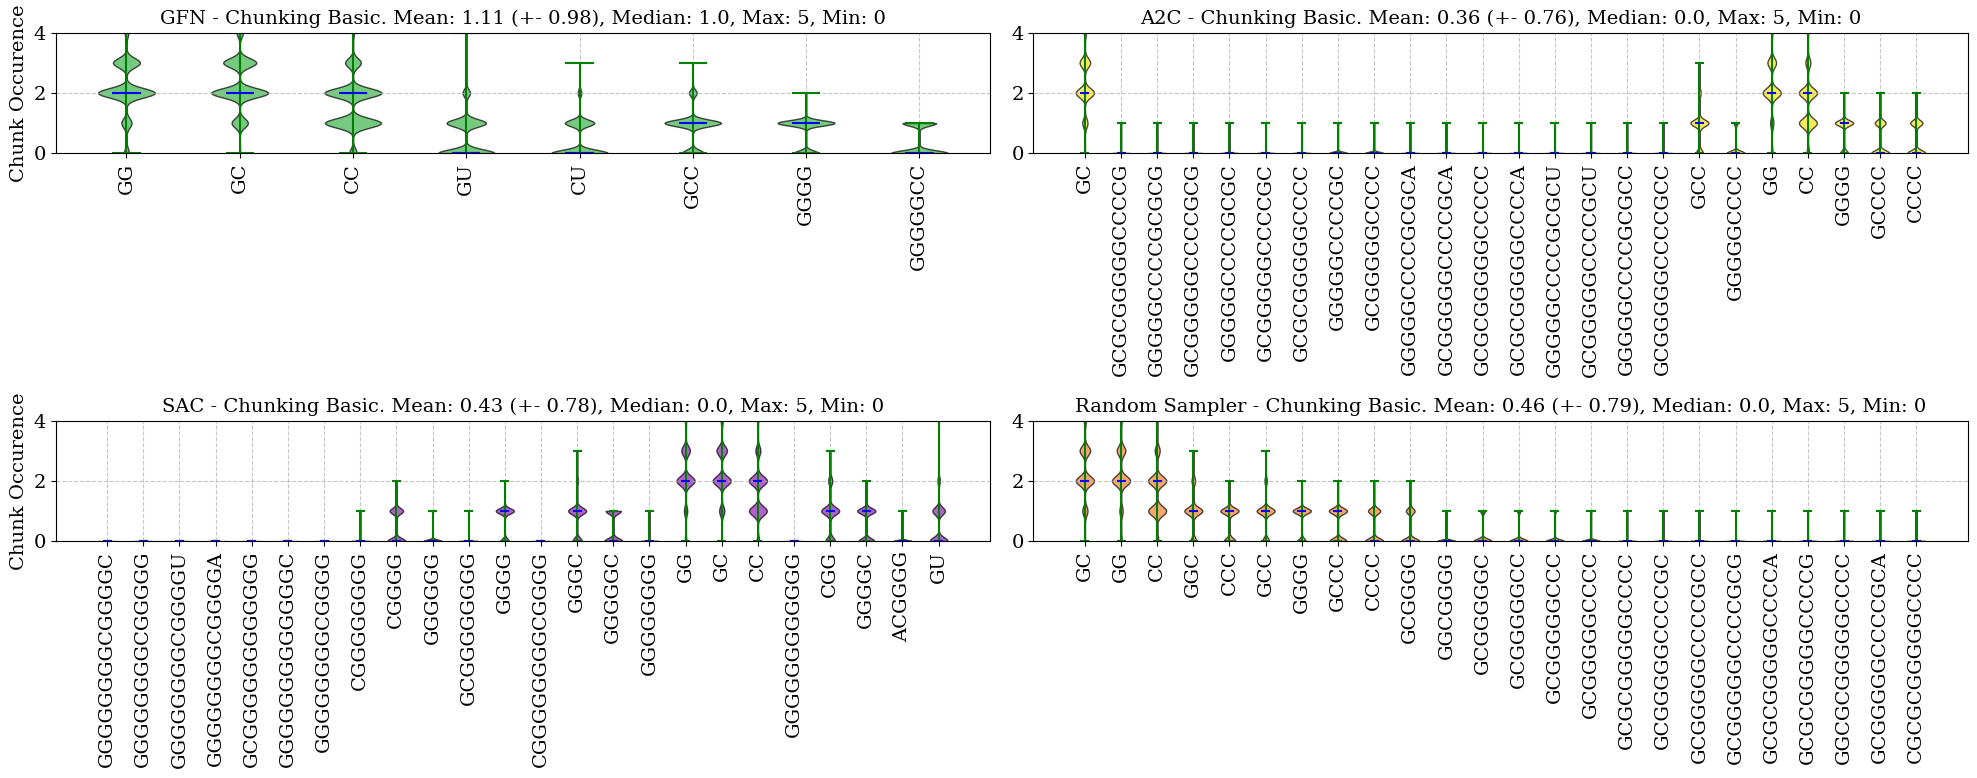

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,8))


for i, algo in enumerate(["GFN", "A2C", "SAC", "Random Sampler"]):

    data = chunk_count[algo]["Chunking Basic"]
    all_distances = []
    for chunk in data:
        all_distances.extend(data[chunk])

    mean = round(np.mean(all_distances), 2)
    std = round(np.std(all_distances), 2)
    median = round(np.median(all_distances), 2)
    maxi = round(np.max(all_distances), 2)
    mini = round(np.min(all_distances), 2)

    positions = range(len(data))
    violin_parts = ax[i//2,i%2].violinplot(list(data.values()), positions, showmeans=False, showextrema=True, showmedians=True)

    for pc in violin_parts['bodies']:
        pc.set_facecolor(algo_colors[algo])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    violin_parts['cmedians'].set_color('blue')
    violin_parts['cmaxes'].set_color('green')
    violin_parts['cmins'].set_color('green')
    violin_parts['cbars'].set_color('green')

    ax[i//2,i%2].set_xticks(positions)
    ax[i//2,i%2].set_xticklabels(list(data.keys()))
    if i%2 == 0:
        ax[i//2,i%2].set_ylabel('Chunk Occurence')
    ax[i//2,i%2].set_title(f"{algo} - Chunking Basic. Mean: {mean} (+- {std}), Median: {median}, Max: {maxi}, Min: {mini}")
    ax[i//2,i%2].tick_params(axis='x', rotation=90)
    ax[i//2,i%2].set_ylim(0,4)
    ax[i//2,i%2].grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
fig.savefig("l14_rna1_chunk_occurence_chunking_basic.png", dpi=300, bbox_inches="tight")

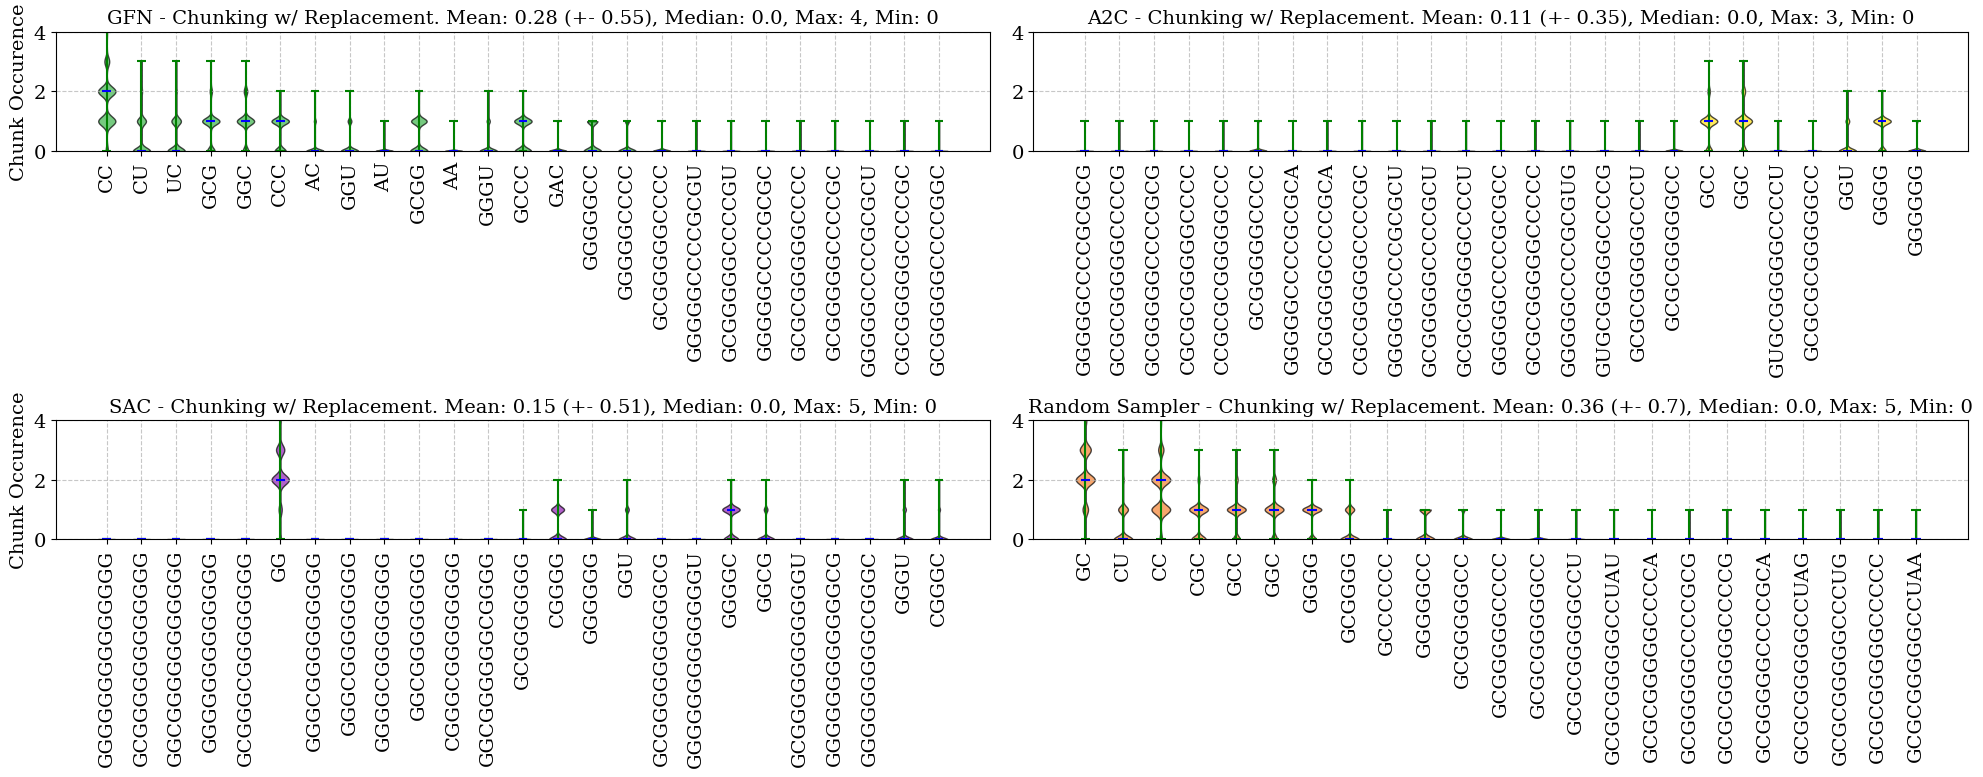

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,8))


for i, algo in enumerate(["GFN", "A2C", "SAC", "Random Sampler"]):

    data = chunk_count[algo]["Chunking w/ Replacement"]
    all_distances = []
    for chunk in data:
        all_distances.extend(data[chunk])

    mean = round(np.mean(all_distances), 2)
    std = round(np.std(all_distances), 2)
    median = round(np.median(all_distances), 2)
    maxi = round(np.max(all_distances), 2)
    mini = round(np.min(all_distances), 2)

    positions = range(len(data))
    violin_parts = ax[i//2,i%2].violinplot(list(data.values()), positions, showmeans=False, showextrema=True, showmedians=True)

    for pc in violin_parts['bodies']:
        pc.set_facecolor(algo_colors[algo])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    violin_parts['cmedians'].set_color('blue')
    violin_parts['cmaxes'].set_color('green')
    violin_parts['cmins'].set_color('green')
    violin_parts['cbars'].set_color('green')

    ax[i//2,i%2].set_xticks(positions)
    ax[i//2,i%2].set_xticklabels(list(data.keys()))
    if i % 2 == 0:
        ax[i//2,i%2].set_ylabel('Chunk Occurence')
    ax[i//2,i%2].set_title(f"{algo} - Chunking w/ Replacement. Mean: {mean} (+- {std}), Median: {median}, Max: {maxi}, Min: {mini}")
    ax[i//2,i%2].tick_params(axis='x', rotation=90)
    ax[i//2,i%2].set_ylim(0,4)
    ax[i//2,i%2].grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
fig.savefig("l14_rna1_chunk_occurence_chunking_replacement.png", dpi=300, bbox_inches="tight")

### Chunk Coverage

In [27]:
chunk_cov = Dict()
for algorithm in tqdm(libraries):
    for chunk_type in libraries[algorithm]:
        lib = libraries[algorithm][chunk_type]
        lib_ = sorted(libraries[algorithm][chunk_type], key=lambda x: x[0], reverse=True)
        for (freq, chunk) in lib_:
            if chunk not in ["<EOS>", "A", "G", "U", "C"]:
                chunk_cov[algorithm][chunk_type][chunk] = sum([int(m.count(chunk))>0 for m in modes["L14_RNA1"]])/len(modes["L14_RNA1"])

  0%|          | 0/6 [00:00<?, ?it/s]

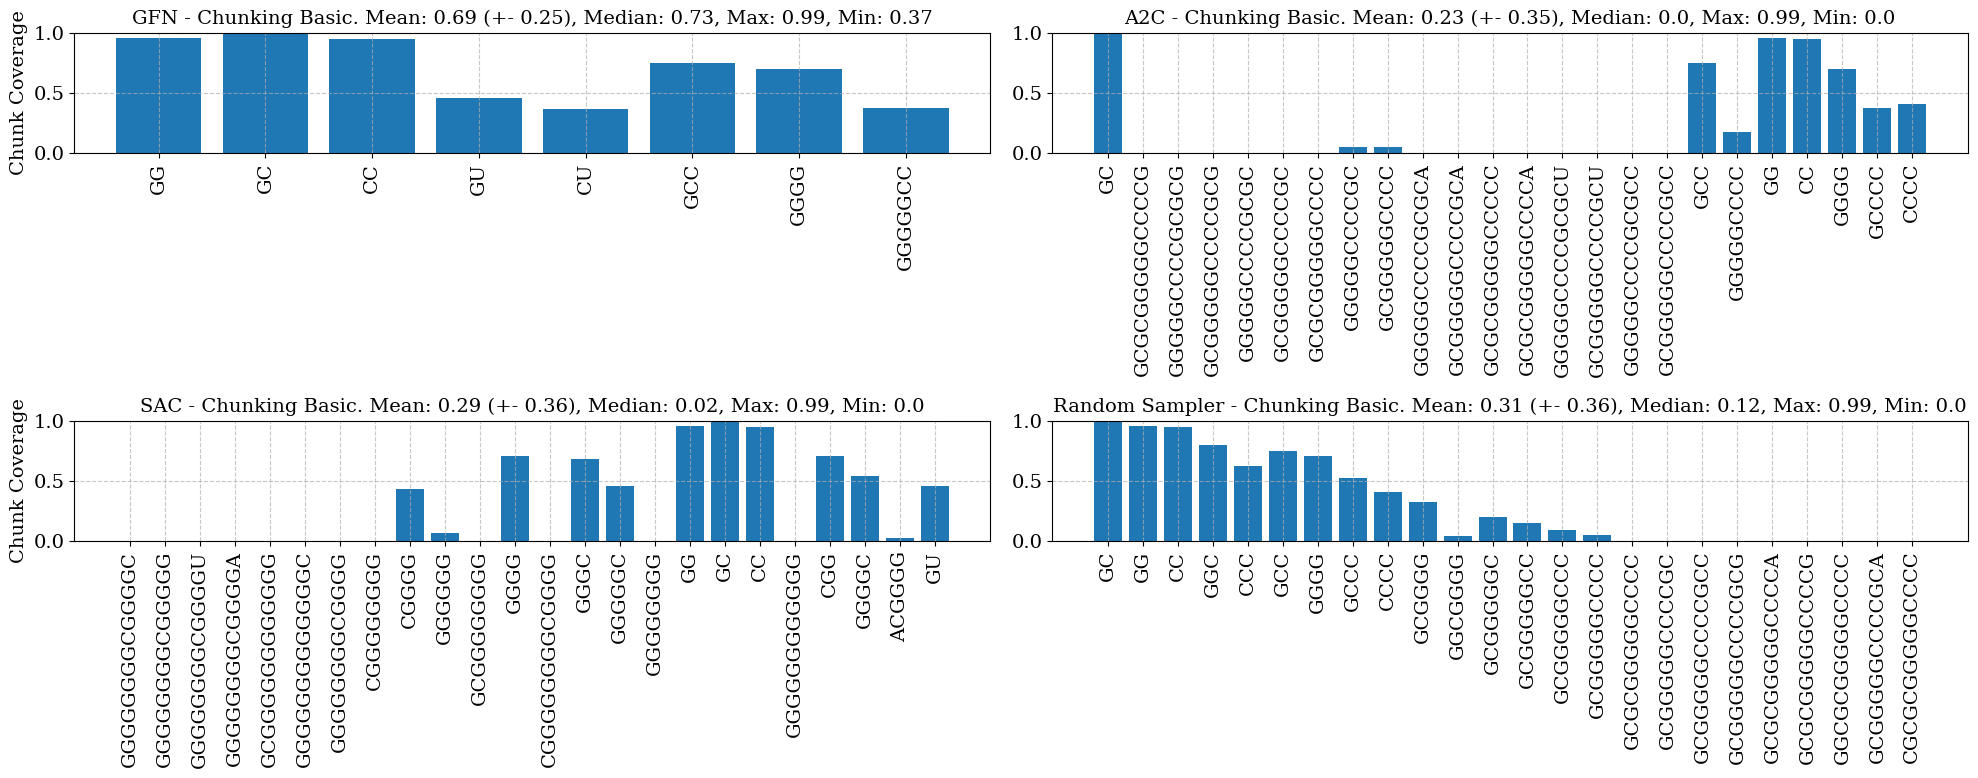

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,8))



for i, algo in enumerate(["GFN", "A2C", "SAC", "Random Sampler"]):

    data = chunk_cov[algo]["Chunking Basic"]

    mean = round(np.mean(list(data.values())),2)
    median = round(np.median(list(data.values())),2)
    std = round(np.std(list(data.values())),2)
    maxi = round(np.max(list(data.values())),2)
    mini = round(np.min(list(data.values())),2)

    positions = range(len(data))
    bars = ax[i//2,i%2].bar(positions, list(data.values()))

    ax[i//2,i%2].set_xticks(positions)
    ax[i//2,i%2].set_xticklabels(list(data.keys()))
    if i%2 == 0:
        ax[i//2,i%2].set_ylabel('Chunk Coverage')
    ax[i//2,i%2].set_title(f"{algo} - Chunking Basic. Mean: {mean} (+- {std}), Median: {median}, Max: {maxi}, Min: {mini}")
    ax[i//2,i%2].tick_params(axis='x', rotation=90)
    ax[i//2,i%2].set_ylim(0,1)
    ax[i//2,i%2].grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
fig.savefig("l14_rna1_chunk_coverage_chunking_basic.png", dpi=300, bbox_inches="tight")

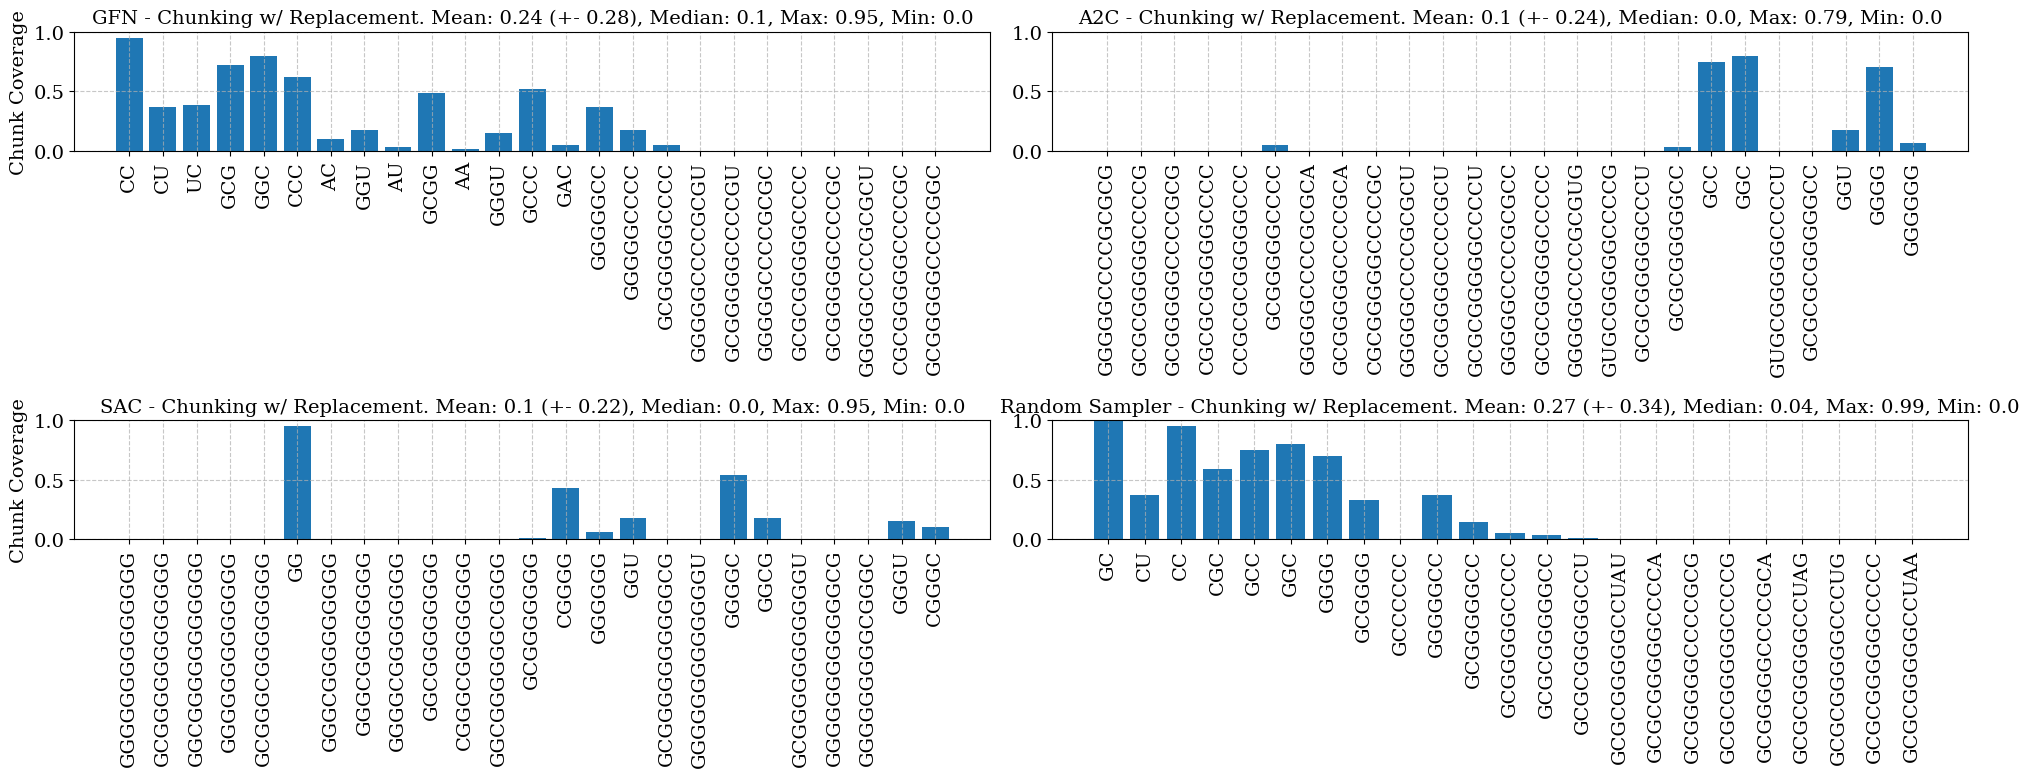

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,8))



for i, algo in enumerate(["GFN", "A2C", "SAC", "Random Sampler"]):

    data = chunk_cov[algo]["Chunking w/ Replacement"]

    mean = round(np.mean(list(data.values())),2)
    median = round(np.median(list(data.values())),2)
    std = round(np.std(list(data.values())),2)
    maxi = round(np.max(list(data.values())),2)
    mini = round(np.min(list(data.values())),2)

    positions = range(len(data))
    bars = ax[i//2,i%2].bar(positions, list(data.values()))

    ax[i//2,i%2].set_xticks(positions)
    ax[i//2,i%2].set_xticklabels(list(data.keys()))
    if i%2 == 0:
        ax[i//2,i%2].set_ylabel('Chunk Coverage')
    ax[i//2,i%2].set_title(f"{algo} - Chunking w/ Replacement. Mean: {mean} (+- {std}), Median: {median}, Max: {maxi}, Min: {mini}")
    ax[i//2,i%2].tick_params(axis='x', rotation=90)
    ax[i//2,i%2].set_ylim(0,1)
    ax[i//2,i%2].grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
fig.savefig("l14_rna1_chunk_coverage_chunking_replacement.png", dpi=300, bbox_inches="tight")

In [ ]:
chunk_latent_metrics = Dict()
for i, algo in enumerate(["GFN", "MaxEnt-GFN", "ShortParse-GFN", "A2C", "SAC", "Random Sampler"]):
    for chunk_type in ["Chunking Basic", "Chunking w/ Replacement"]:
        # Chunk Coverage
        data = chunk_cov[algo][chunk_type]
        chunk_latent_metrics["coverage"][algo][chunk_type]["mean"] = round(np.mean(list(data.values())),2)
        chunk_latent_metrics["coverage"][algo][chunk_type]["median"] = round(np.median(list(data.values())),2)
        chunk_latent_metrics["coverage"][algo][chunk_type]["std"] = round(np.std(list(data.values())),2)
        chunk_latent_metrics["coverage"][algo][chunk_type]["maxi"] = round(np.max(list(data.values())),2)
        chunk_latent_metrics["coverage"][algo][chunk_type]["mini"] = round(np.min(list(data.values())),2)

        # Chunk Occurence
        data = chunk_count[algo][chunk_type]
        all_distances = []
        for chunk in data:
            all_distances.extend(data[chunk])

        chunk_latent_metrics["occurence"][algo][chunk_type]["mean"] = round(np.mean(all_distances), 2)
        chunk_latent_metrics["occurence"][algo][chunk_type]["std"] = round(np.std(all_distances), 2)
        chunk_latent_metrics["occurence"][algo][chunk_type]["median"] = round(np.median(all_distances), 2)
        chunk_latent_metrics["occurence"][algo][chunk_type]["maxi"] = round(np.max(all_distances), 2)
        chunk_latent_metrics["occurence"][algo][chunk_type]["mini"] = round(np.min(all_distances), 2)

In [45]:
chunk_latent_metrics["occurence"]["ShortParse-GFN"]

{'Chunking Basic': {'mean': 1.1,
  'std': 0.98,
  'median': 1.0,
  'maxi': 5,
  'mini': 0},
 'Chunking w/ Replacement': {'mean': 0.34,
  'std': 0.63,
  'median': 0.0,
  'maxi': 5,
  'mini': 0}}

In [44]:
chunk_latent_metrics["coverage"]["ShortParse-GFN"]

{'Chunking Basic': {'mean': 0.68,
  'median': 0.73,
  'std': 0.26,
  'maxi': 0.99,
  'mini': 0.3},
 'Chunking w/ Replacement': {'mean': 0.27,
  'median': 0.17,
  'std': 0.27,
  'maxi': 0.99,
  'mini': 0.0}}

## Compression

### Shortest parse of modes using learned library

In [63]:
def shortest_parse(vocabulary, string):
    min_parses = {string[:i]: float("inf") for i in range(len(string)+1)}
    min_parses[""] = 0
    best_tokens = {"": []}
    for ln in range(1, len(string)+1):
        s = string[:ln]
        candidates = []
        for token in vocabulary:
            c = len(token)
            if s[-c:] == token:
                candidates.append((token, s[:-c]))

        best_token, best_candidate = min(candidates, key=lambda x: min_parses[x[1]])
        best_tokens[s] = best_tokens[s[:-len(best_token)]] + [best_token]
        min_parses[s] = 1+min_parses[best_candidate]
    return min_parses[string], best_tokens[string]

high_reward_libs = Dict()
for task in ["L14_RNA1", "L14_RNA2"]:
    with open(f"../{task}_highrewards_library.txt", "r") as f:
        high_reward_libs[task] = f.readline().split(",")

short_parse_hr_libs = Dict()
for task in tqdm(["L14_RNA1", "L14_RNA2"]):
    vocab = high_reward_libs[task]
    for mode in modes[task]:
        mini, bt = shortest_parse(vocab, mode)
        short_parse_hr_libs[task][mode] = mini

  0%|          | 0/2 [00:00<?, ?it/s]

In [74]:
def plot_results(df, threshold, name):
        import seaborn as sns
        import numpy as np
        import matplotlib.pyplot as plt
        from matplotlib.colors import ListedColormap

        # Create arrays of RGB values
        reds = np.array([
            [1.0, 0.9, 0.9],  # Lightest red
            [1.0, 0.7, 0.7],
            [1.0, 0.5, 0.5],
            [0.9, 0.3, 0.3],
            [0.7, 0.1, 0.1],
            [0.5, 0.0, 0.0],  # Darkest red
        ])

        blues = np.array([
            [0.9, 0.9, 1.0],  # Lightest blue
            [0.7, 0.7, 1.0],
            [0.5, 0.5, 1.0],
            [0.3, 0.3, 0.9],
            [0.1, 0.1, 0.7],
            [0.0, 0.0, 0.5],  # Darkest blue
        ])

        # Combine the colors
        colors = np.vstack([reds, blues])

        fig, ax = plt.subplots(figsize=(14, 5))
        sns.barplot(
            data=df,
            x='Algorithm',
            y='Value',
            hue='Chunking Type',
            palette=colors,
            ax=ax,
        )

        handles, labels = ax.get_legend_handles_labels()

        # Select only the items you want (e.g., first and third items)
        # You can specify which indices to keep
        selected_handles = [handles[3], handles[9]]  # Keeps items at index 0 and 2
        selected_labels = ["ActionPiece-Increment", "ActionPiece-Replace"]     # Keeps corresponding labels

        # Remove the original legend
        ax.get_legend().remove()

        # Create new legend with only selected items
        ax.legend(selected_handles, selected_labels)
        plt.xticks(rotation=0, ha='center')  # or any angle like 30, 60, 90

        ax.set_ylabel('Average Length of Shortest Parse')
        ax.set_xlabel('')

        ax.axhline(y=threshold, color="black", linestyle="dashed")
        ax.text(1.02,
                threshold,
                "BPE on the high reward samples",
                transform=ax.get_yaxis_transform(),
                ha='left', va='center')

        fig.savefig("{}.pdf".format(name), format="pdf", dpi=300, bbox_inches="tight")
        plt.show()


In [75]:
def get_results(RNA_NAME):
    assert RNA_NAME in ["L14_RNA1", "L14_RNA2"]
    import pandas as pd

    short_parse = Dict()
    short_parse_libraries = Dict()
    for algorithm in tqdm(libraries):
        for chunk_type in libraries[algorithm]:
            for seed in libraries[algorithm][chunk_type]:
                vocab = [a[1] for a in libraries[algorithm][chunk_type][seed] if a[1] != "<EOS>"]
                tokens = []
                for mode in modes[RNA_NAME]:
                    mini, bt = shortest_parse(vocab, mode)
                    short_parse[algorithm][chunk_type][seed][mode] = mini
                    tokens += bt
                lib__, counts = np.unique(tokens, return_counts=True)
                sorted_idx = np.argsort(counts)[::-1]
                counts = counts[sorted_idx]
                lib__ = lib__[sorted_idx]

                short_parse_libraries[algorithm][chunk_type][seed] = (lib__, counts)

    # colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))
    # colors = {
    #     "Chunking w/ Replacement": "#1A85FF",
    #     "Chunking Basic": "#D41159"
    # }

    # labels = {
    #     "Chunking Basic": "ActionPiece-Increment",
    #     "Chunking w/ Replacement": "ActionPiece-Replace"
    # }

    # Horizontal dashed line for BPE.
    threshold = np.mean(list(short_parse_hr_libs[RNA_NAME].values()))

    algo_type = []
    chnk_type = []
    #seed_val = []
    parse_val = []

    for j, algorithm in tqdm(enumerate(["GFN", "MaxEnt-GFN", "ShortParse-GFN", "A2C", "SAC", "Random Sampler"])):
        for i, chunk_type in enumerate(["Chunking Basic", "Chunking w/ Replacement"]):
            for seed in short_parse[algorithm][chunk_type]:
                # print(seed)
                values = list(short_parse[algorithm][chunk_type][seed].values())
                n_vals = len(values)
                algo_type.extend([algorithm] * n_vals)
                chnk_type.extend(["{} Seed {}".format(chunk_type, seed)] * n_vals)
                #seed_val.extend([k] * n_vals)
                parse_val.extend(values)


    df = pd.DataFrame(
        {"Algorithm": algo_type, "Chunking Type": chnk_type, "Value": parse_val}
    )

    plot_results(df, threshold, "{}_shortparse.pdf".format(RNA_NAME))


# bar_width = 0.25
# x = j + i * bar_width

# values = list(short_parse[algorithm][chunk_type][0].values())
# print(values)
# mean = np.mean(values)
# #print(len(values))
# std = np.std(values)
# #print(std)
# bars = ax.bar(x, mean, width=bar_width, yerr=std, color=colors[chunk_type], align="edge")

# Add individual data points.
# x = bars.get_x() + bars.get_width() / 2
# x_jitter = np.random.normal(0, 0.05, size=1)
# x_points = x + x_jitter
# ax.scatter(x_points, values, color='black', alpha=0.6, s=50, zorder=3)

# ax.set_xticks([0.25,1.25,2.25,3.25,4.25,5.25])
# ax.set_xticklabels(list(short_parse.keys()))
# ax.set_ylabel("Average Length of Shortest Parse")
# ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


# legend_elements = [
#     Line2D([0], [0], color=colors['Chunking Basic'], lw=5, linestyle='-', label='ActionPiece-Increment'),
#     Line2D([0], [0], color=colors['Chunking w/ Replacement'], lw=5, linestyle='-', label='ActionPiece-Replace')
#     ]

# # Create the custom legend
# ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
# ax.grid()
# ax.set_ylim(0,13)

# fig.savefig("l14_rna1_on_l14_rna2_shortparse.pdf", format="pdf", dpi=300, bbox_inches="tight")

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_300119/2398442692.py:30: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


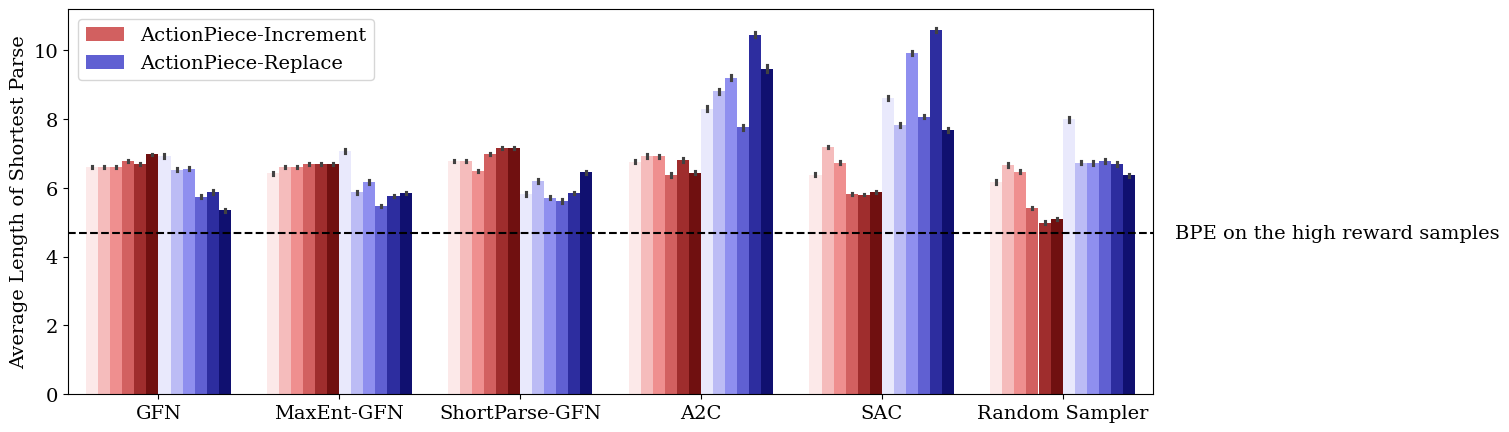

In [76]:
get_results("L14_RNA1")

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_300119/2398442692.py:30: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


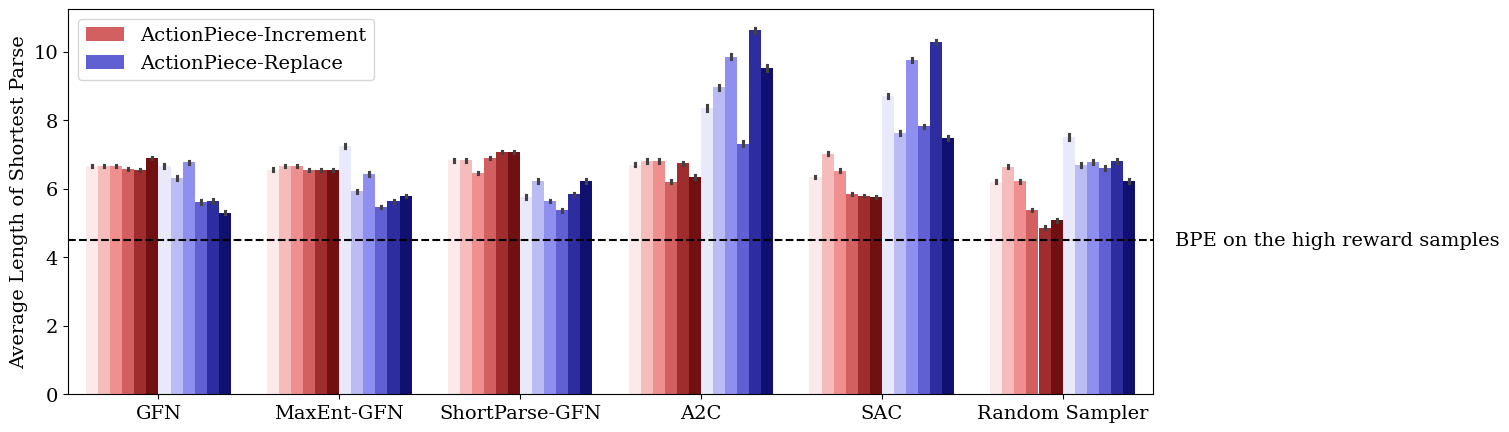

In [77]:
get_results("L14_RNA2")

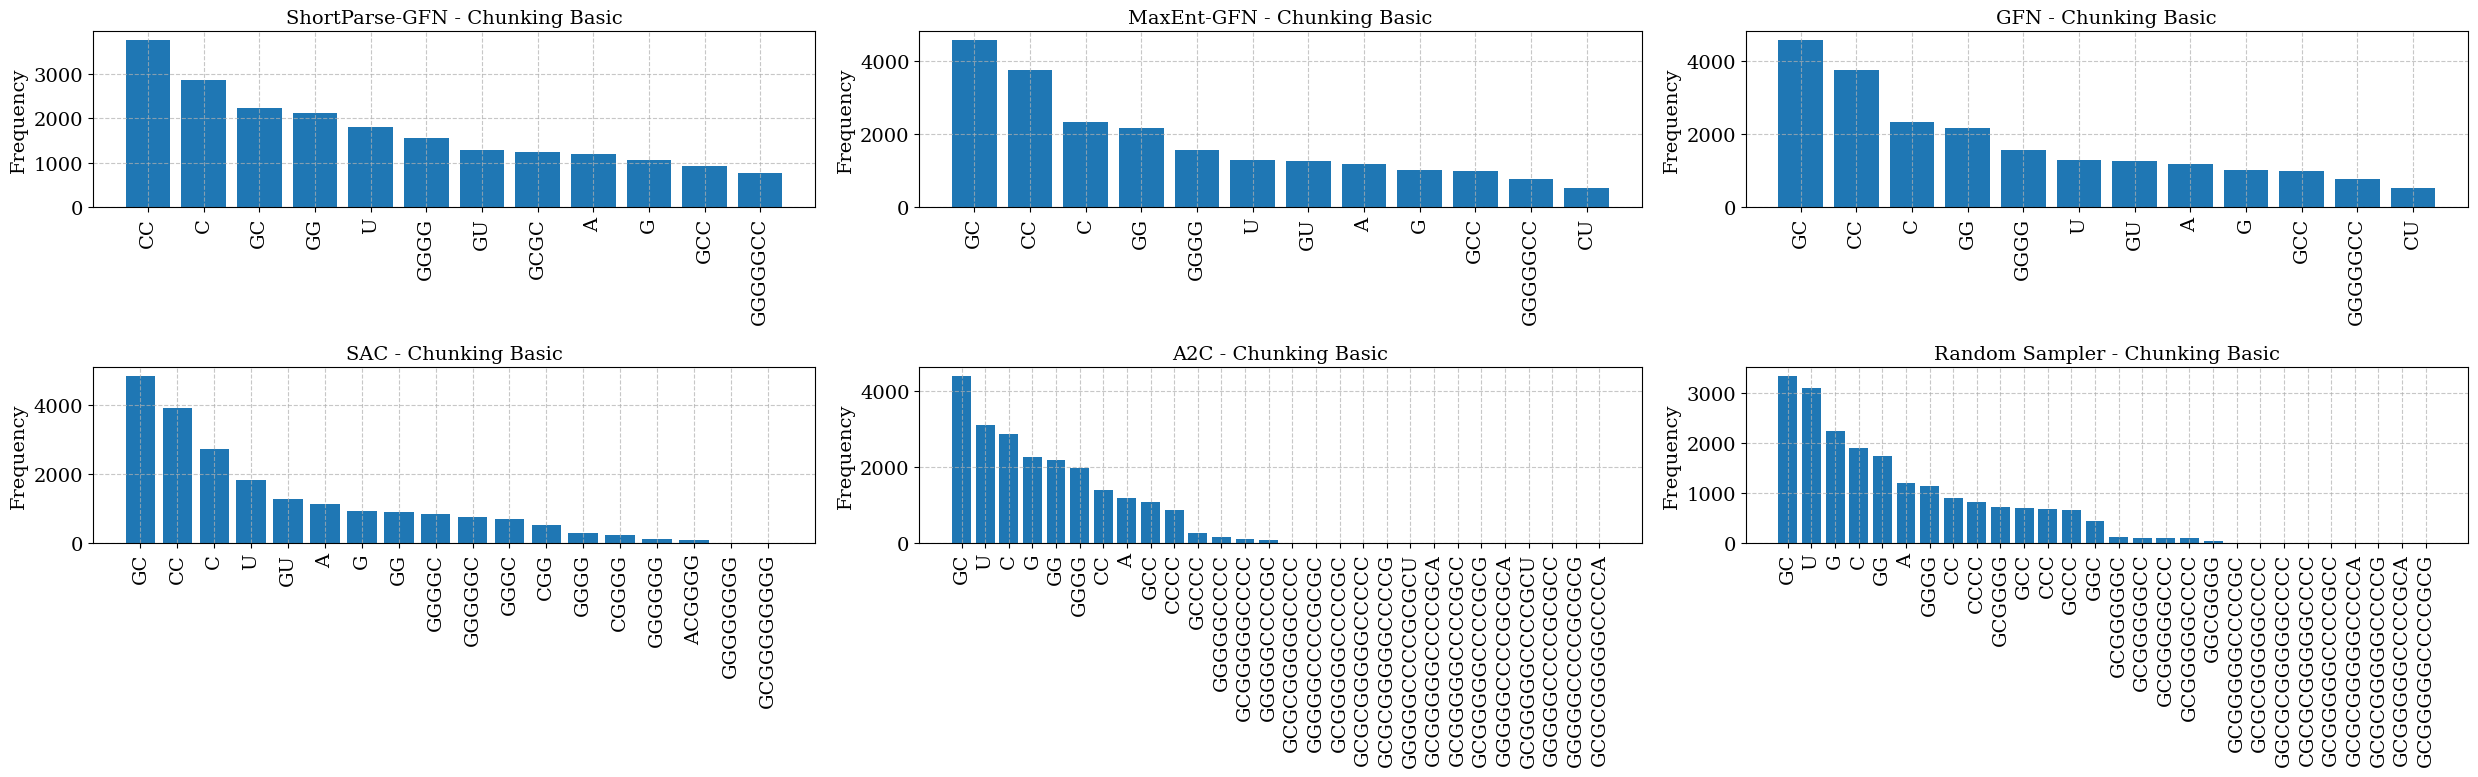

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(25,8))



for i, algo in enumerate(short_parse_libraries):

    library, count = short_parse_libraries[algo]["Chunking Basic"]

    positions = range(len(library))
    bars = ax[i//3,i%3].bar(positions, count)

    ax[i//3,i%3].set_xticks(positions)
    ax[i//3,i%3].set_xticklabels(library)
    ax[i//3,i%3].set_ylabel('Frequency')
    ax[i//3,i%3].set_title(f"{algo} - Chunking Basic")
    ax[i//3,i%3].tick_params(axis='x', rotation=90)
    ax[i//3,i%3].grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

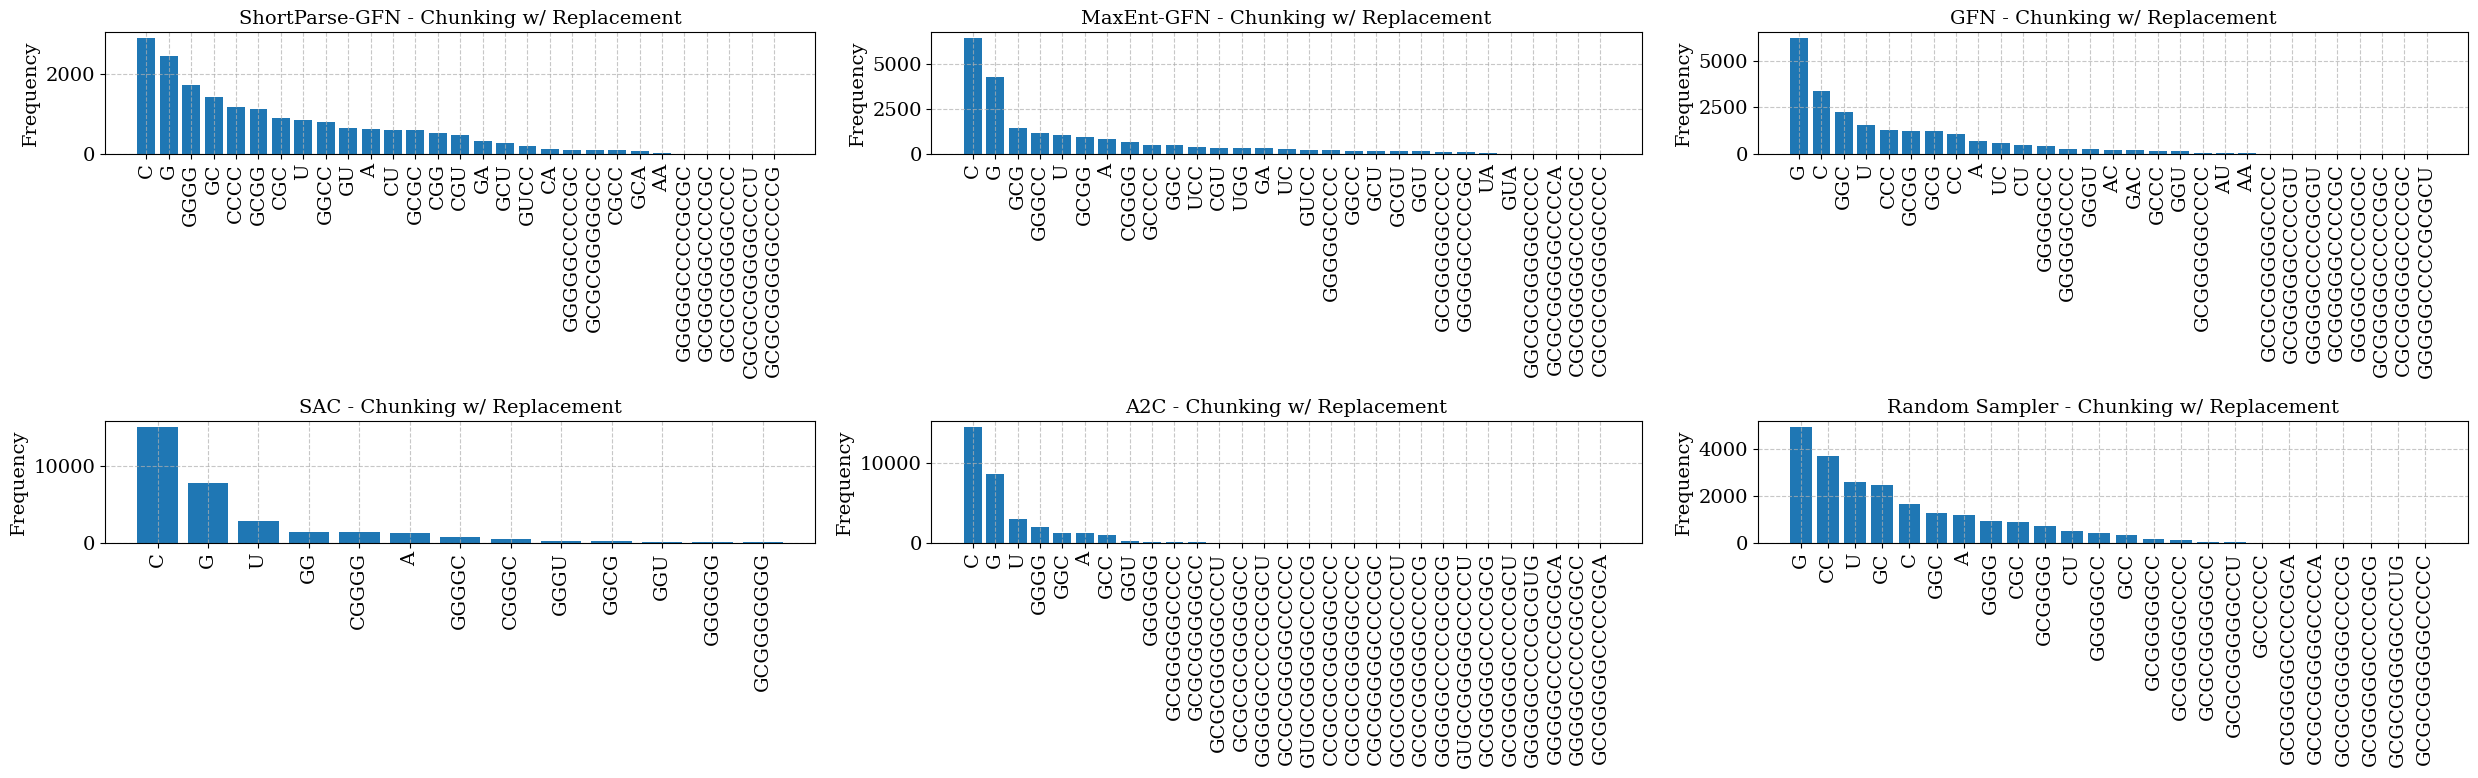

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(25,8))



for i, algo in enumerate(short_parse_libraries):

    library, count = short_parse_libraries[algo]["Chunking w/ Replacement"]

    positions = range(len(library))
    bars = ax[i//3,i%3].bar(positions, count)

    ax[i//3,i%3].set_xticks(positions)
    ax[i//3,i%3].set_xticklabels(library)
    ax[i//3,i%3].set_ylabel('Frequency')
    ax[i//3,i%3].set_title(f"{algo} - Chunking w/ Replacement")
    ax[i//3,i%3].tick_params(axis='x', rotation=90)
    ax[i//3,i%3].grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

### Evolution of shortest parse of modes

In [ ]:
evolving_libraries = Dict()
for algorithm in tqdm(experiments["L14_RNA1"]):
    for chunk_type in experiments["L14_RNA1"][algorithm]:
        if chunk_type != "No Chunk":
            evolving_libraries[algorithm][chunk_type] = []
            run = experiments["L14_RNA1"][algorithm][chunk_type][0]
            run_id = run["id"]
            direc = Path(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}")
            for path in direc.glob("library_*.pt"):
                lib = torch.load(path)
                lib = [a[1] for a in lib]
                evolving_libraries[algorithm][chunk_type].append(lib)


  0%|          | 0/6 [00:00<?, ?it/s]

In [131]:
evolving_short_parse = Dict()
for algorithm in tqdm(evolving_libraries):
    for chunk_type in evolving_libraries[algorithm]:
        for mode in modes["L14_RNA1"]:
            evolving_short_parse[algorithm][chunk_type][mode] = []
            for i, vocab in enumerate(evolving_libraries[algorithm][chunk_type]):
                mini, _ = shortest_parse(vocab, mode)
                evolving_short_parse[algorithm][chunk_type][mode].append(mini)

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

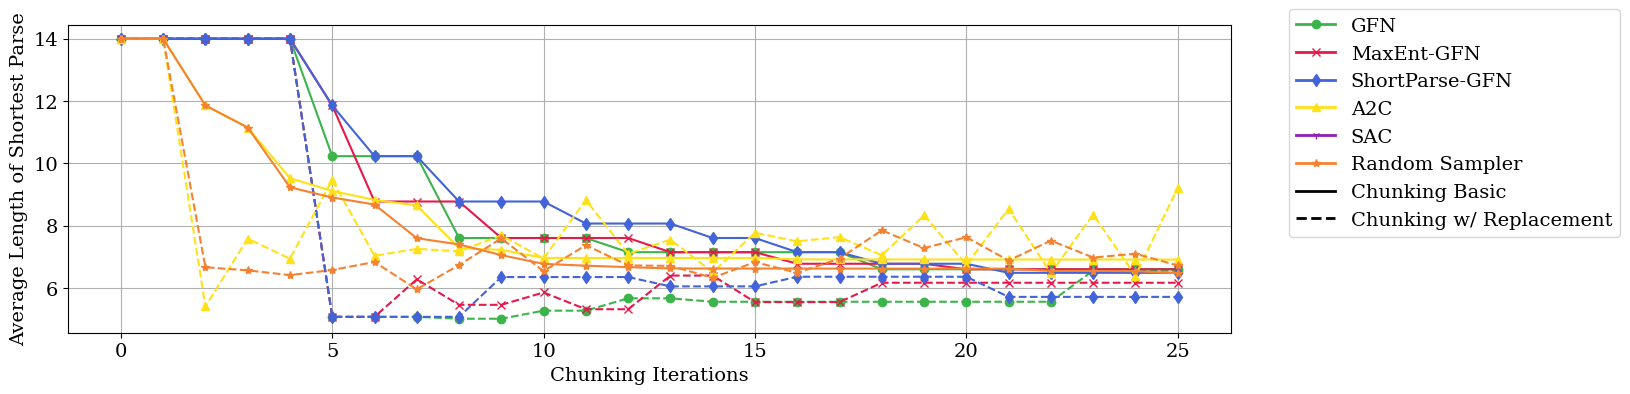

In [133]:
fig, ax = plt.subplots(1,1,figsize=(15,4))


markers = {
    "GFN": "o",
    "MaxEnt-GFN": "x",
    "ShortParse-GFN": "d",
    "A2C": "^",
    "SAC": "1",
    "Random Sampler": "*"
}
linestyles = {
    "Chunking Basic": "-",
    "Chunking w/ Replacement": "--"
}
for j, algorithm in tqdm(enumerate(["GFN", "MaxEnt-GFN", "ShortParse-GFN", "A2C", "Random Sampler"])):
    for i, chunk_type in enumerate(["Chunking Basic", "Chunking w/ Replacement"]):
        mean = np.mean(list(evolving_short_parse[algorithm][chunk_type].values()), axis=0)
        std = np.std(list(evolving_short_parse[algorithm][chunk_type].values()), axis=0)
        ax.plot(mean, linestyle=linestyles[chunk_type], color=algo_colors[algorithm], marker=markers[algorithm])
        #ax.fill_between(range(len(mean)), mean-std, mean+std, linestyle=linestyles[chunk_type], color=colors[algorithm], alpha=0.5)

ax.set_ylabel("Average Length of Shortest Parse")
ax.set_xlabel("Chunking Iterations")
legend_elements = [
    Line2D([0], [0], color=algo_colors['GFN'], lw=2, linestyle='-', marker=markers["GFN"], label='GFN'),
    Line2D([0], [0], color=algo_colors['MaxEnt-GFN'], lw=2, linestyle='-', marker=markers["MaxEnt-GFN"], label='MaxEnt-GFN'),
    Line2D([0], [0], color=algo_colors['ShortParse-GFN'], lw=2, linestyle='-', marker=markers["ShortParse-GFN"], label='ShortParse-GFN'),
    Line2D([0], [0], color=algo_colors['A2C'], lw=2, linestyle='-', marker=markers["A2C"], label='A2C'),
    Line2D([0], [0], color=algo_colors['SAC'], lw=2, linestyle='-', marker=markers["SAC"], label='SAC'),
    Line2D([0], [0], color=algo_colors['Random Sampler'], lw=2, linestyle='-', marker=markers["Random Sampler"], label='Random Sampler'),
    Line2D([0], [0], color="black", lw=2, linestyle=linestyles["Chunking Basic"], label='Chunking Basic'),
    Line2D([0], [0], color="black", lw=2, linestyle=linestyles["Chunking w/ Replacement"], label='Chunking w/ Replacement')
    ]

# Create the custom legend
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
ax.grid()

### IoU of libraries against BPE high rewards libraries

In [13]:
iou = Dict()
for task in ["L14_RNA1", "L14_RNA2"]:
    vcb = set([a for a in high_reward_libs[task] if a not in ["<EOS>", "A", "C", "G", "U"]])
    for algorithm in libraries:
        for chunk_type in libraries[algorithm]:
            vocab = set([a[1] for a in libraries[algorithm][chunk_type] if a[1] not in ["<EOS>", "A", "C", "G", "U"]])
            iou[task][algorithm][chunk_type] = round(len(vocab.intersection(vcb))/len(vocab.union(vcb)),2)

In [20]:
vcb_1 = set([a for a in high_reward_libs["L14_RNA1"] if a not in ["<EOS>", "A", "C", "G", "U"]])
vcb_2 = set([a for a in high_reward_libs["L14_RNA2"] if a not in ["<EOS>", "A", "C", "G", "U"]])

In [22]:
round(len(vcb_1.intersection(vcb_2))/len(vcb_1.union(vcb_2)),2)

0.53

## Downstream Evaluation

In [6]:
libs = {
    "A,C,G,U,GG,GGGG,CC,CCCC,GCCCC,GGGGGCCCC,GC,GCGGGGGCCCC,GCC,GCGGGGGCCCCGC,GCGGGGGCCCCGCG,GCGGGGGCCCCGCA,GCGGGGGCCCCGCC,GCGGGGGCCCCGCU,GGGGGCCCCGC,GCGCGGGGGCCCC,GGGGGCCCCGCGC,GGGGGCCCCGCGCG,GCGCGGGGGCCCCG,GGGGGCCCCGCGCC,GGGGGCCCCGCGCU,GGGGGCCCCGCGCA,GCGCGGGGGCCCCA,GCGCGGGGGCCCCC": ("A2C", "Chunking Basic"),
    "A,C,G,U,GCGCGGGGGCCCCU,GCGCGGGGGCCCCG,GGU,GCGGGGGCCCCGCU,CGCGGGGGCCCCGC,GUGCGGGGGCCCCU,CGCGCGGGGGCCCC,GGC,GGGG,GCGGGGGCCCCGCG,GCGCGCGGGGGCC,GGGGGCCCCGCGCG,CCGCGCGGGGGCCC,GGGGGCCCCGCGCA,GGGGGCCCCGCGCU,GGGGGG,GGGGGCCCCGCGCC,GCGGGGGCCCC,GGGGGCCCCGCGUG,GCGCGGGGGCCCU,GCGCGGGGGCC,GCC,GUGCGGGGGCCCCG,GCGCGGGGGCCCCC,GCGGGGGCCCCGCA": ("A2C", "Chunking w/ Replacement"),
    "A,C,G,U,GG,GGGG,GGGGGGGG,GGGGGGGGGGGG,GGGGGG,GC,CGGGG,GGGGGGGGGGGGGC,GGGC,GU,GCGGGGGGGGGGGG,GCGGGGGGGG,GGGGGGGGCGGGG,CGG,GGGGGC,CC,GGGGGGGGCGGGGC,GGGGC,GGGGGGGGCGGGGU,GGGGGGGGCGGGGG,CGGGGGGGG,GGGGGGGGCGGGGA,ACGGGG,CGGGGGGGGCGGGG": ("SAC", "Chunking Basic"),
    "A,C,G,U,GGCGGGGGGCGGGG,GGCGGGGGGGGGGG,GCGGGGGGGGGGCG,GGGGGGGGGGGGGU,GGGGCGGGGGGGG,CGGGG,GGGGC,GGGGGGGGGGGGGG,GGCG,GGGCGGGGGGGGG,GGGGGGGGGCGGGC,GG,CGGGCGGGGGGGG,GCGGGGGGGGGGGU,GGCGGGGGGGG,GGGGGG,GGGU,GGU,CGGGC,GCGGGGGGG,GCGGGGGGGGGGGG,GGGGGGGGGGGGCG,GGGGGGGGGGGGG,GGGCGGGGGGGG,GCGGGCGGGGGGGG": ("SAC", "Chunking w/ Replacement"),
    "A,C,G,U,GG,GGGG,GC,GCGGGG,GGC,CC,GCGGGGGC,CCC,GCC,GCGGGGGCC,GCGGGGGCCCC,GCGGGGGCCC,GCGCGGGGGCCCC,GGCGCGGGGGCCCC,GCGGGGGCCCCGCC,GCGGGGGCCCCGC,GCGGGGGCCCCGCA,GCGCGGGGGCCCCG,GCGCGGGGGCCCCA,GCGGGGGCCCCGCG,CCCC,CGCGCGGGGGCCCC,GGCGGGG,GCCC": ("Random Sampler", "Chunking Basic"),
    "A,C,G,U,GCC,GCGCGGGGGCCUAU,GCGGGGGCC,GCGCGGGGGCCCCC,GCGGGGGCCCCGCA,GCGCGGGGGCCU,GC,CC,GCGCGGGGGCCCUG,GCGCGGGGGCCCCG,GGC,GGGGGCC,GCGCGGGGGCCUAG,CGC,GCGGGGGCCCC,GGGG,GCGGGGGCCCCGCG,GCGGGG,GCGCGGGGGCCCCA,GCCCCCC,GCGCGGGGGCC,GCGCGGGGGCCUAA,CU": ("Random Sampler", "Chunking w/ Replacement"),
    "A,C,G,U,GG,CC,GC,GGGG,GCC,GU,GGGGGCC,CU": ("GFN", "Chunking Basic"),
    "A,C,G,U,GGU,GCGCGGGGGCCCC,GCGGGGGCCCCGC,CGCGGGGGCCCCGC,GGGGGCC,GCGGGGGCCCCGU,CC,AA,UC,GGGGGCCCCGCGCU,GCGG,AU,GGGGGCCCC,GCCC,GGC,GCGGGGGCCCC,GGGGGCCCCGCGC,GCG,GGGGGCCCCGCGU,GCGGGGGCCCCGGC,AC,GAC,CCC,CU,GGGU": ("GFN", "Chunking w/ Replacement"),
    "A,C,G,U,GG,CC,GC,GGGG,GCC,GU,GGGGGCC,CU": ("MaxEnt-GFN", "Chunking Basic"),
    "A,C,G,U,GUA,GCU,GGGCC,GGU,CGCGGGGGCCCCGC,GGGGGCCCC,UC,UA,GCGGGGGCCCC,UGG,CGU,GA,UCC,GCGU,GGGGGCCCCGC,GCCCC,GCGG,GGCGCGGGGGCCCC,CGCGCGGGGGCCCC,GCGCGGGGGCCCCA,GCG,GGCC,GUCC,GGC,CGGGG": ("MaxEnt-GFN", "Chunking w/ Replacement"),
    "A,C,G,U,GG,CC,GC,GGGG,GCC,GU,GGGGGCC,GCGC": ("ShortParse-GFN", "Chunking Basic"),
    "A,C,G,U,CCCC,GCGC,GCGCGGGGGCCCC,CGCC,GA,GCGG,GGGGGCCCCGC,CGG,GCU,CU,GGCC,CGCGCGGGGGCCCU,GUCC,CGU,GCA,GGGG,CA,GGGGGCCCCGCGC,GCGCGGGGGCC,GCGCGGGGGCCCCG,CGC,GC,AA,GU,GCGGGGGCCCCGC": ("ShortParse-GFN", "Chunking w/ Replacement")
}

In [ ]:
api = wandb.Api()
runs = api.runs(path="yoshua-bengio/gfn-chunking", filters={"config.task_name": "rna_binding", "tags": "chunk_eval"})

# Group runs by algorithm and then length
experiments_vocab = Dict()
for run in tqdm(runs):
    name = run.name
    summary = {}
    summary["num_modes"] = run.summary["train/num_modes"]
    summary["id"] = run.id
    config = run.config

    algo = config["algo"]["_target_"].lower()
    task = config["environment"]["task"]
    lib_algo, chunk_type = libs[",".join(config["environment"]["actions"])]

    if "a2c" in algo:
        algorithm = "A2C"
    elif "tbgfn" in algo:
        if "alpha" in config["algo"]["backward_policy"]:
            if config["algo"]["backward_policy"]["alpha"] == 0:
                algorithm = "MaxEnt-GFN"
            else:
                algorithm = "ShortParse-GFN"
        else:
            algorithm = "GFN"

    elif "random" in algo:
        algorithm = "Random Sampler"
    elif "sac" in algo:
        algorithm = "SAC"
    else:
        raise Exception("can't recognize algorithm")



    if len(experiments_vocab[task][algorithm][chunk_type][lib_algo]) == 0:
        experiments_vocab[task][algorithm][chunk_type][lib_algo] = [summary]
    else:
        experiments_vocab[task][algorithm][chunk_type][lib_algo].append(summary)

  0%|          | 0/432 [00:00<?, ?it/s]

### Number of modes

In [8]:
num_modes = Dict()
for algo in ["GFN", "A2C", "SAC", "Random Sampler"]:
    for lib_algo in ["ShortParse-GFN", "MaxEnt-GFN", "GFN", "A2C", "SAC", "Random Sampler"]:
        for chunk_type in ["Chunking Basic", "Chunking w/ Replacement"]:
            for task in experiments_vocab.keys():
                try:
                    if chunk_type == "Chunking Basic" and lib_algo == "GFN":
                        mean = np.mean([experiments_vocab[task][algo]["Chunking Basic"]["MaxEnt-GFN"][i]["num_modes"] for i in range(3)])
                        std = np.std([experiments_vocab[task][algo]["Chunking Basic"]["MaxEnt-GFN"][i]["num_modes"] for i in range(3)])
                        num_modes[task][chunk_type][algo][lib_algo] = (mean, std)
                    else:
                        mean = np.mean([experiments_vocab[task][algo][chunk_type][lib_algo][i]["num_modes"] for i in range(3)])
                        std = np.std([experiments_vocab[task][algo][chunk_type][lib_algo][i]["num_modes"] for i in range(3)])
                        num_modes[task][chunk_type][algo][lib_algo] = (mean, std)
                except:
                    pass

In [9]:
labels = {
    "Chunking Basic": "ActionPiece-Increment",
    "Chunking w/ Replacement": "ActionPiece-Replace"
}

/tmp/ipykernel_4023668/1208978807.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


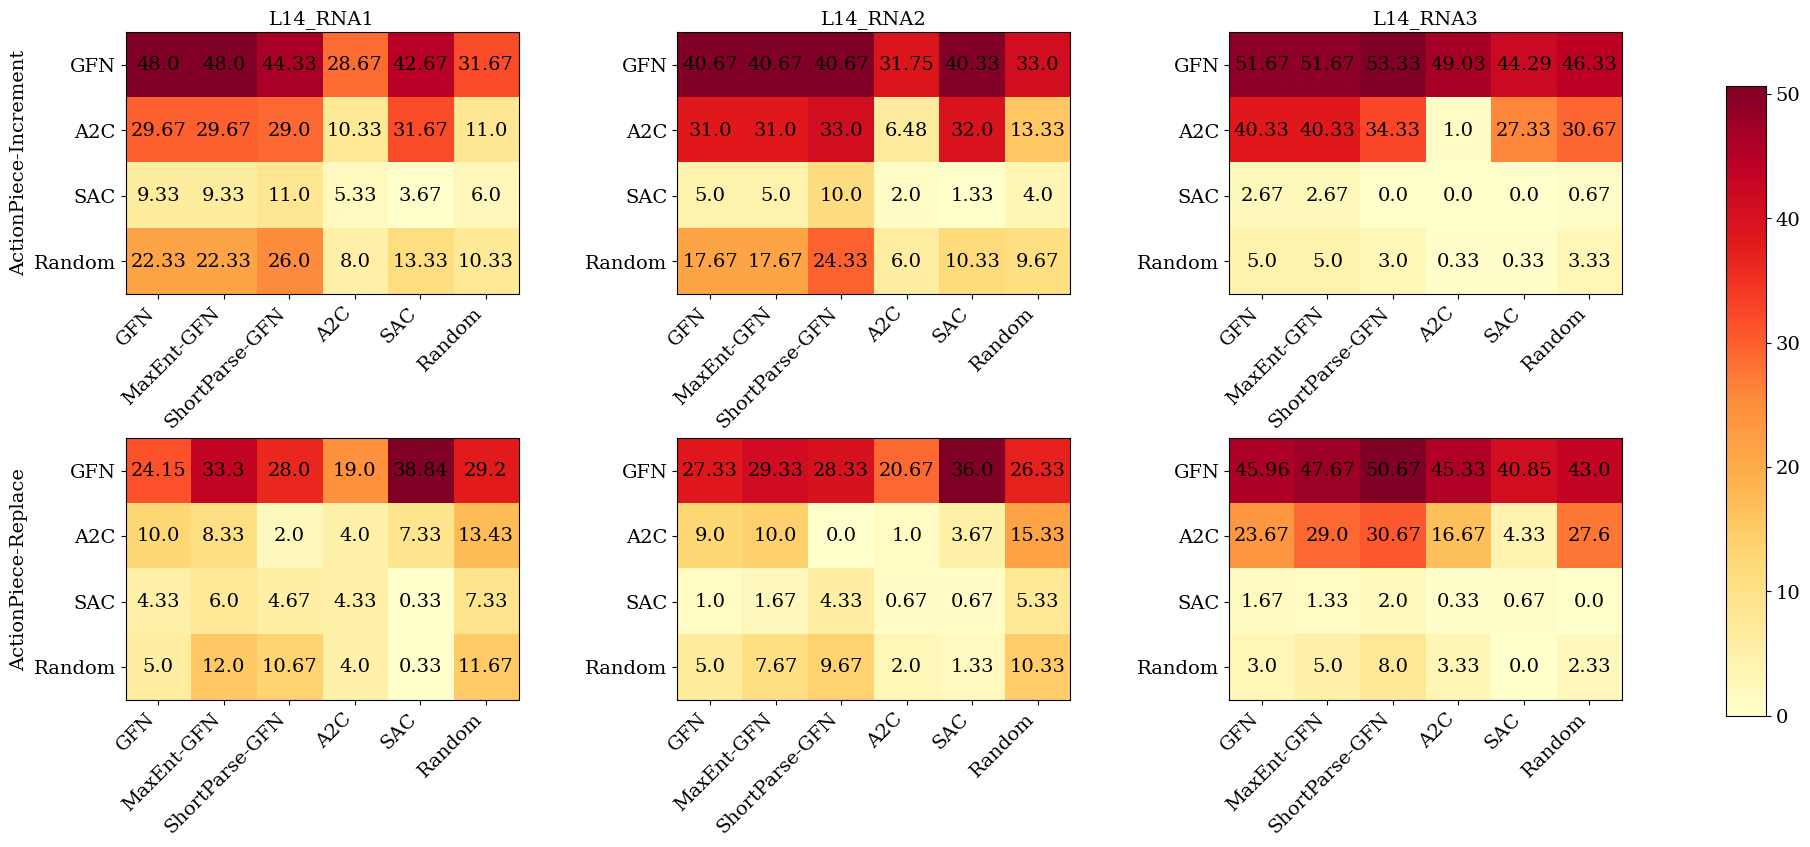

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(2*10,3*3))
fig.subplots_adjust(right=0.85, bottom=0.15)  # Make room for the colorbar

for i, chunk_type in enumerate(["Chunking Basic", "Chunking w/ Replacement"]):
    for j, task in enumerate(["L14_RNA1", "L14_RNA2", "L14_RNA3"]):
        data = num_modes[task][chunk_type]
        matrix = np.array([[data[row][col][0] for col in ['GFN', 'MaxEnt-GFN', 'ShortParse-GFN', 'A2C', 'SAC', 'Random Sampler']] for row in ['GFN', 'A2C', 'SAC', 'Random Sampler']])
        im = ax[i,j].imshow(matrix, cmap='YlOrRd')

        for m, row in enumerate(['GFN', 'A2C', 'SAC', 'Random Sampler']):
            for l, col in enumerate(['GFN', 'MaxEnt-GFN', 'ShortParse-GFN', 'A2C', 'SAC', 'Random Sampler']):
                text = ax[i,j].text(l, m, round(matrix[m, l], 2), ha="center", va="center", color="black")

        # Set the tick labels
        ax[i,j].set_xticks(np.arange(6))
        ax[i,j].set_yticks(np.arange(4))
        ax[i,j].set_xticklabels(['GFN', 'MaxEnt-GFN', 'ShortParse-GFN', 'A2C', 'SAC', 'Random'], rotation=45, ha='right')
        ax[i,j].set_yticklabels(['GFN', 'A2C', 'SAC', 'Random'])

        if i == 0:
            ax[i,j].set_title(task)

        if j == 0:
            ax[i,j].set_ylabel(labels[chunk_type])

# Add a colorbar to the right of the subplots
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)


plt.tight_layout(rect=[0, 0, 0.85, 0.95])
fig.savefig("downstream.pdf", format="pdf", dpi=300, bbox_inches='tight')

### Random Sampler

In [ ]:
modules = {
    "GFN": TBGFN,
    "A2C": A2C,
    "Random Sampler": RandomSampler
}

logrewards = Dict()
avg_top100_distance = Dict()
avg_top100 = Dict()

modes_num = Dict()

for algo in tqdm(experiments["L14_RNA1"]):
    for chunk_type in ["Chunking Basic", "Chunking w/ Replacement"]:
        lib = [a[1] for a in libraries[algo][chunk_type]]
        run_id = experiments["L14_RNA1"]["Random Sampler"]["No Chunk"][0]["id"]

        sampler = modules["Random Sampler"].load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")
        env = RNABindingModule.load_from_checkpoint(f"/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/{run_id}/checkpoints/last.ckpt")

        env.actions = lib
        env.action_len = torch.Tensor(
                [len(x) if x not in env.atomic_tokens else 1 for x in env.actions ]
            ).long()
        env.action_frequency = torch.zeros(env.n_actions)

        logreward, final_state, _, _, _ = sample_trajectories(10000, sampler, env)
        logreward = logreward.cpu()

        modes = set([s.replace(env.exit_action, "") for s in env.to_strings(final_state)]).intersection(env.modes)
        modes_num[algo][chunk_type] = len(modes)

        top100 = torch.topk(logreward, k=100)
        final_state = final_state[top100.indices].cpu()

        state_strings = [s.replace(env.exit_action, "") for s in env.to_strings(final_state)]

        avg_top100_distance[algo][chunk_type] = np.mean([[levenshtein(state_strings[i], state_strings[j]) for i in range(len(state_strings))] for j in range(i+1, len(state_strings))])
        logrewards[algo][chunk_type] = logreward
        avg_top100[algo][chunk_type] = top100.values.cpu().exp().mean()

  0%|          | 0/3 [00:00<?, ?it/s]

/home/mila/o/oussama.boussif/venvs/ai_scientist/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:94: The state dict in '/network/scratch/o/oussama.boussif/chunkgfn/logs/rna_binding/runs/4966910/checkpoints/last.ckpt' contains no parameters.


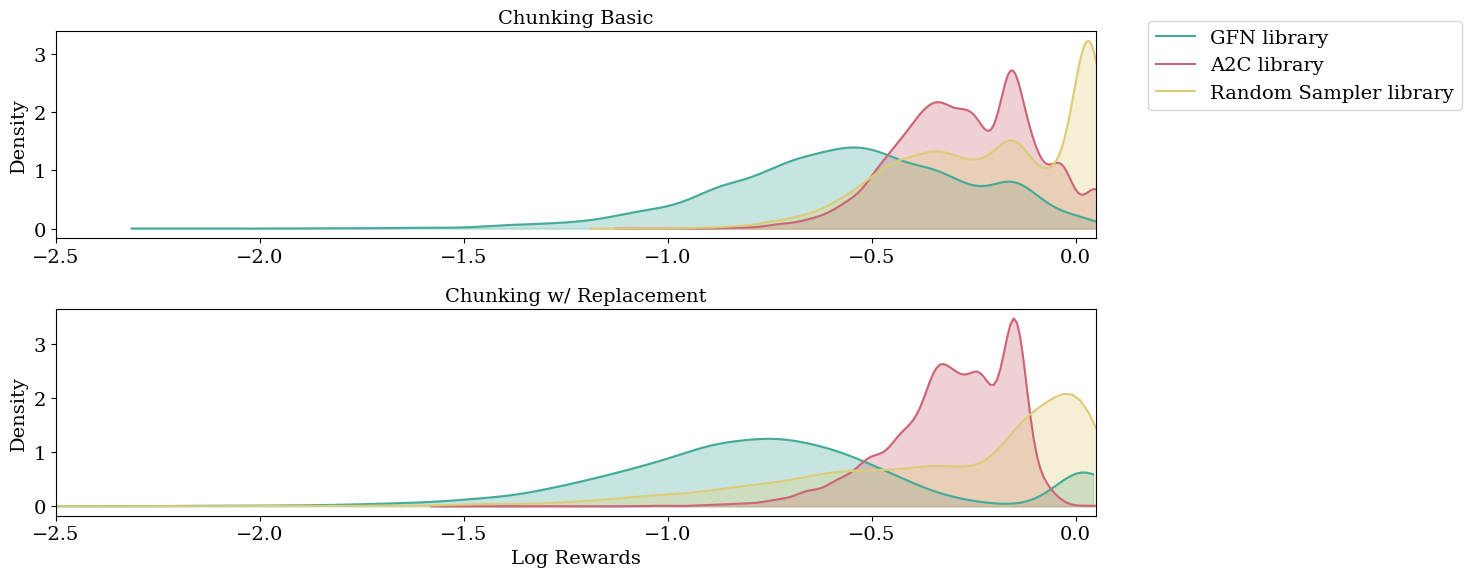

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 6))
colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}

for i, algo in enumerate(logrewards.keys()):
    for j, chunk_type in enumerate(['Chunking Basic', "Chunking w/ Replacement"]):
        data = logrewards[algo][chunk_type]

        # Calculate the KDE
        kde = stats.gaussian_kde(data)
        x_range = np.linspace(min(data), max(data), 200)
        y_kde = kde(x_range)

        # Plot the KDE
        ax[j].plot(x_range, y_kde, label=f"{algo} library", color=colors[algo])
        ax[j].fill_between(x_range, y_kde, alpha=0.3, color=colors[algo])

        ax[j].set_xlim(-2.5, 0.05)
        if j == 0:
            ax[j].legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
        ax[j].set_title(chunk_type)
        ax[j].set_ylabel('Density')

    if j == 1:
        ax[j].set_xlabel('Log Rewards')

fig.tight_layout()
plt.show()

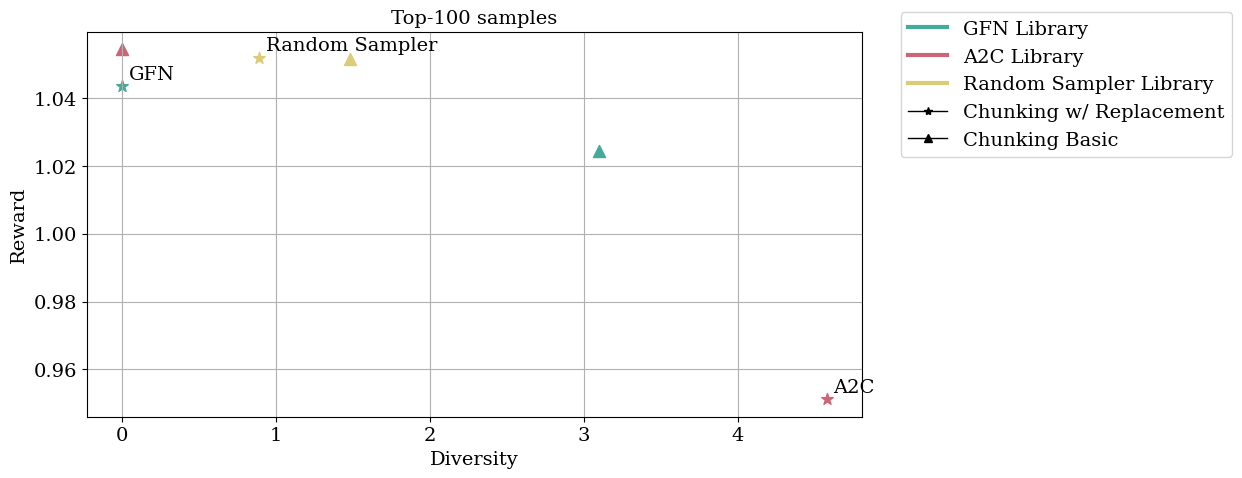

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
markers = {
    "Chunking w/ Replacement": "*",
    "Chunking Basic": "^"
}
colors = {
    "GFN": "#44AA99",
    "A2C": "#CC6677",
    "Random Sampler": "#DDCC77"
}
for i, chunk_type in enumerate(markers.keys()):
    for j, algo in enumerate(logrewards.keys()):

        ax.scatter(avg_top100_distance[algo][chunk_type], avg_top100[algo][chunk_type], s=75, color=colors[algo], marker=markers[chunk_type])

    if i == 0:
        for algo in logrewards.keys():
            ax.annotate(
                algo,
                (avg_top100_distance[algo][chunk_type], avg_top100[algo][chunk_type]),
                xytext=(5, 5),
                textcoords='offset points')


legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=3, linestyle='-', label='GFN Library'),
    Line2D([0], [0], color='#CC6677', lw=3, linestyle='-', label='A2C Library'),
    Line2D([0], [0], color='#DDCC77', lw=3, linestyle='-', label='Random Sampler Library'),
    Line2D([0], [0], color='black', lw=1, marker='*', label='Chunking w/ Replacement'),
    Line2D([0], [0], color='black', lw=1, marker='^', label='Chunking Basic')
]

# Create the custom legend
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


ax.set_xlabel("Diversity")
ax.set_ylabel("Reward")
ax.set_title("Top-100 samples")
ax.grid()
plt.show()

/tmp/ipykernel_815547/623869722.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))


0it [00:00, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


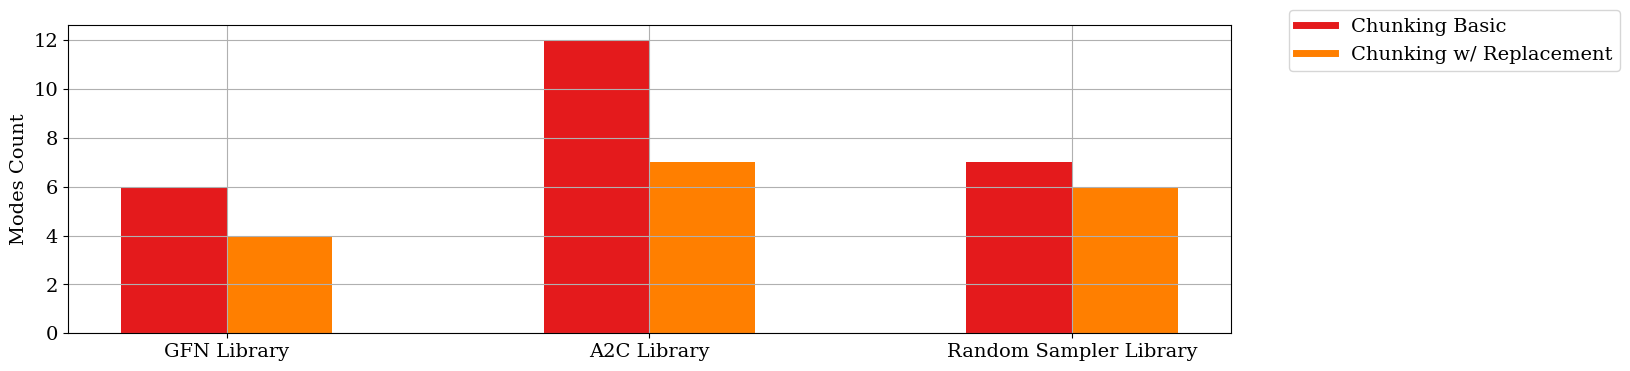

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,4))

colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, 3))
colors = {
    "Chunking w/ Replacement": [1.        , 0.49803922, 0.        , 1.        ],
    "Chunking Basic": [0.89411765, 0.10196078, 0.10980392, 1.        ]
}
for j, algorithm in tqdm(enumerate(["GFN", "A2C", "Random Sampler"])):
    for i, chunk_type in enumerate(["Chunking Basic", "Chunking w/ Replacement"]):
        x = j + i * 0.25

        bars = ax.bar(x, modes_num[algorithm][chunk_type], width=0.25, color=colors[chunk_type], align="edge")

ax.set_xticks([0.25,1.25,2.25])
ax.set_xticklabels(list(map(lambda x: f"{x} Library", short_parse.keys())))
ax.set_ylabel("Modes Count")
ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)

legend_elements = [
    Line2D([0], [0], color=colors['Chunking Basic'], lw=5, linestyle='-', label='Chunking Basic'),
    Line2D([0], [0], color=colors['Chunking w/ Replacement'], lw=5, linestyle='-', label='Chunking w/ Replacement')
    ]

# Create the custom legend
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
ax.grid()

In [ ]:
api = wandb.Api()
runs = api.runs(path="yoshua-bengio/gfn-chunking", filters={"config.task_name": "rna_binding", "tags": "chunking_strategy"})
columns = ["_step", 'train/num_modes', "train/loss_epoch", 'train/logreward', 'trainer/global_step']

# Group runs by algorithm and then length
experiments = Dict()
for run in tqdm(runs):
    name = run.name
    history = run.scan_history(keys=columns)
    summary = {}
    for row in history:
        for key in row.keys():
            if key not in summary:
                summary[key] = []
            summary[key].append(row[key])
    summary["id"] = run.id
    config = run.config

    algo = config["algo"]["_target_"].lower()
    task = config["environment"]["task"]

    if "loss" in algo:
        algorithm = "Adaptive GFN"
    elif "tbgfn" in algo:
        algorithm = "GFN"
    else:
        raise Exception("can't recognize algorithm")

    if "chunk" not in name:
        chunk_type = "No Chunk"
    elif "chunk_replacement" in name:
        chunk_type = "Chunking w/ Replacement"
    elif "chunk" in name:
        chunk_type = "Chunking Basic"

    if len(experiments[task][algorithm][chunk_type]) == 0:
        experiments[task][algorithm][chunk_type] = [summary]
    else:
        experiments[task][algorithm][chunk_type].append(summary)

  0%|          | 0/12 [00:00<?, ?it/s]

In [99]:
experiments["L14_RNA1"]["GFN"]["Chunking Basic"]

[{'id': '4982298'}, {'id': '4982289'}, {'id': '4982280'}]

KeyError: 'trainer/global_step'

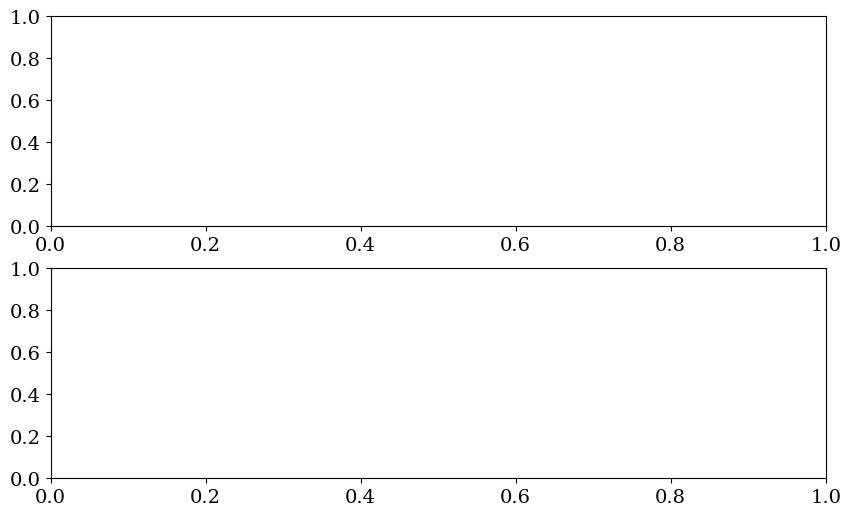

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

colors = {
    "GFN": "#44AA99",
    "Adaptive GFN": "#CC6677",
}
chunk_types = [
    "Chunking Basic",
    "Chunking w/ Replacement"
]
handles = []
lines = []
for algorithm in experiments["L14_RNA1"].keys():
    for i, chunk_type in enumerate(chunk_types):

        all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/num_modes", *experiments["L14_RNA1"][algorithm][chunk_type])


        ax[i].plot(all_iterations, mean, label=algorithm, color=colors[algorithm], linewidth=3)

        ax[i].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=colors[algorithm], alpha=0.5)

        ax[i].set_ylim(0,130)

        if i == 0:
            ax[i].set_title("L14_RNA1")

        if i == 2:
            ax[i].set_xlabel("Number of training steps")

        ax[i].text(1.05, 0.5, chunk_type, va='center', ha='left', transform=ax[i].transAxes)
        ax[i].set_ylabel("Number of Modes")


        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=1, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=1, linestyle='-', label='Adaptive GFN'),
]

# Create the custom legend
ax[0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


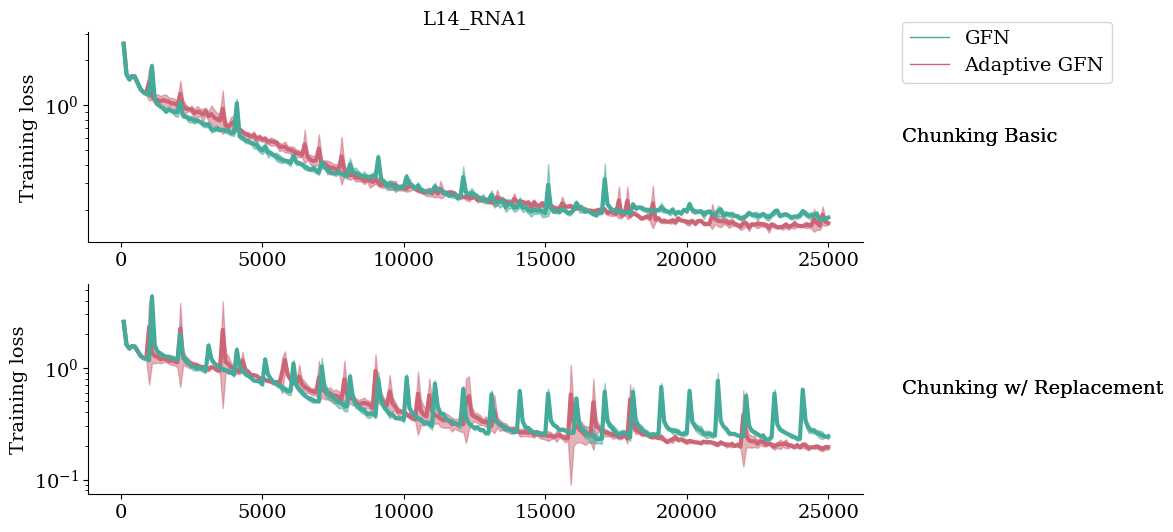

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

colors = {
    "GFN": "#44AA99",
    "Adaptive GFN": "#CC6677",
}
chunk_types = [
    "Chunking Basic",
    "Chunking w/ Replacement"
]
handles = []
lines = []
for algorithm in experiments["L14_RNA1"].keys():
    for i, chunk_type in enumerate(chunk_types):

        all_iterations, mean, std = calculate_mean_std("trainer/global_step", "train/loss_epoch", *experiments["L14_RNA1"][algorithm][chunk_type])


        ax[i].semilogy(all_iterations, mean, label=algorithm, color=colors[algorithm], linewidth=3)

        ax[i].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=colors[algorithm], alpha=0.5)


        if i == 0:
            ax[i].set_title("L14_RNA1")

        if i == 2:
            ax[i].set_xlabel("Number of training steps")

        ax[i].text(1.05, 0.5, chunk_type, va='center', ha='left', transform=ax[i].transAxes)
        ax[i].set_ylabel("Training loss")


        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=1, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=1, linestyle='-', label='Adaptive GFN'),
]

# Create the custom legend
ax[0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)


KeyError: 'trainer/global_step'

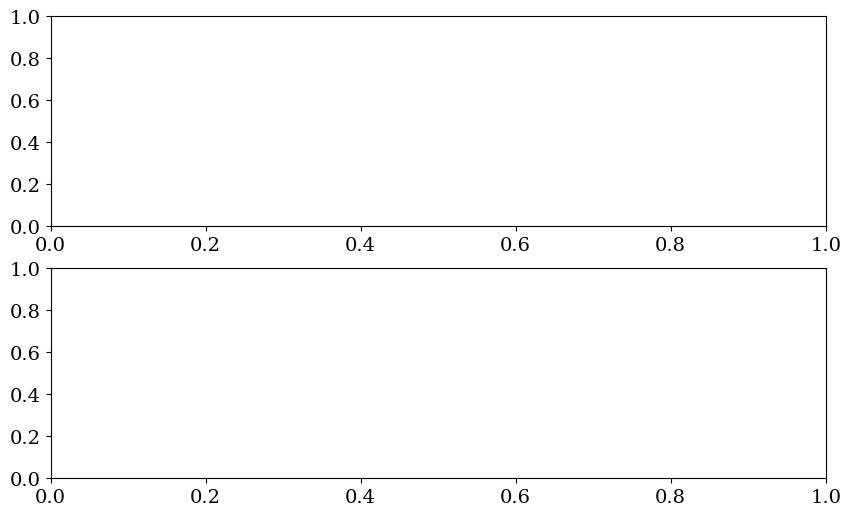

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

colors = {
    "GFN": "#44AA99",
    "Adaptive GFN": "#CC6677",
}
chunk_types = [
    "Chunking Basic",
    "Chunking w/ Replacement"
]
handles = []
lines = []
for algorithm in experiments["L14_RNA1"].keys():
    for i, chunk_type in enumerate(chunk_types):

        all_iterations, mean, std = calculate_mean_std("trainer/global_step", "val/correlation", *experiments["L14_RNA1"][algorithm][chunk_type])


        ax[i].semilogy(all_iterations, mean, label=algorithm, color=colors[algorithm], linewidth=3)

        ax[i].fill_between(all_iterations, np.array(mean) - np.array(std), np.array(mean) + np.array(std), color=colors[algorithm], alpha=0.5)


        if i == 0:
            ax[i].set_title("L14_RNA1")

        if i == 2:
            ax[i].set_xlabel("Number of training steps")

        ax[i].text(1.05, 0.5, chunk_type, va='center', ha='left', transform=ax[i].transAxes)
        ax[i].set_ylabel("Validation loss")


        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

legend_elements = [
    Line2D([0], [0], color='#44AA99', lw=1, linestyle='-', label='GFN'),
    Line2D([0], [0], color='#CC6677', lw=1, linestyle='-', label='Adaptive GFN'),
]

# Create the custom legend
ax[0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.05), loc='upper left', borderaxespad=0.)
